In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import backtrader as bt # Import the backtrader platform
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import seaborn as sns
from collections import deque

# BackTrader

In [2]:
def run_backtest(aStrategy,year_start=2009,year_end=2018,label="x"):
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(aStrategy)

    datapath = os.path.join('../../../../datas/spx-1950-2018.csv')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(year_start, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(year_end, 1, 1),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Write output
    cerebro.addwriter(bt.WriterFile, out='output/%s_%d_%d.csv'%(label,year_start,year_end),csv=True)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    return cerebro

## Momentum Strategy
* Long if the macd line crosses the signal line to the upside and a control Simple Moving Average has had a net negative direction in the last x periods (current SMA value below the value x periods ago) and set a stop price N x ATR times away from the close price.
  Close the position if the close price goes below the stop price            
  If still in the market, update the stop price only if it’s greater than the actual one.
* Short if the macd line crosses the signal line to the downside and a control Simple Moving Average has had a net positive direction in the last x periods (current SMA value below the value x periods ago) and set a stop price N x ATR times away from the close price.
Close the position if the close price goes beyond the stop price            
If still in the market, update the stop price only if it’s smaller than the actual one.     

In [3]:
class MomentumStrategy(bt.Strategy):
    '''
    This strategy is loosely based on some of the examples from the Van
    K. Tharp book: *Trade Your Way To Financial Freedom*. The logic:

      - Enter the market if:
        - The MACD.macd line crosses the MACD.signal line to the upside
        - The Simple Moving Average has a negative direction in the last x
          periods (actual value below value x periods ago)

     - Set a stop price x times the ATR value away from the close

     - If in the market:

       - Check if the current close has gone below the stop price. If yes,
         exit.
       - If not, update the stop price if the new stop price would be higher
         than the current
    '''

    params = (
        # Standard MACD Parameters
        ('macd1', 12),
        ('macd2', 26),
        ('macdsig', 9),
        ('atrperiod', 14),  # ATR Period (standard)
        ('atrdist', 1),   # ATR distance for stop price
        ('smaperiod', 30),  # SMA Period (pretty standard)
        ('dirperiod', 10),  # Lookback period to consider SMA trend direction
    )
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def __init__(self):

        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # MACD Indicator
        self.macd = bt.indicators.MACD(self.datas[0],
                                       period_me1=self.p.macd1,
                                       period_me2=self.p.macd2,
                                       period_signal=self.p.macdsig)

        # Cross of macd.macd and macd.signal
        self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
        self.mcross2 = bt.indicators.CrossDown(self.macd.macd, self.macd.signal)
        # To set the stop price
        self.atr = bt.indicators.ATR(self.data, period=self.p.atrperiod)

        # Control market trend
        self.sma = bt.indicators.SMA(self.data, period=self.p.smaperiod)
        self.smadir = self.sma - self.sma(-self.p.dirperiod)

    def start(self):
        self.order = None  # sentinel to avoid operrations on pending order

    def next(self):
        # Always long or short $10000 securities
        size = 10000./self.dataclose[0]
        
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))
        
        if self.order:
            return  # pending order execution

        if not self.position:  # not in the market
            if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                self.order = self.buy(size=size)
                self.log('{mo}BUY CREATE, %.2f' % self.dataclose[0])
                pdist = self.atr[0] * self.p.atrdist
                self.pstop = self.data.close[0] - pdist
            
            elif self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                self.order = self.sell(size=size)
                self.log('{mo}SELL CREATE, %.2f' % self.dataclose[0])
                pdist = self.atr[0] * self.p.atrdist
                self.pstop = self.data.close[0] + pdist
            

        else:  # in the market
            if self.position.size>0:
                pclose = self.data.close[0]
                pstop = self.pstop
                pdist = self.atr[0] * self.p.atrdist
                
                # Reverse long position
                if self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                    self.close()
                    self.order = self.sell(size=size)
                    self.log('{mo}[Reverse]SELL CREATE, %.2f' % self.dataclose[0])
                    self.pstop = self.data.close[0] + pdist

                # Close long position
                elif pclose < pstop:
                    self.close()  # stop met - get out
                    self.log('{mo}[Exit]SELL CREATE, %.2f' % self.dataclose[0])
                else:
                    # Update only if greater than
                    self.pstop = max(pstop, pclose - pdist)
            
            elif self.position.size<0:
                pclose = self.data.close[0]
                pstop = self.pstop
                pdist = self.atr[0] * self.p.atrdist
                
                # Reverse short position
                if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                    self.order = self.buy(size=size)
                    self.log('{mo}[Reverse]BUY CREATE, %.2f' % self.dataclose[0])
                    pdist = self.atr[0] * self.p.atrdist
                    self.pstop = self.data.close[0] - pdist
                    
                # Close short position
                if pclose > pstop:
                    self.close()  # stop met - get out
                    self.log('{mo}[Exit]BUY CREATE, %.2f' % self.dataclose[0])
                else:
                    # Update only if greater than
                    self.pstop = min(pstop, pclose + pdist)
run_backtest(MomentumStrategy,year_start=1999,year_end=2018,label='mo')            

Starting Portfolio Value: 100000.00
1999-02-22, Close, 1272.14 ; Position 0.000000
1999-02-23, Close, 1271.18 ; Position 0.000000
1999-02-24, Close, 1253.41 ; Position 0.000000
1999-02-25, Close, 1245.02 ; Position 0.000000
1999-02-26, Close, 1238.33 ; Position 0.000000
1999-03-01, Close, 1236.16 ; Position 0.000000
1999-03-02, Close, 1225.50 ; Position 0.000000
1999-03-03, Close, 1227.70 ; Position 0.000000
1999-03-04, Close, 1246.64 ; Position 0.000000
1999-03-05, Close, 1275.47 ; Position 0.000000
1999-03-08, Close, 1282.73 ; Position 0.000000
1999-03-09, Close, 1279.84 ; Position 0.000000
1999-03-10, Close, 1286.84 ; Position 0.000000
1999-03-11, Close, 1297.68 ; Position 0.000000
1999-03-12, Close, 1294.59 ; Position 0.000000
1999-03-15, Close, 1307.26 ; Position 0.000000
1999-03-16, Close, 1306.38 ; Position 0.000000
1999-03-17, Close, 1297.82 ; Position 0.000000
1999-03-18, Close, 1316.55 ; Position 0.000000
1999-03-19, Close, 1299.29 ; Position 0.000000
1999-03-22, Close, 1297.

2000-10-13, Close, 1374.17 ; Position 0.000000
2000-10-16, Close, 1374.62 ; Position 0.000000
2000-10-17, Close, 1349.97 ; Position 0.000000
2000-10-18, Close, 1342.13 ; Position 0.000000
2000-10-19, Close, 1388.76 ; Position 0.000000
2000-10-20, Close, 1396.93 ; Position 0.000000
2000-10-20, {mo}BUY CREATE, 1396.93
2000-10-23, BUY EXECUTED, 1396.93
2000-10-23, Close, 1395.78 ; Position 7.158555
2000-10-24, Close, 1398.13 ; Position 7.158555
2000-10-25, Close, 1364.90 ; Position 7.158555
2000-10-25, {mo}[Exit]SELL CREATE, 1364.90
2000-10-26, SELL EXECUTED, 1364.90
2000-10-26, Close, 1364.44 ; Position 0.000000
2000-10-27, Close, 1379.58 ; Position 0.000000
2000-10-30, Close, 1398.66 ; Position 0.000000
2000-10-31, Close, 1429.40 ; Position 0.000000
2000-11-01, Close, 1421.22 ; Position 0.000000
2000-11-02, Close, 1428.32 ; Position 0.000000
2000-11-03, Close, 1426.69 ; Position 0.000000
2000-11-06, Close, 1432.19 ; Position 0.000000
2000-11-07, Close, 1431.87 ; Position 0.000000
2000-1

2002-06-25, Close, 976.14 ; Position 0.000000
2002-06-26, Close, 973.53 ; Position 0.000000
2002-06-27, Close, 990.64 ; Position 0.000000
2002-06-28, Close, 989.82 ; Position 0.000000
2002-07-01, Close, 968.65 ; Position 0.000000
2002-07-02, Close, 948.09 ; Position 0.000000
2002-07-03, Close, 953.99 ; Position 0.000000
2002-07-05, Close, 989.03 ; Position 0.000000
2002-07-08, Close, 976.98 ; Position 0.000000
2002-07-08, {mo}BUY CREATE, 976.98
2002-07-09, BUY EXECUTED, 976.98
2002-07-09, Close, 952.83 ; Position 10.235624
2002-07-09, {mo}[Exit]SELL CREATE, 952.83
2002-07-10, SELL EXECUTED, 952.83
2002-07-10, Close, 920.47 ; Position 0.000000
2002-07-11, Close, 927.37 ; Position 0.000000
2002-07-12, Close, 921.39 ; Position 0.000000
2002-07-15, Close, 917.93 ; Position 0.000000
2002-07-16, Close, 900.94 ; Position 0.000000
2002-07-17, Close, 906.04 ; Position 0.000000
2002-07-18, Close, 881.56 ; Position 0.000000
2002-07-19, Close, 847.75 ; Position 0.000000
2002-07-22, Close, 819.85 ;

2004-03-05, Close, 1156.86 ; Position 0.000000
2004-03-08, Close, 1147.20 ; Position 0.000000
2004-03-09, Close, 1140.58 ; Position 0.000000
2004-03-10, Close, 1123.89 ; Position 0.000000
2004-03-11, Close, 1106.78 ; Position 0.000000
2004-03-12, Close, 1120.57 ; Position 0.000000
2004-03-15, Close, 1104.49 ; Position 0.000000
2004-03-16, Close, 1110.70 ; Position 0.000000
2004-03-17, Close, 1123.75 ; Position 0.000000
2004-03-18, Close, 1122.32 ; Position 0.000000
2004-03-19, Close, 1109.78 ; Position 0.000000
2004-03-22, Close, 1095.40 ; Position 0.000000
2004-03-23, Close, 1093.95 ; Position 0.000000
2004-03-24, Close, 1091.33 ; Position 0.000000
2004-03-25, Close, 1109.19 ; Position 0.000000
2004-03-26, Close, 1108.06 ; Position 0.000000
2004-03-29, Close, 1122.47 ; Position 0.000000
2004-03-30, Close, 1127.00 ; Position 0.000000
2004-03-30, {mo}BUY CREATE, 1127.00
2004-03-31, BUY EXECUTED, 1127.00
2004-03-31, Close, 1126.21 ; Position 8.873114
2004-04-01, Close, 1132.17 ; Position

2005-10-14, Close, 1186.57 ; Position 0.000000
2005-10-17, Close, 1190.10 ; Position 0.000000
2005-10-18, Close, 1178.14 ; Position 0.000000
2005-10-19, Close, 1195.76 ; Position 0.000000
2005-10-20, Close, 1177.80 ; Position 0.000000
2005-10-21, Close, 1179.59 ; Position 0.000000
2005-10-24, Close, 1199.38 ; Position 0.000000
2005-10-24, {mo}BUY CREATE, 1199.38
2005-10-25, BUY EXECUTED, 1199.38
2005-10-25, Close, 1196.54 ; Position 8.337641
2005-10-26, Close, 1191.38 ; Position 8.337641
2005-10-27, Close, 1178.90 ; Position 8.337641
2005-10-27, {mo}[Exit]SELL CREATE, 1178.90
2005-10-28, SELL EXECUTED, 1178.90
2005-10-28, Close, 1198.41 ; Position 0.000000
2005-10-31, Close, 1207.01 ; Position 0.000000
2005-11-01, Close, 1202.76 ; Position 0.000000
2005-11-02, Close, 1214.76 ; Position 0.000000
2005-11-03, Close, 1219.94 ; Position 0.000000
2005-11-04, Close, 1220.14 ; Position 0.000000
2005-11-07, Close, 1222.81 ; Position 0.000000
2005-11-08, Close, 1218.59 ; Position 0.000000
2005-1

2007-05-14, BUY EXECUTED, 1505.76
2007-05-14, Close, 1503.15 ; Position 0.000000
2007-05-15, Close, 1501.19 ; Position 0.000000
2007-05-16, Close, 1514.14 ; Position 0.000000
2007-05-17, Close, 1512.75 ; Position 0.000000
2007-05-18, Close, 1522.75 ; Position 0.000000
2007-05-21, Close, 1525.10 ; Position 0.000000
2007-05-22, Close, 1524.12 ; Position 0.000000
2007-05-23, Close, 1522.28 ; Position 0.000000
2007-05-23, {mo}SELL CREATE, 1522.28
2007-05-24, SELL EXECUTED, 1522.10
2007-05-24, Close, 1507.51 ; Position -6.569094
2007-05-25, Close, 1515.73 ; Position -6.569094
2007-05-29, Close, 1518.11 ; Position -6.569094
2007-05-30, Close, 1530.23 ; Position -6.569094
2007-05-30, {mo}[Exit]BUY CREATE, 1530.23
2007-05-31, BUY EXECUTED, 1530.19
2007-05-31, Close, 1530.62 ; Position 0.000000
2007-06-01, Close, 1536.34 ; Position 0.000000
2007-06-04, Close, 1539.18 ; Position 0.000000
2007-06-05, Close, 1530.95 ; Position 0.000000
2007-06-05, {mo}SELL CREATE, 1530.95
2007-06-06, SELL EXECUTED

2009-01-14, Close, 842.62 ; Position -11.490819
2009-01-15, Close, 843.74 ; Position -11.490819
2009-01-16, Close, 850.12 ; Position -11.490819
2009-01-20, Close, 805.22 ; Position -11.490819
2009-01-21, Close, 840.24 ; Position -11.490819
2009-01-21, {mo}[Exit]BUY CREATE, 840.24
2009-01-22, BUY EXECUTED, 839.74
2009-01-22, Close, 827.50 ; Position 0.000000
2009-01-23, Close, 831.95 ; Position 0.000000
2009-01-26, Close, 836.57 ; Position 0.000000
2009-01-27, Close, 845.71 ; Position 0.000000
2009-01-28, Close, 874.09 ; Position 0.000000
2009-01-29, Close, 845.14 ; Position 0.000000
2009-01-30, Close, 825.88 ; Position 0.000000
2009-02-02, Close, 825.44 ; Position 0.000000
2009-02-03, Close, 838.51 ; Position 0.000000
2009-02-04, Close, 832.23 ; Position 0.000000
2009-02-05, Close, 845.85 ; Position 0.000000
2009-02-05, {mo}BUY CREATE, 845.85
2009-02-06, BUY EXECUTED, 846.09
2009-02-06, Close, 868.60 ; Position 11.822427
2009-02-09, Close, 869.89 ; Position 11.822427
2009-02-10, Close,

2010-09-15, Close, 1125.07 ; Position 9.173470
2010-09-16, Close, 1124.66 ; Position 9.173470
2010-09-17, Close, 1125.59 ; Position 9.173470
2010-09-20, Close, 1142.71 ; Position 9.173470
2010-09-21, Close, 1139.78 ; Position 9.173470
2010-09-22, Close, 1134.28 ; Position 9.173470
2010-09-23, Close, 1124.83 ; Position 9.173470
2010-09-23, {mo}[Exit]SELL CREATE, 1124.83
2010-09-24, SELL EXECUTED, 1131.69
2010-09-24, Close, 1148.67 ; Position 0.000000
2010-09-27, Close, 1142.16 ; Position 0.000000
2010-09-28, Close, 1147.70 ; Position 0.000000
2010-09-29, Close, 1144.73 ; Position 0.000000
2010-09-30, Close, 1141.20 ; Position 0.000000
2010-10-01, Close, 1146.24 ; Position 0.000000
2010-10-04, Close, 1137.03 ; Position 0.000000
2010-10-05, Close, 1160.75 ; Position 0.000000
2010-10-06, Close, 1159.97 ; Position 0.000000
2010-10-07, Close, 1158.06 ; Position 0.000000
2010-10-08, Close, 1165.15 ; Position 0.000000
2010-10-11, Close, 1165.32 ; Position 0.000000
2010-10-12, Close, 1169.77 ; 

2012-05-30, Close, 1313.32 ; Position 0.000000
2012-05-31, Close, 1310.33 ; Position 0.000000
2012-06-01, Close, 1278.04 ; Position 0.000000
2012-06-04, Close, 1278.18 ; Position 0.000000
2012-06-05, Close, 1285.50 ; Position 0.000000
2012-06-06, Close, 1315.13 ; Position 0.000000
2012-06-07, Close, 1314.99 ; Position 0.000000
2012-06-07, {mo}BUY CREATE, 1314.99
2012-06-08, BUY EXECUTED, 1314.99
2012-06-08, Close, 1325.66 ; Position 7.604621
2012-06-11, Close, 1308.93 ; Position 7.604621
2012-06-12, Close, 1324.18 ; Position 7.604621
2012-06-13, Close, 1314.88 ; Position 7.604621
2012-06-14, Close, 1329.10 ; Position 7.604621
2012-06-15, Close, 1342.84 ; Position 7.604621
2012-06-18, Close, 1344.78 ; Position 7.604621
2012-06-19, Close, 1357.98 ; Position 7.604621
2012-06-20, Close, 1355.69 ; Position 7.604621
2012-06-21, Close, 1325.51 ; Position 7.604621
2012-06-21, {mo}[Exit]SELL CREATE, 1325.51
2012-06-22, SELL EXECUTED, 1325.92
2012-06-22, Close, 1335.02 ; Position 0.000000
2012-0

2014-01-22, Close, 1844.86 ; Position 0.000000
2014-01-23, Close, 1828.46 ; Position 0.000000
2014-01-24, Close, 1790.29 ; Position 0.000000
2014-01-27, Close, 1781.56 ; Position 0.000000
2014-01-28, Close, 1792.50 ; Position 0.000000
2014-01-29, Close, 1774.20 ; Position 0.000000
2014-01-30, Close, 1794.19 ; Position 0.000000
2014-01-31, Close, 1782.59 ; Position 0.000000
2014-02-03, Close, 1741.89 ; Position 0.000000
2014-02-04, Close, 1755.20 ; Position 0.000000
2014-02-05, Close, 1751.64 ; Position 0.000000
2014-02-06, Close, 1773.43 ; Position 0.000000
2014-02-07, Close, 1797.02 ; Position 0.000000
2014-02-10, Close, 1799.84 ; Position 0.000000
2014-02-11, Close, 1819.75 ; Position 0.000000
2014-02-11, {mo}BUY CREATE, 1819.75
2014-02-12, BUY EXECUTED, 1820.12
2014-02-12, Close, 1819.26 ; Position 5.495260
2014-02-13, Close, 1829.83 ; Position 5.495260
2014-02-14, Close, 1838.63 ; Position 5.495260
2014-02-18, Close, 1840.76 ; Position 5.495260
2014-02-19, Close, 1828.75 ; Position

2015-09-21, Close, 1966.97 ; Position 0.000000
2015-09-22, Close, 1942.74 ; Position 0.000000
2015-09-23, Close, 1938.76 ; Position 0.000000
2015-09-24, Close, 1932.24 ; Position 0.000000
2015-09-25, Close, 1931.34 ; Position 0.000000
2015-09-28, Close, 1881.77 ; Position 0.000000
2015-09-29, Close, 1884.09 ; Position 0.000000
2015-09-30, Close, 1920.03 ; Position 0.000000
2015-10-01, Close, 1923.82 ; Position 0.000000
2015-10-02, Close, 1951.36 ; Position 0.000000
2015-10-02, {mo}BUY CREATE, 1951.36
2015-10-05, BUY EXECUTED, 1954.33
2015-10-05, Close, 1987.05 ; Position 5.124631
2015-10-06, Close, 1979.92 ; Position 5.124631
2015-10-07, Close, 1995.83 ; Position 5.124631
2015-10-08, Close, 2013.43 ; Position 5.124631
2015-10-09, Close, 2014.89 ; Position 5.124631
2015-10-12, Close, 2017.46 ; Position 5.124631
2015-10-13, Close, 2003.69 ; Position 5.124631
2015-10-14, Close, 1994.24 ; Position 5.124631
2015-10-15, Close, 2023.86 ; Position 5.124631
2015-10-16, Close, 2033.11 ; Position

2017-06-06, Close, 2429.33 ; Position 0.000000
2017-06-07, Close, 2433.14 ; Position 0.000000
2017-06-08, Close, 2433.79 ; Position 0.000000
2017-06-09, Close, 2431.77 ; Position 0.000000
2017-06-12, Close, 2429.39 ; Position 0.000000
2017-06-13, Close, 2440.35 ; Position 0.000000
2017-06-14, Close, 2437.92 ; Position 0.000000
2017-06-15, Close, 2432.46 ; Position 0.000000
2017-06-15, {mo}SELL CREATE, 2432.46
2017-06-16, SELL EXECUTED, 2431.24
2017-06-16, Close, 2433.15 ; Position -4.111065
2017-06-19, Close, 2453.46 ; Position -4.111065
2017-06-19, {mo}[Exit]BUY CREATE, 2453.46
2017-06-20, BUY EXECUTED, 2450.66
2017-06-20, Close, 2437.03 ; Position 0.000000
2017-06-20, {mo}SELL CREATE, 2437.03
2017-06-21, SELL EXECUTED, 2439.31
2017-06-21, Close, 2435.61 ; Position -4.103355
2017-06-22, Close, 2434.50 ; Position -4.103355
2017-06-23, Close, 2438.30 ; Position -4.103355
2017-06-26, Close, 2439.07 ; Position -4.103355
2017-06-27, Close, 2419.38 ; Position -4.103355
2017-06-28, Close, 24

## Mean-Reversion Strategy
Compute Bollinger Band
* long if price crosses over Upper Band.
Close if price crosses down below Middle Band.
* short if price crosses down below Upper Band.
Close if price crosses from below Middle Band.

In [4]:
# Create a Stratey
class MeanReversionStrategy(bt.Strategy):
    params = (
        ('period_BB', 15),
        ('devfactor', 1.2)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        
        # Add a MovingAverageSimple indicator
        self.midband = ma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period_BB)
        stddev = self.params.devfactor * bt.indicators.StdDev(self.datas[0], ma, period=self.params.period_BB,
                                           movav=bt.indicators.SimpleMovingAverage)
        self.topband = ma + stddev
        self.botband = ma - stddev
        
        # To keep track of pending orders
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def next(self):
        # Always long or short $10000 securities
        size = 10000./self.dataclose[0]
        
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:
            #Open position
            if self.dataclose[0] <= self.botband[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('{mr}BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy(size=size)

            if self.dataclose[0] >= self.topband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('{mr}SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell(size=size)

        #Exit position
        elif self.position.size>0:
            #Reverse the long position
            if self.dataclose[0] >= self.topband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('{mr}[Reverse]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.close()
                self.order = self.sell(size=size)
                
            #Exit the long position
            elif self.dataclose[0] > self.midband[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('{mr}[Exit]SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.close()
                
        elif self.position.size<0:
            if self.dataclose[0] <= self.botband[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('{mr}[Reverse]BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.close()
                self.order = self.buy(size=size)

            
            #Exit the short position
            elif self.dataclose[0] < self.midband[0]:
                
                self.log('{mr}[Exit]BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.close()

run_backtest(MeanReversionStrategy,year_start=1999,year_end=2018,label='mr')    

Starting Portfolio Value: 100000.00
1999-01-25, Close, 1233.98 ; Position 0.000000
1999-01-26, Close, 1252.31 ; Position 0.000000
1999-01-27, Close, 1243.17 ; Position 0.000000
1999-01-28, Close, 1265.37 ; Position 0.000000
1999-01-29, Close, 1279.64 ; Position 0.000000
1999-01-29, {mr}SELL CREATE, 1279.64
1999-02-01, SELL EXECUTED, 1279.64
1999-02-01, Close, 1273.00 ; Position -7.814698
1999-02-02, Close, 1261.99 ; Position -7.814698
1999-02-03, Close, 1272.07 ; Position -7.814698
1999-02-04, Close, 1248.49 ; Position -7.814698
1999-02-04, {mr}[Exit]BUY CREATE, 1248.49
1999-02-05, BUY EXECUTED, 1248.49
1999-02-05, Close, 1239.40 ; Position 0.000000
1999-02-08, Close, 1243.77 ; Position 0.000000
1999-02-09, Close, 1216.14 ; Position 0.000000
1999-02-09, {mr}BUY CREATE, 1216.14
1999-02-10, BUY EXECUTED, 1216.14
1999-02-10, Close, 1223.55 ; Position 8.222738
1999-02-11, Close, 1254.04 ; Position 8.222738
1999-02-11, {mr}[Exit]SELL CREATE, 1254.04
1999-02-12, SELL EXECUTED, 1254.04
1999-0

2000-08-22, Close, 1498.13 ; Position -6.704390
2000-08-23, Close, 1505.97 ; Position -6.704390
2000-08-24, Close, 1508.31 ; Position -6.704390
2000-08-25, Close, 1506.45 ; Position -6.704390
2000-08-28, Close, 1514.09 ; Position -6.704390
2000-08-29, Close, 1509.84 ; Position -6.704390
2000-08-30, Close, 1502.59 ; Position -6.704390
2000-08-31, Close, 1517.68 ; Position -6.704390
2000-09-01, Close, 1520.77 ; Position -6.704390
2000-09-05, Close, 1507.08 ; Position -6.704390
2000-09-06, Close, 1492.25 ; Position -6.704390
2000-09-06, {mr}[Exit]BUY CREATE, 1492.25
2000-09-07, BUY EXECUTED, 1492.25
2000-09-07, Close, 1502.51 ; Position 0.000000
2000-09-08, Close, 1494.50 ; Position 0.000000
2000-09-08, {mr}BUY CREATE, 1494.50
2000-09-11, BUY EXECUTED, 1494.50
2000-09-11, Close, 1489.26 ; Position 6.691201
2000-09-12, Close, 1481.99 ; Position 6.691201
2000-09-13, Close, 1484.91 ; Position 6.691201
2000-09-14, Close, 1480.87 ; Position 6.691201
2000-09-15, Close, 1465.81 ; Position 6.6912

2002-06-05, Close, 1049.90 ; Position 9.366278
2002-06-06, Close, 1029.15 ; Position 9.366278
2002-06-07, Close, 1027.53 ; Position 9.366278
2002-06-10, Close, 1030.74 ; Position 9.366278
2002-06-11, Close, 1013.60 ; Position 9.366278
2002-06-12, Close, 1020.26 ; Position 9.366278
2002-06-13, Close, 1009.56 ; Position 9.366278
2002-06-14, Close, 1007.27 ; Position 9.366278
2002-06-17, Close, 1036.17 ; Position 9.366278
2002-06-18, Close, 1037.14 ; Position 9.366278
2002-06-18, {mr}[Exit]SELL CREATE, 1037.14
2002-06-19, SELL EXECUTED, 1037.14
2002-06-19, Close, 1019.99 ; Position 0.000000
2002-06-20, Close, 1006.29 ; Position 0.000000
2002-06-20, {mr}BUY CREATE, 1006.29
2002-06-21, BUY EXECUTED, 1006.29
2002-06-21, Close, 989.14 ; Position 9.937493
2002-06-24, Close, 992.72 ; Position 9.937493
2002-06-25, Close, 976.14 ; Position 9.937493
2002-06-26, Close, 973.53 ; Position 9.937493
2002-06-27, Close, 990.64 ; Position 9.937493
2002-06-28, Close, 989.82 ; Position 9.937493
2002-07-01, 

2004-02-19, Close, 1147.06 ; Position -8.637369
2004-02-20, Close, 1144.11 ; Position -8.637369
2004-02-23, Close, 1140.99 ; Position -8.637369
2004-02-23, {mr}[Exit]BUY CREATE, 1140.99
2004-02-24, BUY EXECUTED, 1140.99
2004-02-24, Close, 1139.09 ; Position 0.000000
2004-02-25, Close, 1143.67 ; Position 0.000000
2004-02-26, Close, 1144.91 ; Position 0.000000
2004-02-27, Close, 1144.94 ; Position 0.000000
2004-03-01, Close, 1155.97 ; Position 0.000000
2004-03-01, {mr}SELL CREATE, 1155.97
2004-03-02, SELL EXECUTED, 1155.97
2004-03-02, Close, 1149.10 ; Position -8.650744
2004-03-03, Close, 1151.03 ; Position -8.650744
2004-03-04, Close, 1154.87 ; Position -8.650744
2004-03-05, Close, 1156.86 ; Position -8.650744
2004-03-08, Close, 1147.20 ; Position -8.650744
2004-03-08, {mr}[Exit]BUY CREATE, 1147.20
2004-03-09, BUY EXECUTED, 1147.20
2004-03-09, Close, 1140.58 ; Position 0.000000
2004-03-09, {mr}BUY CREATE, 1140.58
2004-03-10, BUY EXECUTED, 1140.58
2004-03-10, Close, 1123.89 ; Position 8.

2005-09-08, Close, 1231.67 ; Position -8.107736
2005-09-09, Close, 1241.48 ; Position -8.107736
2005-09-12, Close, 1240.56 ; Position -8.107736
2005-09-13, Close, 1231.20 ; Position -8.107736
2005-09-14, Close, 1227.16 ; Position -8.107736
2005-09-15, Close, 1227.73 ; Position -8.107736
2005-09-16, Close, 1237.91 ; Position -8.107736
2005-09-19, Close, 1231.02 ; Position -8.107736
2005-09-20, Close, 1221.34 ; Position -8.107736
2005-09-20, {mr}[Exit]BUY CREATE, 1221.34
2005-09-21, BUY EXECUTED, 1221.34
2005-09-21, Close, 1210.20 ; Position 0.000000
2005-09-21, {mr}BUY CREATE, 1210.20
2005-09-22, BUY EXECUTED, 1210.20
2005-09-22, Close, 1214.62 ; Position 8.263097
2005-09-23, Close, 1215.29 ; Position 8.263097
2005-09-26, Close, 1215.63 ; Position 8.263097
2005-09-27, Close, 1215.66 ; Position 8.263097
2005-09-28, Close, 1216.89 ; Position 8.263097
2005-09-29, Close, 1227.68 ; Position 8.263097
2005-09-29, {mr}[Exit]SELL CREATE, 1227.68
2005-09-30, SELL EXECUTED, 1227.68
2005-09-30, Clo

2007-06-01, Close, 1536.34 ; Position -6.534965
2007-06-04, Close, 1539.18 ; Position -6.534965
2007-06-05, Close, 1530.95 ; Position -6.534965
2007-06-06, Close, 1517.38 ; Position -6.534965
2007-06-06, {mr}[Exit]BUY CREATE, 1517.38
2007-06-07, BUY EXECUTED, 1517.36
2007-06-07, Close, 1490.72 ; Position 0.000000
2007-06-07, {mr}BUY CREATE, 1490.72
2007-06-08, BUY EXECUTED, 1490.71
2007-06-08, Close, 1507.67 ; Position 6.708168
2007-06-11, Close, 1509.12 ; Position 6.708168
2007-06-12, Close, 1493.00 ; Position 6.708168
2007-06-13, Close, 1515.67 ; Position 6.708168
2007-06-14, Close, 1522.97 ; Position 6.708168
2007-06-14, {mr}[Exit]SELL CREATE, 1522.97
2007-06-15, SELL EXECUTED, 1522.97
2007-06-15, Close, 1532.91 ; Position 0.000000
2007-06-18, Close, 1531.05 ; Position 0.000000
2007-06-19, Close, 1533.70 ; Position 0.000000
2007-06-20, Close, 1512.84 ; Position 0.000000
2007-06-21, Close, 1522.19 ; Position 0.000000
2007-06-22, Close, 1502.56 ; Position 0.000000
2007-06-25, Close, 1

2009-02-11, Close, 833.74 ; Position 0.000000
2009-02-12, Close, 835.19 ; Position 0.000000
2009-02-13, Close, 826.84 ; Position 0.000000
2009-02-17, Close, 789.17 ; Position 0.000000
2009-02-17, {mr}BUY CREATE, 789.17
2009-02-18, BUY EXECUTED, 791.06
2009-02-18, Close, 788.42 ; Position 12.671541
2009-02-19, Close, 778.94 ; Position 12.671541
2009-02-20, Close, 770.05 ; Position 12.671541
2009-02-23, Close, 743.33 ; Position 12.671541
2009-02-24, Close, 773.14 ; Position 12.671541
2009-02-25, Close, 764.90 ; Position 12.671541
2009-02-26, Close, 752.83 ; Position 12.671541
2009-02-27, Close, 735.09 ; Position 12.671541
2009-03-02, Close, 700.82 ; Position 12.671541
2009-03-03, Close, 696.33 ; Position 12.671541
2009-03-04, Close, 712.87 ; Position 12.671541
2009-03-05, Close, 682.55 ; Position 12.671541
2009-03-06, Close, 683.38 ; Position 12.671541
2009-03-09, Close, 676.53 ; Position 12.671541
2009-03-10, Close, 719.60 ; Position 12.671541
2009-03-11, Close, 721.36 ; Position 12.671

2010-11-05, Close, 1225.85 ; Position -9.173470
2010-11-08, Close, 1223.25 ; Position -9.173470
2010-11-09, Close, 1213.40 ; Position -9.173470
2010-11-10, Close, 1218.71 ; Position -9.173470
2010-11-11, Close, 1213.54 ; Position -9.173470
2010-11-12, Close, 1199.21 ; Position -9.173470
2010-11-12, {mr}[Exit]BUY CREATE, 1199.21
2010-11-15, BUY EXECUTED, 1200.44
2010-11-15, Close, 1197.75 ; Position 0.000000
2010-11-16, Close, 1178.34 ; Position 0.000000
2010-11-16, {mr}BUY CREATE, 1178.34
2010-11-17, BUY EXECUTED, 1178.33
2010-11-17, Close, 1178.59 ; Position 8.486515
2010-11-18, Close, 1196.69 ; Position 8.486515
2010-11-19, Close, 1199.73 ; Position 8.486515
2010-11-22, Close, 1197.84 ; Position 8.486515
2010-11-23, Close, 1180.73 ; Position 8.486515
2010-11-24, Close, 1198.35 ; Position 8.486515
2010-11-26, Close, 1189.40 ; Position 8.486515
2010-11-29, Close, 1187.76 ; Position 8.486515
2010-11-30, Close, 1180.55 ; Position 8.486515
2010-12-01, Close, 1206.07 ; Position 8.486515
20

2012-07-09, Close, 1352.46 ; Position -7.341281
2012-07-10, Close, 1341.47 ; Position -7.341281
2012-07-10, {mr}[Exit]BUY CREATE, 1341.47
2012-07-11, BUY EXECUTED, 1341.40
2012-07-11, Close, 1341.45 ; Position 0.000000
2012-07-12, Close, 1334.76 ; Position 0.000000
2012-07-13, Close, 1356.78 ; Position 0.000000
2012-07-16, Close, 1353.64 ; Position 0.000000
2012-07-17, Close, 1363.67 ; Position 0.000000
2012-07-18, Close, 1372.78 ; Position 0.000000
2012-07-18, {mr}SELL CREATE, 1372.78
2012-07-19, SELL EXECUTED, 1373.01
2012-07-19, Close, 1376.51 ; Position -7.284488
2012-07-20, Close, 1362.66 ; Position -7.284488
2012-07-23, Close, 1350.52 ; Position -7.284488
2012-07-23, {mr}[Exit]BUY CREATE, 1350.52
2012-07-24, BUY EXECUTED, 1350.52
2012-07-24, Close, 1338.31 ; Position 0.000000
2012-07-24, {mr}BUY CREATE, 1338.31
2012-07-25, BUY EXECUTED, 1338.35
2012-07-25, Close, 1337.89 ; Position 7.472110
2012-07-26, Close, 1360.02 ; Position 7.472110
2012-07-26, {mr}[Exit]SELL CREATE, 1360.02


2014-03-10, Close, 1877.17 ; Position -5.496740
2014-03-11, Close, 1867.63 ; Position -5.496740
2014-03-12, Close, 1868.20 ; Position -5.496740
2014-03-13, Close, 1846.34 ; Position -5.496740
2014-03-13, {mr}[Exit]BUY CREATE, 1846.34
2014-03-14, BUY EXECUTED, 1845.07
2014-03-14, Close, 1841.13 ; Position 0.000000
2014-03-14, {mr}BUY CREATE, 1841.13
2014-03-17, BUY EXECUTED, 1842.81
2014-03-17, Close, 1858.83 ; Position 5.431447
2014-03-18, Close, 1872.25 ; Position 5.431447
2014-03-18, {mr}[Exit]SELL CREATE, 1872.25
2014-03-19, SELL EXECUTED, 1872.25
2014-03-19, Close, 1860.77 ; Position 0.000000
2014-03-20, Close, 1872.01 ; Position 0.000000
2014-03-21, Close, 1866.52 ; Position 0.000000
2014-03-24, Close, 1857.44 ; Position 0.000000
2014-03-25, Close, 1865.62 ; Position 0.000000
2014-03-26, Close, 1852.56 ; Position 0.000000
2014-03-27, Close, 1849.04 ; Position 0.000000
2014-03-27, {mr}BUY CREATE, 1849.04
2014-03-28, BUY EXECUTED, 1850.07
2014-03-28, Close, 1857.62 ; Position 5.4082

2015-09-30, Close, 1920.03 ; Position 5.175341
2015-10-01, Close, 1923.82 ; Position 5.175341
2015-10-02, Close, 1951.36 ; Position 5.175341
2015-10-02, {mr}[Exit]SELL CREATE, 1951.36
2015-10-05, SELL EXECUTED, 1954.33
2015-10-05, Close, 1987.05 ; Position 0.000000
2015-10-05, {mr}SELL CREATE, 1987.05
2015-10-06, SELL EXECUTED, 1986.63
2015-10-06, Close, 1979.92 ; Position -5.032586
2015-10-07, Close, 1995.83 ; Position -5.032586
2015-10-08, Close, 2013.43 ; Position -5.032586
2015-10-09, Close, 2014.89 ; Position -5.032586
2015-10-12, Close, 2017.46 ; Position -5.032586
2015-10-13, Close, 2003.69 ; Position -5.032586
2015-10-14, Close, 1994.24 ; Position -5.032586
2015-10-15, Close, 2023.86 ; Position -5.032586
2015-10-16, Close, 2033.11 ; Position -5.032586
2015-10-19, Close, 2033.66 ; Position -5.032586
2015-10-20, Close, 2030.77 ; Position -5.032586
2015-10-21, Close, 2018.94 ; Position -5.032586
2015-10-22, Close, 2052.51 ; Position -5.032586
2015-10-23, Close, 2075.15 ; Position 

2017-06-20, Close, 2437.03 ; Position -4.140667
2017-06-21, Close, 2435.61 ; Position -4.140667
2017-06-22, Close, 2434.50 ; Position -4.140667
2017-06-22, {mr}[Exit]BUY CREATE, 2434.50
2017-06-23, BUY EXECUTED, 2434.65
2017-06-23, Close, 2438.30 ; Position 0.000000
2017-06-26, Close, 2439.07 ; Position 0.000000
2017-06-27, Close, 2419.38 ; Position 0.000000
2017-06-27, {mr}BUY CREATE, 2419.38
2017-06-28, BUY EXECUTED, 2428.70
2017-06-28, Close, 2440.69 ; Position 4.133290
2017-06-28, {mr}[Exit]SELL CREATE, 2440.69
2017-06-29, SELL EXECUTED, 2442.38
2017-06-29, Close, 2419.70 ; Position 0.000000
2017-06-29, {mr}BUY CREATE, 2419.70
2017-06-30, BUY EXECUTED, 2429.20
2017-06-30, Close, 2423.41 ; Position 4.132744
2017-07-03, Close, 2429.01 ; Position 4.132744
2017-07-05, Close, 2432.54 ; Position 4.132744
2017-07-06, Close, 2409.75 ; Position 4.132744
2017-07-07, Close, 2425.18 ; Position 4.132744
2017-07-10, Close, 2427.43 ; Position 4.132744
2017-07-11, Close, 2425.53 ; Position 4.13274

## Features

In [5]:
window_indicators = 30

In [6]:
def compute_hurst_exponent(arr):
    num_lag = 18
    lag_arr = np.arange(2,2+num_lag)
    tau_arr = np.zeros(num_lag)
    #  Step through the different lags
    for i in range(num_lag):
        lag = lag_arr[i]
        #  produce price difference with lag
        arr_diff = np.diff(arr,lag)
        #  Calculate the variance of the differnce vector
        tau_arr[i] = np.sqrt(np.std(arr_diff))
    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lag_arr),np.log10(tau_arr),1)
    # calculate hurst
    hurst = m[0]*2
    return hurst

def compute_vol(arr):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    vol = np.float(np.sqrt(np.cov(return_arr)))
    return vol

def compute_long_short_scale_vol_ratio(arr, long_scale ,short_scale=1):
    arr_long_scale = arr[::long_scale]
    arr_short_scale = arr[::short_scale]
    
    return compute_vol(arr_short_scale)/compute_vol(arr_long_scale)

def compute_autocorr(arr, lag):
    log_arr = np.log(arr)
    return_arr = np.diff(log_arr)
    mat_autocov = np.cov(return_arr[lag:],return_arr[:-lag])
    autocorr = mat_autocov[1,0]/np.sqrt(mat_autocov[0,0]*mat_autocov[1,1])
    return autocorr

def compute_sharpe(arr):
    ret = np.divide(np.diff(arr),arr[:-1])
    return(np.mean(ret)/np.std(ret))

In [7]:
# Create a Stratey
class ComputeFeatureStrategy(bt.Strategy):
    params = (
        ('period_features', window_indicators),
        ('period_lookback', 3),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" and "volume" line in the data[0] dataseries
        self.pclose = self.datas[0].close
        self.volume = self.datas[0].volume
        ma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period_features)
        period_lookback = self.params.period_lookback
        
        # keep track of features
        self.hurst_exponent = deque([np.nan]*period_lookback)
        self.kurtosis = deque([np.nan]*period_lookback)
        self.long_short_scale_vol_ratio_3 = deque([np.nan]*period_lookback)
        self.long_short_scale_vol_ratio_4 = deque([np.nan]*period_lookback)
        self.long_short_scale_vol_ratio_5 = deque([np.nan]*period_lookback)
        self.autocorr_1 = deque([np.nan]*period_lookback)
        self.autocorr_2 = deque([np.nan]*period_lookback)
        self.autocorr_3 = deque([np.nan]*period_lookback)
        self.autocorr_4 = deque([np.nan]*period_lookback)
        self.autocorr_5 = deque([np.nan]*period_lookback)
        self.sharpe_ratio = deque([np.nan]*period_lookback)
        self.volume_change = deque([np.nan]*period_lookback)
        self.price_change = deque([np.nan]*period_lookback)
        self.pxv = deque([np.nan]*period_lookback)
         
        # To keep track of pending orders
        self.order = None
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None


    def next(self):
        
        # reference
        pclose_window = [self.pclose[i] for i in range(-self.params.period_features,0)]
        
        # Compute the features
        hurst_exponent = compute_hurst_exponent(pclose_window)
        kurtosis = sp.stats.kurtosis(pclose_window)
        long_short_scale_vol_ratio_3 = compute_long_short_scale_vol_ratio(pclose_window,3)
        long_short_scale_vol_ratio_4 = compute_long_short_scale_vol_ratio(pclose_window,4)
        long_short_scale_vol_ratio_5 = compute_long_short_scale_vol_ratio(pclose_window,5)
        autocorr_1 = compute_autocorr(pclose_window,1)
        autocorr_2 = compute_autocorr(pclose_window,2)
        autocorr_3 = compute_autocorr(pclose_window,3)
        autocorr_4 = compute_autocorr(pclose_window,4)
        autocorr_5 = compute_autocorr(pclose_window,5)
        sharpe_ratio = compute_sharpe(pclose_window)
        volume_change = self.volume[0] / self.volume[-1] - 1
        price_change = self.pclose[0] / self.pclose[-1] - 1
        pxv = volume_change * price_change
        
        # Record the features
        self.hurst_exponent.popleft()
        self.hurst_exponent.append(hurst_exponent)
        self.kurtosis.popleft()
        self.kurtosis.append(kurtosis)
        self.long_short_scale_vol_ratio_3.popleft()
        self.long_short_scale_vol_ratio_3.append(long_short_scale_vol_ratio_3)
        self.long_short_scale_vol_ratio_4.popleft()
        self.long_short_scale_vol_ratio_4.append(long_short_scale_vol_ratio_4)
        self.long_short_scale_vol_ratio_5.popleft()
        self.long_short_scale_vol_ratio_5.append(long_short_scale_vol_ratio_5)
        self.autocorr_1.popleft()
        self.autocorr_1.append(autocorr_1)
        self.autocorr_2.popleft()
        self.autocorr_2.append(autocorr_2)
        self.autocorr_3.popleft()
        self.autocorr_3.append(autocorr_3)
        self.autocorr_4.popleft()
        self.autocorr_4.append(autocorr_4)
        self.autocorr_5.popleft()
        self.autocorr_5.append(autocorr_5)
        self.sharpe_ratio.popleft()
        self.sharpe_ratio.append(sharpe_ratio)
        self.volume_change.popleft()
        self.volume_change.append(volume_change)
        self.price_change.popleft()
        self.price_change.append(price_change)
        self.pxv.popleft()
        self.pxv.append(pxv)
        
        self.log('Close, %.2f ; x %f' % (self.pclose[0],self.price_change[-1]))

#run_backtest(ComputeFeatureStrategy,year_start=2009,year_end=2018,label='feature')    

## Training

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
# Load data
df = pd.read_csv("../../../../datas/spx-1950-2018.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
Price = df.loc["1999-01-01":"2018-02-09","Close"]
Volume = df.loc["1999-01-01":"2018-02-09","Volume"]

In [10]:

Indicators = pd.DataFrame(index = Price.index, columns=["hurst_exponent",
                                                        "kurtosis",
                                                        "long_short_scale_vol_ratio_3",
                                                        "long_short_scale_vol_ratio_4",
                                                        "long_short_scale_vol_ratio_5",
                                                        "autocorr_1",
                                                        "autocorr_2",
                                                        "autocorr_3",
                                                        "autocorr_4",
                                                        "autocorr_5",
                                                        "sharpe_ratio",
                                                        "volume_change",
                                                        "price_change",
                                                        "pxv"])
Indicators.loc[:,"hurst_exponent"] = Price.rolling(window=window_indicators).apply(compute_hurst_exponent)
Indicators.loc[:,"kurtosis"] = Price.rolling(window=window_indicators).apply(lambda x: sp.stats.kurtosis(x))
Indicators.loc[:,"long_short_scale_vol_ratio_3"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,3))
Indicators.loc[:,"long_short_scale_vol_ratio_4"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,4))
Indicators.loc[:,"long_short_scale_vol_ratio_5"] = Price.rolling(window=window_indicators).apply(lambda x:compute_long_short_scale_vol_ratio(x,5))
Indicators.loc[:,"autocorr_1"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,1))
Indicators.loc[:,"autocorr_2"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,2))
Indicators.loc[:,"autocorr_3"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,3))
Indicators.loc[:,"autocorr_4"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,4))
Indicators.loc[:,"autocorr_5"] = Price.rolling(window=window_indicators).apply(lambda x:compute_autocorr(x,5))
Indicators.loc[:,"sharpe_ratio"] = Price.rolling(window=window_indicators).apply(compute_sharpe)
Indicators.loc[:,"volume_change"] = Volume.diff()/Volume.shift()
Indicators.loc[:,"price_change"] =  Price.diff()/Price.shift()
Indicators.loc[:,"pxv"] = Indicators.loc[:,"volume_change"] * Indicators.loc[:,"price_change"]


In [11]:
df_mo = pd.read_csv("output/mo_1999_2018.csv")
df_mo = df_mo.loc[df_mo.Id.apply(lambda s:s.isdigit())]
df_mo.set_index(df_mo.datetime.apply(lambda x : pd.to_datetime(x[:10])),inplace=True)

In [12]:
df_mr = pd.read_csv("output/mr_1999_2018.csv")
df_mr = df_mr.loc[df_mr.Id.apply(lambda s:s.isdigit())]
df_mr.set_index(df_mr.datetime.apply(lambda x : pd.to_datetime(x[:10])),inplace=True)

In [13]:
return_mo = df_mo.value.shift(-1)/df_mo.value-1.
return_mr = df_mr.value.shift(-1)/df_mr.value-1.

In [14]:
# Parameters
window_lookback = 3
window_prediction = 1
num_features = 14

In [15]:
def get_train_data(Indicators, return_mo, return_mr, window_lookback, window_prediction, num_features):
    # Feature
    df_dropna = Indicators.dropna()
    df_dropna = df_dropna.iloc[:,:num_features].dropna()
    X = np.zeros((len(df_dropna.index),num_features*window_lookback))
    idx_X = [None]*X.shape[0]
    for i in range(window_lookback-1,len(df_dropna.index)):
        # transform the feature matrix for a certain window into a vector
        X[i,:] = df_dropna.iloc[i-window_lookback+1:i+1,:num_features].values.reshape(1,-1)
        idx_X[i] = df_dropna.index[i]
    X = pd.DataFrame(X[window_lookback-1:],index=idx_X[window_lookback-1:])
    
    # Label
    mo_over_mr =  return_mo - return_mr
    y = mo_over_mr.rolling(window=window_prediction).mean().shift(-window_prediction+1)
    
    # Align the Features and Labels
    # index
    idx = X.dropna().index.intersection(y.dropna().index)
    # Feature
    X = X.loc[idx,:]
    # Label
    y_class = pd.Series(0,index = y.index,dtype=int)
    y_class[y>=0] =+1
    y_class[y<=-0] =-1
    y_class = y_class.loc[idx]
    
    return X, y_class

In [16]:
# predict the moving average of daily pnl
X, y_class = get_train_data(Indicators, return_mo, return_mr, window_lookback, window_prediction, num_features)

In [17]:
# predict single day pnl
X_sd, y_sd = get_train_data(Indicators, return_mo, return_mr, window_lookback, 1, num_features)

In [18]:
# split to train and test
X_train, X_test = X["2000-01-01":"2003-01-01"], X["2003-01-01":"2004-01-01"]
y_train, y_test = y_class["2000-01-01":"2003-01-01"], y_class["2003-01-01":"2004-01-01"]

rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
# Train
rnd_clf.fit(X_train, y_train)
train_score = rnd_clf.score(X_train, y_train)
print("Accuracy in train set: %.4f%%"%(train_score*100))
# Test
test_score = rnd_clf.score(X_test, y_test)
print("Accuracy in test set: %.4f%%"%(test_score*100))

Accuracy in train set: 76.7287%
Accuracy in test set: 59.5238%


In [19]:
def train_rf(start_year,end_year):
    """ Train a random forest with data between start_year (inclusive) and end_year (exclusive)
    """
    start = str(start_year)+"-01-01"
    end = str(end_year)+"-01-01"
    X_train = X[start:end]
    y_train = y_class[start:end]
    rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
    rnd_clf.fit(X_train, y_train)
    train_score = rnd_clf.score(X_train, y_train)
    print("Accuracy in train set: %.4f%%"%(train_score*100))
    return rnd_clf

In [20]:
def train_rf_sd(start_year,end_year):
    """ Train a random forest for single day pnl classification with data between start_year (inclusive) and end_year (exclusive)
    """
    start = str(start_year)+"-01-01"
    end = str(end_year)+"-01-01"
    X_train = X[start:end]
    y_train = y_class[start:end]
    rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
    rnd_clf.fit(X_train, y_train)
    train_score = rnd_clf.score(X_train, y_train)
    print("Accuracy in train set: %.4f%%"%(train_score*100))
    return rnd_clf

## Regime-Switching Strategy [Regime As Indicator]

In [21]:
def generate_RegimeSwitchingStrategy_indicator(rnd_clf):
    class RegimeSwitchingStrategy(bt.Strategy):
        '''
        Regime Switching Strategy (Regime As Indicator)
        '''

        params = (
            # Momentum MACD Parameters
            ('macd1', 12),
            ('macd2', 26),
            ('macdsig', 9),
            ('atrperiod', 14),  # ATR Period (standard)
            ('atrdist', 1),   # ATR distance for stop price
            ('smaperiod', 30),  # SMA Period (pretty standard)
            ('dirperiod', 10),  # Lookback period to consider SMA trend direction
            # Mean Reversion Parameters
            ('period_BB', 15),
            ('devfactor', 1.2),
            ('period_features', 30),
            ('period_lookback', 3),
            ('window_voting', 5),
        )

        def log(self, txt, dt=None):
            ''' Logging function fot this strategy'''
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

        def notify_order(self, order):
            if order.status in [order.Submitted, order.Accepted]:
                # Buy/Sell order submitted/accepted to/by broker - Nothing to do
                return

            # Check if an order has been completed
            # Attention: broker could reject order if not enough cash
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log('BUY EXECUTED, %.2f' % order.executed.price)
                elif order.issell():
                    self.log('SELL EXECUTED, %.2f' % order.executed.price)

                self.bar_executed = len(self)

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('Order Canceled/Margin/Rejected')

            # Write down: no pending order
            self.order = None

        def __init__(self):

            # Keep a reference to the "close" line in the data[0] dataseries
            self.dataclose = self.datas[0].close
            self.pclose = self.datas[0].close
            self.volume = self.datas[0].volume
            period_lookback = self.params.period_lookback
            
            # Keep track of regime
            self.regime = deque([0]*self.params.window_voting)
            
            # Keep track of features
            self.hurst_exponent = deque([np.nan]*period_lookback)
            self.kurtosis = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_3 = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_4 = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_5 = deque([np.nan]*period_lookback)
            self.autocorr_1 = deque([np.nan]*period_lookback)
            self.autocorr_2 = deque([np.nan]*period_lookback)
            self.autocorr_3 = deque([np.nan]*period_lookback)
            self.autocorr_4 = deque([np.nan]*period_lookback)
            self.autocorr_5 = deque([np.nan]*period_lookback)
            self.sharpe_ratio = deque([np.nan]*period_lookback)
            self.volume_change = deque([np.nan]*period_lookback)
            self.price_change = deque([np.nan]*period_lookback)
            self.pxv = deque([np.nan]*period_lookback)

            ##Momentum

            # MACD Indicator
            self.macd = bt.indicators.MACD(self.datas[0],
                                           period_me1=self.p.macd1,
                                           period_me2=self.p.macd2,
                                           period_signal=self.p.macdsig)

            # Cross of macd.macd and macd.signal
            self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
            self.mcross2 = bt.indicators.CrossDown(self.macd.macd, self.macd.signal)
            # To set the stop price
            self.atr = bt.indicators.ATR(self.data, period=self.p.atrperiod)

            # Control market trend
            self.sma = bt.indicators.SMA(self.data, period=self.p.smaperiod)
            self.smadir = self.sma - self.sma(-self.p.dirperiod)

            ##Mean-Reversion
            # Bollinger Band
            self.midband = ma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period_BB)
            stddev = self.params.devfactor * bt.indicators.StdDev(self.datas[0], ma, period=self.params.period_BB,
                                               movav=bt.indicators.SimpleMovingAverage)
            self.topband = ma + stddev
            self.botband = ma - stddev

        def start(self):
            self.order = None  # sentinel to avoid operrations on pending order

        def next(self):
            # Always long or short $10000 securities
            size = 10000./self.dataclose[0]

            # Simply log the closing price of the series from the reference
            self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))

            if self.order:
                return  # pending order execution
            ##Feature Part
            # reference
            pclose_window = [self.pclose[i] for i in range(-self.params.period_features,0)]

            # Compute the features
            hurst_exponent = compute_hurst_exponent(pclose_window)
            kurtosis = sp.stats.kurtosis(pclose_window)
            long_short_scale_vol_ratio_3 = compute_long_short_scale_vol_ratio(pclose_window,3)
            long_short_scale_vol_ratio_4 = compute_long_short_scale_vol_ratio(pclose_window,4)
            long_short_scale_vol_ratio_5 = compute_long_short_scale_vol_ratio(pclose_window,5)
            autocorr_1 = compute_autocorr(pclose_window,1)
            autocorr_2 = compute_autocorr(pclose_window,2)
            autocorr_3 = compute_autocorr(pclose_window,3)
            autocorr_4 = compute_autocorr(pclose_window,4)
            autocorr_5 = compute_autocorr(pclose_window,5)
            sharpe_ratio = compute_sharpe(pclose_window)
            volume_change = self.volume[0] / self.volume[-1] - 1
            price_change = self.pclose[0] / self.pclose[-1] - 1
            pxv = volume_change * price_change

            # Record the features
            self.hurst_exponent.popleft()
            self.hurst_exponent.append(hurst_exponent)
            self.kurtosis.popleft()
            self.kurtosis.append(kurtosis)
            self.long_short_scale_vol_ratio_3.popleft()
            self.long_short_scale_vol_ratio_3.append(long_short_scale_vol_ratio_3)
            self.long_short_scale_vol_ratio_4.popleft()
            self.long_short_scale_vol_ratio_4.append(long_short_scale_vol_ratio_4)
            self.long_short_scale_vol_ratio_5.popleft()
            self.long_short_scale_vol_ratio_5.append(long_short_scale_vol_ratio_5)
            self.autocorr_1.popleft()
            self.autocorr_1.append(autocorr_1)
            self.autocorr_2.popleft()
            self.autocorr_2.append(autocorr_2)
            self.autocorr_3.popleft()
            self.autocorr_3.append(autocorr_3)
            self.autocorr_4.popleft()
            self.autocorr_4.append(autocorr_4)
            self.autocorr_5.popleft()
            self.autocorr_5.append(autocorr_5)
            self.sharpe_ratio.popleft()
            self.sharpe_ratio.append(sharpe_ratio)
            self.volume_change.popleft()
            self.volume_change.append(volume_change)
            self.price_change.popleft()
            self.price_change.append(price_change)
            self.pxv.popleft()
            self.pxv.append(pxv)

            #Construct Feature Vector
            feature_list = [self.hurst_exponent,
                            self.kurtosis,
                            self.long_short_scale_vol_ratio_3,
                            self.long_short_scale_vol_ratio_4,
                            self.long_short_scale_vol_ratio_5,
                            self.autocorr_1,
                            self.autocorr_2,
                            self.autocorr_3,
                            self.autocorr_4,
                            self.autocorr_5,
                            self.sharpe_ratio,
                            self.volume_change,
                            self.price_change,
                            self.pxv]
            fv = np.array([list(f) for f in feature_list]).T.reshape(1,-1)
            self.regime.popleft()
            if np.any(np.isnan(fv)):
                self.regime.append(0)
            else:
                self.regime.append(rnd_clf.predict(fv))

            #Momentum
            if sum(self.regime)>0: 
                if not self.position:  # not in the market
                    if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                        self.order = self.buy(size=size)
                        self.log('{mo}BUY CREATE, %.2f' % self.dataclose[0])
                        pdist = self.atr[0] * self.p.atrdist
                        self.pstop = self.data.close[0] - pdist

                    elif self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                        self.order = self.sell(size=size)
                        self.log('{mo}SELL CREATE, %.2f' % self.dataclose[0])
                        pdist = self.atr[0] * self.p.atrdist
                        self.pstop = self.data.close[0] + pdist


                else:  # in the market
                    if self.position.size>0:
                        pclose = self.data.close[0]
                        pstop = self.pstop
                        pdist = self.atr[0] * self.p.atrdist

                        # Reverse long position
                        if self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                            self.close()
                            self.order = self.sell(size=size)
                            self.log('{mo}[Reverse]SELL CREATE, %.2f' % self.dataclose[0])
                            self.pstop = self.data.close[0] + pdist

                        # Close long position
                        elif pclose < pstop:
                            self.close()  # stop met - get out
                            self.log('{mo}[Exit]SELL CREATE, %.2f' % self.dataclose[0])
                        else:
                            # Update only if greater than
                            self.pstop = max(pstop, pclose - pdist)

                    elif self.position.size<0:
                        pclose = self.data.close[0]
                        pstop = self.pstop
                        pdist = self.atr[0] * self.p.atrdist

                        # Reverse short position
                        if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                            self.order = self.buy(size=size)
                            self.log('{mo}[Reverse]BUY CREATE, %.2f' % self.dataclose[0])
                            pdist = self.atr[0] * self.p.atrdist
                            self.pstop = self.data.close[0] - pdist

                        # Close short position
                        if pclose > pstop:
                            self.close()  # stop met - get out
                            self.log('{mo}[Exit]BUY CREATE, %.2f' % self.dataclose[0])
                        else:
                            # Update only if greater than
                            self.pstop = min(pstop, pclose + pdist)

            #Mean-Reversion
            elif sum(self.regime)<0: 
                # Check if we are in the market
                if not self.position:
                    #Open position
                    if self.dataclose[0] <= self.botband[0]:

                        # BUY, BUY, BUY!!! (with all possible default parameters)
                        self.log('{mr}BUY CREATE, %.2f' % self.dataclose[0])
                        pdist = self.atr[0] * self.p.atrdist
                        self.pstop = self.data.close[0] - pdist
                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy(size=size)

                    if self.dataclose[0] >= self.topband[0]:
                        # SELL, SELL, SELL!!! (with all possible default parameters)
                        self.log('{mr}SELL CREATE, %.2f' % self.dataclose[0])
                        pdist = self.atr[0] * self.p.atrdist
                        self.pstop = self.data.close[0] + pdist
                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.sell(size=size)

                #Exit position
                elif self.position.size>0:
                    #Reverse the long position
                    if self.dataclose[0] >= self.topband[0]:
                        # SELL, SELL, SELL!!! (with all possible default parameters)
                        self.log('{mr}[Reverse]SELL CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.close()
                        self.order = self.sell(size=size)

                    #Exit the long position
                    elif self.dataclose[0] > self.midband[0]:
                        # SELL, SELL, SELL!!! (with all possible default parameters)
                        self.log('{mr}[Exit]SELL CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.close()

                elif self.position.size<0:
                    if self.dataclose[0] <= self.botband[0]:

                        # BUY, BUY, BUY!!! (with all possible default parameters)
                        self.log('{mr}[Reverse]BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.close()
                        self.order = self.buy(size=size)


                    #Exit the short position
                    elif self.dataclose[0] < self.midband[0]:

                        self.log('{mr}[Exit]BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.close()
                        
    return RegimeSwitchingStrategy

### Portfolio Walk-Forward Train and Test

In [22]:
# Train a random forest with data from {start_year}-01-01 to {end_year}-01-01
rnd_clf = train_rf(start_year=2009,end_year=2012)
# Construct a RegimeSwitchingStrategy based on this trained random forest classifier
RegimeSwitchingStrategy = generate_RegimeSwitchingStrategy_indicator(rnd_clf)
# Back Test this strategy with data from {start_year}-01-01 to {end_year}-01-01
run_backtest(RegimeSwitchingStrategy,year_start=2012,year_end=2013,label="regime_switch_indicator")

Accuracy in train set: 88.4921%
Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-24, Close, 1365.74 ; Position 0.000000
2012-02-27, Close, 1367.59 ; Position 0.000000
2012-02-28, Close, 1372.18 ; Position 0.000000
2012-02-29, Close, 1365.68 ; Position 0.000000
2012-03-01, Close, 1374.09 ; Position 0.000000
2012-03-02, Close, 1369.63 ; Position 0.000000
2012-03-05, Close, 1364.33 ; Position 0.000000
2012-03-06, Close, 1343.36 ; Position 0.000000
2012-03-07, Close, 1352.63 ; Position 0.000000
2012-03-08, Close, 1365.91 ; Position 0.000000
2012-03-09, Close, 1370.87 ; Position 0.000000
2012-03-12, Close, 1371.09 ; Position 0.000000
2012-03-13, Close, 1395.95 ; Position 0.000000
2012-03-13, {mr}SELL CREATE, 1395.95
2012-03-14, SELL EXECUTED, 1395.95
2012-03-14, Close, 1394.28 ; Position -7.163580
2012-03-15, Close, 1402.60 ; Position -7.163580
2012-03-16, 

2012-09-17, Close, 1461.19 ; Position 0.000000
2012-09-17, {mr}SELL CREATE, 1461.19
2012-09-18, SELL EXECUTED, 1461.19
2012-09-18, Close, 1459.32 ; Position -6.843737
2012-09-19, Close, 1461.05 ; Position -6.843737
2012-09-20, Close, 1460.26 ; Position -6.843737
2012-09-21, Close, 1460.15 ; Position -6.843737
2012-09-24, Close, 1456.89 ; Position -6.843737
2012-09-25, Close, 1441.59 ; Position -6.843737
2012-09-25, {mr}[Exit]BUY CREATE, 1441.59
2012-09-26, BUY EXECUTED, 1441.60
2012-09-26, Close, 1433.32 ; Position 0.000000
2012-09-27, Close, 1447.15 ; Position 0.000000
2012-09-28, Close, 1440.67 ; Position 0.000000
2012-10-01, Close, 1444.49 ; Position 0.000000
2012-10-02, Close, 1445.75 ; Position 0.000000
2012-10-03, Close, 1450.99 ; Position 0.000000
2012-10-04, Close, 1461.40 ; Position 0.000000
2012-10-05, Close, 1460.93 ; Position 0.000000
2012-10-08, Close, 1455.88 ; Position 0.000000
2012-10-09, Close, 1441.48 ; Position 0.000000
2012-10-10, Close, 1432.56 ; Position 0.000000


In [23]:
# Benchmark
run_backtest(MomentumStrategy,year_start=2012,year_end=2013,label="mo")

Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-24, Close, 1365.74 ; Position 0.000000
2012-02-27, Close, 1367.59 ; Position 0.000000
2012-02-28, Close, 1372.18 ; Position 0.000000
2012-02-29, Close, 1365.68 ; Position 0.000000
2012-03-01, Close, 1374.09 ; Position 0.000000
2012-03-02, Close, 1369.63 ; Position 0.000000
2012-03-05, Close, 1364.33 ; Position 0.000000
2012-03-06, Close, 1343.36 ; Position 0.000000
2012-03-07, Close, 1352.63 ; Position 0.000000
2012-03-08, Close, 1365.91 ; Position 0.000000
2012-03-09, Close, 1370.87 ; Position 0.000000
2012-03-12, Close, 1371.09 ; Position 0.000000
2012-03-13, Close, 1395.95 ; Position 0.000000
2012-03-14, Close, 1394.28 ; Position 0.000000
2012-03-15, Close, 1402.60 ; Position 0.000000
2012-03-16, Close, 1404.17 ; Position 0.000000
2012-03-19, Close, 1409.75 ; Position 0.000000
2012-03-20, Close, 1405.

In [24]:
# Benchmark
run_backtest(MeanReversionStrategy,year_start=2012,year_end=2013,label="mr")

Starting Portfolio Value: 100000.00
2012-01-24, Close, 1314.65 ; Position 0.000000
2012-01-24, {mr}SELL CREATE, 1314.65
2012-01-25, SELL EXECUTED, 1314.40
2012-01-25, Close, 1326.06 ; Position -7.606587
2012-01-26, Close, 1318.43 ; Position -7.606587
2012-01-27, Close, 1316.33 ; Position -7.606587
2012-01-30, Close, 1313.01 ; Position -7.606587
2012-01-31, Close, 1312.41 ; Position -7.606587
2012-02-01, Close, 1324.09 ; Position -7.606587
2012-02-02, Close, 1325.54 ; Position -7.606587
2012-02-03, Close, 1344.90 ; Position -7.606587
2012-02-06, Close, 1344.33 ; Position -7.606587
2012-02-07, Close, 1347.05 ; Position -7.606587
2012-02-08, Close, 1349.96 ; Position -7.606587
2012-02-09, Close, 1351.95 ; Position -7.606587
2012-02-10, Close, 1342.64 ; Position -7.606587
2012-02-13, Close, 1351.77 ; Position -7.606587
2012-02-14, Close, 1350.50 ; Position -7.606587
2012-02-15, Close, 1343.23 ; Position -7.606587
2012-02-16, Close, 1358.04 ; Position -7.606587
2012-02-17, Close, 1361.23 ; 

## Regime-Switching Strategy [Strategy As Portfolio]

In [25]:
def generate_RegimeSwitchingStrategy_portfolio(rnd_clf):
    class RegimeSwitchingStrategy(bt.Strategy):
        '''
        This strategy is loosely based on some of the examples from the Van
        K. Tharp book: *Trade Your Way To Financial Freedom*. The logic:

          - Enter the market if:
            - The MACD.macd line crosses the MACD.signal line to the upside
            - The Simple Moving Average has a negative direction in the last x
              periods (actual value below value x periods ago)

         - Set a stop price x times the ATR value away from the close

         - If in the market:

           - Check if the current close has gone below the stop price. If yes,
             exit.
           - If not, update the stop price if the new stop price would be higher
             than the current
        '''

        params = (
            # Momentum MACD Parameters
            ('macd1', 12),
            ('macd2', 26),
            ('macdsig', 9),
            ('atrperiod', 14),  # ATR Period (standard)
            ('atrdist', 1),   # ATR distance for stop price
            ('smaperiod', 30),  # SMA Period (pretty standard)
            ('dirperiod', 10),  # Lookback period to consider SMA trend direction
            # Mean Reversion Parameters
            ('period_BB', 15),
            ('devfactor', 1.2),
            ('period_features', 30),
            ('period_lookback', 3),
            ('window_voting', 5),
        )

        def log(self, txt, dt=None):
            ''' Logging function fot this strategy'''
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

        def notify_order(self, order):
            if order.status in [order.Submitted, order.Accepted]:
                # Buy/Sell order submitted/accepted to/by broker - Nothing to do
                return

            # Check if an order has been completed
            # Attention: broker could reject order if not enough cash
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log('BUY EXECUTED, %.2f' % order.executed.price)
                elif order.issell():
                    self.log('SELL EXECUTED, %.2f' % order.executed.price)

                self.bar_executed = len(self)

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('Order Canceled/Margin/Rejected')

            # Write down: no pending order
            self.order = None

        def __init__(self):

            # Keep a reference to the "close" line in the data[0] dataseries
            self.dataclose = self.datas[0].close
            self.pclose = self.datas[0].close
            self.volume = self.datas[0].volume
            period_lookback = self.params.period_lookback
            
            # Keep track of regime
            self.regime = deque([0]*self.params.window_voting)
            self.mo_position = 0
            self.mr_position = 0
            
            # Keep track of features
            self.hurst_exponent = deque([np.nan]*period_lookback)
            self.kurtosis = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_3 = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_4 = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_5 = deque([np.nan]*period_lookback)
            self.autocorr_1 = deque([np.nan]*period_lookback)
            self.autocorr_2 = deque([np.nan]*period_lookback)
            self.autocorr_3 = deque([np.nan]*period_lookback)
            self.autocorr_4 = deque([np.nan]*period_lookback)
            self.autocorr_5 = deque([np.nan]*period_lookback)
            self.sharpe_ratio = deque([np.nan]*period_lookback)
            self.volume_change = deque([np.nan]*period_lookback)
            self.price_change = deque([np.nan]*period_lookback)
            self.pxv = deque([np.nan]*period_lookback)

            ##Momentum

            # MACD Indicator
            self.macd = bt.indicators.MACD(self.datas[0],
                                           period_me1=self.p.macd1,
                                           period_me2=self.p.macd2,
                                           period_signal=self.p.macdsig)

            # Cross of macd.macd and macd.signal
            self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
            self.mcross2 = bt.indicators.CrossDown(self.macd.macd, self.macd.signal)
            # To set the stop price
            self.atr = bt.indicators.ATR(self.data, period=self.p.atrperiod)

            # Control market trend
            self.sma = bt.indicators.SMA(self.data, period=self.p.smaperiod)
            self.smadir = self.sma - self.sma(-self.p.dirperiod)

            ##Mean-Reversion
            # Bollinger Band
            self.midband = ma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period_BB)
            stddev = self.params.devfactor * bt.indicators.StdDev(self.datas[0], ma, period=self.params.period_BB,
                                               movav=bt.indicators.SimpleMovingAverage)
            self.topband = ma + stddev
            self.botband = ma - stddev

        def start(self):
            self.order = None  # sentinel to avoid operrations on pending order

        def next(self):
            # Always long or short $10000 securities
            size = 10000./self.dataclose[0]

            # Simply log the closing price of the series from the reference
            self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))

            if self.order:
                return  # pending order execution
            ##Feature Part
            # reference
            pclose_window = [self.pclose[i] for i in range(-self.params.period_features,0)]

            # Compute the features
            hurst_exponent = compute_hurst_exponent(pclose_window)
            kurtosis = sp.stats.kurtosis(pclose_window)
            long_short_scale_vol_ratio_3 = compute_long_short_scale_vol_ratio(pclose_window,3)
            long_short_scale_vol_ratio_4 = compute_long_short_scale_vol_ratio(pclose_window,4)
            long_short_scale_vol_ratio_5 = compute_long_short_scale_vol_ratio(pclose_window,5)
            autocorr_1 = compute_autocorr(pclose_window,1)
            autocorr_2 = compute_autocorr(pclose_window,2)
            autocorr_3 = compute_autocorr(pclose_window,3)
            autocorr_4 = compute_autocorr(pclose_window,4)
            autocorr_5 = compute_autocorr(pclose_window,5)
            sharpe_ratio = compute_sharpe(pclose_window)
            volume_change = self.volume[0] / self.volume[-1] - 1
            price_change = self.pclose[0] / self.pclose[-1] - 1
            pxv = volume_change * price_change

            # Record the features
            self.hurst_exponent.popleft()
            self.hurst_exponent.append(hurst_exponent)
            self.kurtosis.popleft()
            self.kurtosis.append(kurtosis)
            self.long_short_scale_vol_ratio_3.popleft()
            self.long_short_scale_vol_ratio_3.append(long_short_scale_vol_ratio_3)
            self.long_short_scale_vol_ratio_4.popleft()
            self.long_short_scale_vol_ratio_4.append(long_short_scale_vol_ratio_4)
            self.long_short_scale_vol_ratio_5.popleft()
            self.long_short_scale_vol_ratio_5.append(long_short_scale_vol_ratio_5)
            self.autocorr_1.popleft()
            self.autocorr_1.append(autocorr_1)
            self.autocorr_2.popleft()
            self.autocorr_2.append(autocorr_2)
            self.autocorr_3.popleft()
            self.autocorr_3.append(autocorr_3)
            self.autocorr_4.popleft()
            self.autocorr_4.append(autocorr_4)
            self.autocorr_5.popleft()
            self.autocorr_5.append(autocorr_5)
            self.sharpe_ratio.popleft()
            self.sharpe_ratio.append(sharpe_ratio)
            self.volume_change.popleft()
            self.volume_change.append(volume_change)
            self.price_change.popleft()
            self.price_change.append(price_change)
            self.pxv.popleft()
            self.pxv.append(pxv)

            #Construct Feature Vector
            feature_list = [self.hurst_exponent,
                            self.kurtosis,
                            self.long_short_scale_vol_ratio_3,
                            self.long_short_scale_vol_ratio_4,
                            self.long_short_scale_vol_ratio_5,
                            self.autocorr_1,
                            self.autocorr_2,
                            self.autocorr_3,
                            self.autocorr_4,
                            self.autocorr_5,
                            self.sharpe_ratio,
                            self.volume_change,
                            self.price_change,
                            self.pxv]
            fv = np.array([list(f) for f in feature_list]).T.reshape(1,-1)
            self.regime.popleft()
            if np.any(np.isnan(fv)):
                self.regime.append(0)
            else:
                self.regime.append(rnd_clf.predict(fv))

            #Momentum
            if np.allclose(self.mo_position,0):  # not in the market
                if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                    self.mo_position = size
                    pdist = self.atr[0] * self.p.atrdist
                    self.pstop = self.data.close[0] - pdist

                elif self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                    self.mo_position = -size
                    pdist = self.atr[0] * self.p.atrdist
                    self.pstop = self.data.close[0] + pdist


            else:  # in the market
                if self.mo_position>0:
                    pclose = self.data.close[0]
                    pstop = self.pstop
                    pdist = self.atr[0] * self.p.atrdist

                    # Reverse long position
                    if self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                        self.mo_position = -size
                        self.pstop = self.data.close[0] + pdist

                    # Close long position
                    elif pclose < pstop:
                        self.mo_position = 0
                    else:
                        # Update only if greater than
                        self.pstop = max(pstop, pclose - pdist)

                elif self.position.size<0:
                    pclose = self.data.close[0]
                    pstop = self.pstop
                    pdist = self.atr[0] * self.p.atrdist

                    # Reverse short position
                    if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                        self.mo_position = size
                        pdist = self.atr[0] * self.p.atrdist
                        self.pstop = self.data.close[0] - pdist

                    # Close short position
                    if pclose > pstop:
                        self.mo_position = 0
                    else:
                        # Update only if greater than
                        self.pstop = min(pstop, pclose + pdist)

        #Mean-Reversion
            # Check if we are in the market
            if np.allclose(self.mr_position,0):
                #Open position
                if self.dataclose[0] <= self.botband[0]:

                    # BUY, BUY, BUY!!!
                    self.mr_position = size

                if self.dataclose[0] >= self.topband[0]:
                    # SELL, SELL, SELL!!! 
                    self.mr_position = -size

            #Exit position
            elif self.mr_position>0:
                #Reverse the long position
                if self.dataclose[0] >= self.topband[0]:
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.mr_position = -size

                #Exit the long position
                elif self.dataclose[0] > self.midband[0]:
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.mr_position = 0

            elif self.mr_position<0:
                if self.dataclose[0] <= self.botband[0]:

                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    self.mr_position = size


                #Exit the short position
                elif self.dataclose[0] < self.midband[0]:

                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    self.mr_position = 0
            if sum(self.regime)>0:
                if self.position.size>self.mo_position+0.01:
                    self.order = self.sell(size=self.position.size-self.mo_position)
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    
                elif self.position.size<self.mo_position-0.01:
                    self.order = self.buy(size=self.mo_position-self.position.size)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])
                    
            if sum(self.regime)<0:
                if self.position.size>self.mr_position+0.01:
                    self.order = self.sell(size=self.position.size-self.mr_position)
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])
                    
                elif self.position.size<self.mr_position-0.01:
                    self.order = self.buy(size=self.mr_position-self.position.size)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])

    return RegimeSwitchingStrategy

### Portfolio Walk-Forward Train and Test

In [26]:
# Train a random forest with data from {start_year}-01-01 to {end_year}-01-01
rnd_clf = train_rf(start_year=2009,end_year=2012)
# Construct a RegimeSwitchingStrategy based on this trained random forest classifier
RegimeSwitchingStrategy = generate_RegimeSwitchingStrategy_portfolio(rnd_clf)
# Back Test this strategy with data from {start_year}-01-01 to {end_year}-01-01
run_backtest(RegimeSwitchingStrategy,year_start=2012,year_end=2013,label="regime_switch_portfolio")

Accuracy in train set: 89.5503%
Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-24, Close, 1365.74 ; Position 0.000000
2012-02-27, Close, 1367.59 ; Position 0.000000
2012-02-28, Close, 1372.18 ; Position 0.000000
2012-02-29, Close, 1365.68 ; Position 0.000000
2012-03-01, Close, 1374.09 ; Position 0.000000
2012-03-01, SELL CREATE, 1374.09
2012-03-02, SELL EXECUTED, 1374.09
2012-03-02, Close, 1369.63 ; Position -7.341012
2012-03-02, BUY CREATE, 1369.63
2012-03-05, BUY EXECUTED, 1369.59
2012-03-05, Close, 1364.33 ; Position 0.000000
2012-03-06, Close, 1343.36 ; Position 0.000000
2012-03-07, Close, 1352.63 ; Position 0.000000
2012-03-08, Close, 1365.91 ; Position 0.000000
2012-03-09, Close, 1370.87 ; Position 0.000000
2012-03-12, Close, 1371.09 ; Position 0.000000
2012-03-13, Close, 1395.95 ; Position 0.000000
2012-03-13, SELL CREATE, 1395.95
2012-03-14, 

2012-09-12, Close, 1436.56 ; Position 0.000000
2012-09-12, SELL CREATE, 1436.56
2012-09-13, SELL EXECUTED, 1436.56
2012-09-13, Close, 1459.99 ; Position -6.982655
2012-09-13, BUY CREATE, 1459.99
2012-09-14, BUY EXECUTED, 1460.07
2012-09-14, Close, 1465.77 ; Position 0.000000
2012-09-17, Close, 1461.19 ; Position 0.000000
2012-09-17, SELL CREATE, 1461.19
2012-09-18, SELL EXECUTED, 1461.19
2012-09-18, Close, 1459.32 ; Position -6.982655
2012-09-19, Close, 1461.05 ; Position -6.982655
2012-09-20, Close, 1460.26 ; Position -6.982655
2012-09-21, Close, 1460.15 ; Position -6.982655
2012-09-24, Close, 1456.89 ; Position -6.982655
2012-09-25, Close, 1441.59 ; Position -6.982655
2012-09-25, BUY CREATE, 1441.59
2012-09-26, BUY EXECUTED, 1441.60
2012-09-26, Close, 1433.32 ; Position 0.000000
2012-09-27, Close, 1447.15 ; Position 0.000000
2012-09-28, Close, 1440.67 ; Position 0.000000
2012-10-01, Close, 1444.49 ; Position 0.000000
2012-10-02, Close, 1445.75 ; Position 0.000000
2012-10-03, Close, 1

In [27]:
# Benchmark
run_backtest(MomentumStrategy,year_start=2012,year_end=2013,label="mo")

Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-24, Close, 1365.74 ; Position 0.000000
2012-02-27, Close, 1367.59 ; Position 0.000000
2012-02-28, Close, 1372.18 ; Position 0.000000
2012-02-29, Close, 1365.68 ; Position 0.000000
2012-03-01, Close, 1374.09 ; Position 0.000000
2012-03-02, Close, 1369.63 ; Position 0.000000
2012-03-05, Close, 1364.33 ; Position 0.000000
2012-03-06, Close, 1343.36 ; Position 0.000000
2012-03-07, Close, 1352.63 ; Position 0.000000
2012-03-08, Close, 1365.91 ; Position 0.000000
2012-03-09, Close, 1370.87 ; Position 0.000000
2012-03-12, Close, 1371.09 ; Position 0.000000
2012-03-13, Close, 1395.95 ; Position 0.000000
2012-03-14, Close, 1394.28 ; Position 0.000000
2012-03-15, Close, 1402.60 ; Position 0.000000
2012-03-16, Close, 1404.17 ; Position 0.000000
2012-03-19, Close, 1409.75 ; Position 0.000000
2012-03-20, Close, 1405.

In [28]:
# Benchmark
run_backtest(MeanReversionStrategy,year_start=2012,year_end=2013,label="mr")

Starting Portfolio Value: 100000.00
2012-01-24, Close, 1314.65 ; Position 0.000000
2012-01-24, {mr}SELL CREATE, 1314.65
2012-01-25, SELL EXECUTED, 1314.40
2012-01-25, Close, 1326.06 ; Position -7.606587
2012-01-26, Close, 1318.43 ; Position -7.606587
2012-01-27, Close, 1316.33 ; Position -7.606587
2012-01-30, Close, 1313.01 ; Position -7.606587
2012-01-31, Close, 1312.41 ; Position -7.606587
2012-02-01, Close, 1324.09 ; Position -7.606587
2012-02-02, Close, 1325.54 ; Position -7.606587
2012-02-03, Close, 1344.90 ; Position -7.606587
2012-02-06, Close, 1344.33 ; Position -7.606587
2012-02-07, Close, 1347.05 ; Position -7.606587
2012-02-08, Close, 1349.96 ; Position -7.606587
2012-02-09, Close, 1351.95 ; Position -7.606587
2012-02-10, Close, 1342.64 ; Position -7.606587
2012-02-13, Close, 1351.77 ; Position -7.606587
2012-02-14, Close, 1350.50 ; Position -7.606587
2012-02-15, Close, 1343.23 ; Position -7.606587
2012-02-16, Close, 1358.04 ; Position -7.606587
2012-02-17, Close, 1361.23 ; 

## Regime-Switching Strategy [Corresponding to classifier]

In [29]:
def generate_RegimeSwitchingStrategy_natural(rnd_clf):
    class RegimeSwitchingStrategy(bt.Strategy):
        '''
        This strategy is loosely based on some of the examples from the Van
        K. Tharp book: *Trade Your Way To Financial Freedom*. The logic:

          - Enter the market if:
            - The MACD.macd line crosses the MACD.signal line to the upside
            - The Simple Moving Average has a negative direction in the last x
              periods (actual value below value x periods ago)

         - Set a stop price x times the ATR value away from the close

         - If in the market:

           - Check if the current close has gone below the stop price. If yes,
             exit.
           - If not, update the stop price if the new stop price would be higher
             than the current
        '''

        params = (
            # Momentum MACD Parameters
            ('macd1', 12),
            ('macd2', 26),
            ('macdsig', 9),
            ('atrperiod', 14),  # ATR Period (standard)
            ('atrdist', 1),   # ATR distance for stop price
            ('smaperiod', 30),  # SMA Period (pretty standard)
            ('dirperiod', 10),  # Lookback period to consider SMA trend direction
            # Mean Reversion Parameters
            ('period_BB', 15),
            ('devfactor', 1.2),
            ('period_features', 30),
            ('period_lookback', 3),
            ('window_voting', 5),
        )

        def log(self, txt, dt=None):
            ''' Logging function fot this strategy'''
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

        def notify_order(self, order):
            if order.status in [order.Submitted, order.Accepted]:
                # Buy/Sell order submitted/accepted to/by broker - Nothing to do
                return

            # Check if an order has been completed
            # Attention: broker could reject order if not enough cash
            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log('BUY EXECUTED, %.2f' % order.executed.price)
                elif order.issell():
                    self.log('SELL EXECUTED, %.2f' % order.executed.price)

                self.bar_executed = len(self)

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('Order Canceled/Margin/Rejected')

            # Write down: no pending order
            self.order = None

        def __init__(self):

            # Keep a reference to the "close" line in the data[0] dataseries
            self.dataclose = self.datas[0].close
            self.pclose = self.datas[0].close
            self.volume = self.datas[0].volume
            period_lookback = self.params.period_lookback
            
            # Keep track of regime
            self.regime = deque([0]*self.params.window_voting)
            self.mo_position = 0
            self.mr_position = 0
            
            # Keep track of features
            self.hurst_exponent = deque([np.nan]*period_lookback)
            self.kurtosis = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_3 = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_4 = deque([np.nan]*period_lookback)
            self.long_short_scale_vol_ratio_5 = deque([np.nan]*period_lookback)
            self.autocorr_1 = deque([np.nan]*period_lookback)
            self.autocorr_2 = deque([np.nan]*period_lookback)
            self.autocorr_3 = deque([np.nan]*period_lookback)
            self.autocorr_4 = deque([np.nan]*period_lookback)
            self.autocorr_5 = deque([np.nan]*period_lookback)
            self.sharpe_ratio = deque([np.nan]*period_lookback)
            self.volume_change = deque([np.nan]*period_lookback)
            self.price_change = deque([np.nan]*period_lookback)
            self.pxv = deque([np.nan]*period_lookback)

            ##Momentum

            # MACD Indicator
            self.macd = bt.indicators.MACD(self.datas[0],
                                           period_me1=self.p.macd1,
                                           period_me2=self.p.macd2,
                                           period_signal=self.p.macdsig)

            # Cross of macd.macd and macd.signal
            self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)
            self.mcross2 = bt.indicators.CrossDown(self.macd.macd, self.macd.signal)
            # To set the stop price
            self.atr = bt.indicators.ATR(self.data, period=self.p.atrperiod)

            # Control market trend
            self.sma = bt.indicators.SMA(self.data, period=self.p.smaperiod)
            self.smadir = self.sma - self.sma(-self.p.dirperiod)

            ##Mean-Reversion
            # Bollinger Band
            self.midband = ma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period_BB)
            stddev = self.params.devfactor * bt.indicators.StdDev(self.datas[0], ma, period=self.params.period_BB,
                                               movav=bt.indicators.SimpleMovingAverage)
            self.topband = ma + stddev
            self.botband = ma - stddev

        def start(self):
            self.order = None  # sentinel to avoid operrations on pending order

        def next(self):
            # Always long or short $10000 securities
            size = 10000./self.dataclose[0]

            # Simply log the closing price of the series from the reference
            self.log('Close, %.2f ; Position %f' % (self.dataclose[0],self.position.size))

            if self.order:
                return  # pending order execution
            ##Feature Part
            # reference
            pclose_window = [self.pclose[i] for i in range(-self.params.period_features,0)]

            # Compute the features
            hurst_exponent = compute_hurst_exponent(pclose_window)
            kurtosis = sp.stats.kurtosis(pclose_window)
            long_short_scale_vol_ratio_3 = compute_long_short_scale_vol_ratio(pclose_window,3)
            long_short_scale_vol_ratio_4 = compute_long_short_scale_vol_ratio(pclose_window,4)
            long_short_scale_vol_ratio_5 = compute_long_short_scale_vol_ratio(pclose_window,5)
            autocorr_1 = compute_autocorr(pclose_window,1)
            autocorr_2 = compute_autocorr(pclose_window,2)
            autocorr_3 = compute_autocorr(pclose_window,3)
            autocorr_4 = compute_autocorr(pclose_window,4)
            autocorr_5 = compute_autocorr(pclose_window,5)
            sharpe_ratio = compute_sharpe(pclose_window)
            volume_change = self.volume[0] / self.volume[-1] - 1
            price_change = self.pclose[0] / self.pclose[-1] - 1
            pxv = volume_change * price_change

            # Record the features
            self.hurst_exponent.popleft()
            self.hurst_exponent.append(hurst_exponent)
            self.kurtosis.popleft()
            self.kurtosis.append(kurtosis)
            self.long_short_scale_vol_ratio_3.popleft()
            self.long_short_scale_vol_ratio_3.append(long_short_scale_vol_ratio_3)
            self.long_short_scale_vol_ratio_4.popleft()
            self.long_short_scale_vol_ratio_4.append(long_short_scale_vol_ratio_4)
            self.long_short_scale_vol_ratio_5.popleft()
            self.long_short_scale_vol_ratio_5.append(long_short_scale_vol_ratio_5)
            self.autocorr_1.popleft()
            self.autocorr_1.append(autocorr_1)
            self.autocorr_2.popleft()
            self.autocorr_2.append(autocorr_2)
            self.autocorr_3.popleft()
            self.autocorr_3.append(autocorr_3)
            self.autocorr_4.popleft()
            self.autocorr_4.append(autocorr_4)
            self.autocorr_5.popleft()
            self.autocorr_5.append(autocorr_5)
            self.sharpe_ratio.popleft()
            self.sharpe_ratio.append(sharpe_ratio)
            self.volume_change.popleft()
            self.volume_change.append(volume_change)
            self.price_change.popleft()
            self.price_change.append(price_change)
            self.pxv.popleft()
            self.pxv.append(pxv)

            #Construct Feature Vector
            feature_list = [self.hurst_exponent,
                            self.kurtosis,
                            self.long_short_scale_vol_ratio_3,
                            self.long_short_scale_vol_ratio_4,
                            self.long_short_scale_vol_ratio_5,
                            self.autocorr_1,
                            self.autocorr_2,
                            self.autocorr_3,
                            self.autocorr_4,
                            self.autocorr_5,
                            self.sharpe_ratio,
                            self.volume_change,
                            self.price_change,
                            self.pxv]
            fv = np.array([list(f) for f in feature_list]).T.reshape(1,-1)
            self.regime.popleft()
            if np.any(np.isnan(fv)):
                self.regime.append(0)
            else:
                self.regime.append(rnd_clf.predict(fv))

            #Momentum
            if np.allclose(self.mo_position,0):  # not in the market
                if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                    self.mo_position = size
                    pdist = self.atr[0] * self.p.atrdist
                    self.pstop = self.data.close[0] - pdist

                elif self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                    self.mo_position = -size
                    pdist = self.atr[0] * self.p.atrdist
                    self.pstop = self.data.close[0] + pdist


            else:  # in the market
                if self.mo_position>0:
                    pclose = self.data.close[0]
                    pstop = self.pstop
                    pdist = self.atr[0] * self.p.atrdist

                    # Reverse long position
                    if self.mcross[0] < 0.0 and self.smadir > 0.0 and self.macd.macd[0]<=self.macd.macd[-1]:
                        self.mo_position = -size
                        self.pstop = self.data.close[0] + pdist

                    # Close long position
                    elif pclose < pstop:
                        self.mo_position = 0
                    else:
                        # Update only if greater than
                        self.pstop = max(pstop, pclose - pdist)

                elif self.position.size<0:
                    pclose = self.data.close[0]
                    pstop = self.pstop
                    pdist = self.atr[0] * self.p.atrdist

                    # Reverse short position
                    if self.mcross[0] > 0.0 and self.smadir < 0.0 and self.macd.macd[0]>=self.macd.macd[-1]:
                        self.mo_position = size
                        pdist = self.atr[0] * self.p.atrdist
                        self.pstop = self.data.close[0] - pdist

                    # Close short position
                    if pclose > pstop:
                        self.mo_position = 0
                    else:
                        # Update only if greater than
                        self.pstop = min(pstop, pclose + pdist)

        #Mean-Reversion
            # Check if we are in the market
            if np.allclose(self.mr_position,0):
                #Open position
                if self.dataclose[0] <= self.botband[0]:

                    # BUY, BUY, BUY!!!
                    self.mr_position = size

                if self.dataclose[0] >= self.topband[0]:
                    # SELL, SELL, SELL!!! 
                    self.mr_position = -size

            #Exit position
            elif self.mr_position>0:
                #Reverse the long position
                if self.dataclose[0] >= self.topband[0]:
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.mr_position = -size

                #Exit the long position
                elif self.dataclose[0] > self.midband[0]:
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.mr_position = 0

            elif self.mr_position<0:
                if self.dataclose[0] <= self.botband[0]:

                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    self.mr_position = size


                #Exit the short position
                elif self.dataclose[0] < self.midband[0]:

                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    self.mr_position = 0
                    
            if sum(self.regime)>0:
                target_position = self.mo_position - self.mr_position
            elif sum(self.regime)<0:
                target_position = self.mr_position - self.mo_position
            else: 
                target_position = self.position.size
                
            if self.position.size>target_position+0.01:
                self.order = self.sell(size=self.position.size-target_position)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

            elif self.position.size<target_position-0.01:
                self.order = self.buy(size=target_position-self.position.size)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

    return RegimeSwitchingStrategy

### Portfolio Walk-Forward Train and Test

In [30]:
# Train a random forest with data from {start_year}-01-01 to {end_year}-01-01
rnd_clf = train_rf_sd(start_year=2009,end_year=2012)
# Construct a RegimeSwitchingStrategy based on this trained random forest classifier
RegimeSwitchingStrategy = generate_RegimeSwitchingStrategy_natural(rnd_clf)
# Back Test this strategy with data from {start_year}-01-01 to {end_year}-01-01
run_backtest(RegimeSwitchingStrategy,year_start=2012,year_end=2013,label="regime_switch_natural")

Accuracy in train set: 88.4921%
Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-23, BUY CREATE, 1363.46
2012-02-24, BUY EXECUTED, 1363.46
2012-02-24, Close, 1365.74 ; Position 7.341012
2012-02-27, Close, 1367.59 ; Position 7.341012
2012-02-28, Close, 1372.18 ; Position 7.341012
2012-02-29, Close, 1365.68 ; Position 7.341012
2012-03-01, Close, 1374.09 ; Position 7.341012
2012-03-02, Close, 1369.63 ; Position 7.341012
2012-03-05, Close, 1364.33 ; Position 7.341012
2012-03-06, Close, 1343.36 ; Position 7.341012
2012-03-06, SELL CREATE, 1343.36
2012-03-07, SELL EXECUTED, 1343.39
2012-03-07, Close, 1352.63 ; Position -7.444021
2012-03-08, Close, 1365.91 ; Position -7.444021
2012-03-08, BUY CREATE, 1365.91
2012-03-09, BUY EXECUTED, 1365.97
2012-03-09, Close, 1370.87 ; Position 0.000000
2012-03-12, Close, 1371.09 ; Position 0.000000
2012-03-13, Close, 1395.9

2012-08-17, Close, 1418.16 ; Position 0.276820
2012-08-20, Close, 1418.13 ; Position 0.276820
2012-08-21, Close, 1413.17 ; Position 0.276820
2012-08-22, Close, 1413.49 ; Position 0.276820
2012-08-23, Close, 1402.08 ; Position 0.276820
2012-08-23, BUY CREATE, 1402.08
2012-08-24, BUY EXECUTED, 1401.99
2012-08-24, Close, 1411.13 ; Position 7.491984
2012-08-27, Close, 1410.44 ; Position 7.491984
2012-08-28, Close, 1409.30 ; Position 7.491984
2012-08-29, Close, 1410.49 ; Position 7.491984
2012-08-30, Close, 1399.48 ; Position 7.491984
2012-08-30, BUY CREATE, 1399.48
2012-08-31, BUY EXECUTED, 1400.07
2012-08-31, Close, 1406.58 ; Position 14.637495
2012-09-04, Close, 1404.94 ; Position 14.637495
2012-09-05, Close, 1403.44 ; Position 14.637495
2012-09-06, Close, 1432.12 ; Position 14.637495
2012-09-06, SELL CREATE, 1432.12
2012-09-07, SELL EXECUTED, 1432.12
2012-09-07, Close, 1437.92 ; Position 0.509328
2012-09-10, Close, 1429.08 ; Position 0.509328
2012-09-11, Close, 1433.56 ; Position 0.5093

In [31]:
# Benchmark
run_backtest(MomentumStrategy,year_start=2012,year_end=2013,label="mo")

Starting Portfolio Value: 100000.00
2012-02-21, Close, 1362.21 ; Position 0.000000
2012-02-22, Close, 1357.66 ; Position 0.000000
2012-02-23, Close, 1363.46 ; Position 0.000000
2012-02-24, Close, 1365.74 ; Position 0.000000
2012-02-27, Close, 1367.59 ; Position 0.000000
2012-02-28, Close, 1372.18 ; Position 0.000000
2012-02-29, Close, 1365.68 ; Position 0.000000
2012-03-01, Close, 1374.09 ; Position 0.000000
2012-03-02, Close, 1369.63 ; Position 0.000000
2012-03-05, Close, 1364.33 ; Position 0.000000
2012-03-06, Close, 1343.36 ; Position 0.000000
2012-03-07, Close, 1352.63 ; Position 0.000000
2012-03-08, Close, 1365.91 ; Position 0.000000
2012-03-09, Close, 1370.87 ; Position 0.000000
2012-03-12, Close, 1371.09 ; Position 0.000000
2012-03-13, Close, 1395.95 ; Position 0.000000
2012-03-14, Close, 1394.28 ; Position 0.000000
2012-03-15, Close, 1402.60 ; Position 0.000000
2012-03-16, Close, 1404.17 ; Position 0.000000
2012-03-19, Close, 1409.75 ; Position 0.000000
2012-03-20, Close, 1405.

In [32]:
# Benchmark
run_backtest(MeanReversionStrategy,year_start=2012,year_end=2013,label="mr")

Starting Portfolio Value: 100000.00
2012-01-24, Close, 1314.65 ; Position 0.000000
2012-01-24, {mr}SELL CREATE, 1314.65
2012-01-25, SELL EXECUTED, 1314.40
2012-01-25, Close, 1326.06 ; Position -7.606587
2012-01-26, Close, 1318.43 ; Position -7.606587
2012-01-27, Close, 1316.33 ; Position -7.606587
2012-01-30, Close, 1313.01 ; Position -7.606587
2012-01-31, Close, 1312.41 ; Position -7.606587
2012-02-01, Close, 1324.09 ; Position -7.606587
2012-02-02, Close, 1325.54 ; Position -7.606587
2012-02-03, Close, 1344.90 ; Position -7.606587
2012-02-06, Close, 1344.33 ; Position -7.606587
2012-02-07, Close, 1347.05 ; Position -7.606587
2012-02-08, Close, 1349.96 ; Position -7.606587
2012-02-09, Close, 1351.95 ; Position -7.606587
2012-02-10, Close, 1342.64 ; Position -7.606587
2012-02-13, Close, 1351.77 ; Position -7.606587
2012-02-14, Close, 1350.50 ; Position -7.606587
2012-02-15, Close, 1343.23 ; Position -7.606587
2012-02-16, Close, 1358.04 ; Position -7.606587
2012-02-17, Close, 1361.23 ; 

## Output

In [33]:
for i in range(15):
    start_year_train = 2000+i
    end_year_train = 2000+i+3
    start_year_test = 2000+i+3
    end_year_test = 2000+i+4
    # Train a random forest with data from {start_year}-01-01 to {end_year}-01-01
    rnd_clf = train_rf(start_year=start_year_train,end_year=end_year_train)
    
    ## Indicator version
    # Construct a RegimeSwitchingStrategy based on this trained random forest classifier
    RegimeSwitchingStrategy = generate_RegimeSwitchingStrategy_indicator(rnd_clf)
    # Back Test this strategy with data from {start_year}-01-01 to {end_year}-01-01
    run_backtest(RegimeSwitchingStrategy,year_start=start_year_test,year_end=end_year_test,label="rs_i[%s,%s]"%(start_year_train,end_year_train))
    
    ## Portfolio version
    # Construct a RegimeSwitchingStrategy based on this trained random forest classifier
    RegimeSwitchingStrategy = generate_RegimeSwitchingStrategy_portfolio(rnd_clf)
    # Back Test this strategy with data from {start_year}-01-01 to {end_year}-01-01
    run_backtest(RegimeSwitchingStrategy,year_start=start_year_test,year_end=end_year_test,label="rs_p[%s,%s]"%(start_year_train,end_year_train))

    ## Natural version
    # Construct a RegimeSwitchingStrategy based on this trained random forest classifier
    RegimeSwitchingStrategy = generate_RegimeSwitchingStrategy_natural(rnd_clf)
    # Back Test this strategy with data from {start_year}-01-01 to {end_year}-01-01
    run_backtest(RegimeSwitchingStrategy,year_start=start_year_test,year_end=end_year_test,label="rs_n[%s,%s]"%(start_year_train,end_year_train))
   
    ## Benchmark
    # Momentum Benchmark
    run_backtest(MomentumStrategy,year_start=start_year_test,year_end=end_year_test,label="mo")
    # MeanReversion Benchmark
    run_backtest(MeanReversionStrategy,year_start=start_year_test,year_end=end_year_test,label="mr")

Accuracy in train set: 76.8617%
Starting Portfolio Value: 100000.00
2003-02-20, Close, 837.10 ; Position 0.000000
2003-02-21, Close, 848.17 ; Position 0.000000
2003-02-24, Close, 832.58 ; Position 0.000000
2003-02-25, Close, 838.57 ; Position 0.000000
2003-02-26, Close, 827.55 ; Position 0.000000
2003-02-27, Close, 837.28 ; Position 0.000000
2003-02-28, Close, 841.15 ; Position 0.000000
2003-03-03, Close, 834.81 ; Position 0.000000
2003-03-04, Close, 821.99 ; Position 0.000000
2003-03-04, {mr}BUY CREATE, 821.99
2003-03-05, BUY EXECUTED, 821.99
2003-03-05, Close, 829.85 ; Position 12.165598
2003-03-06, Close, 822.10 ; Position 12.165598
2003-03-07, Close, 828.89 ; Position 12.165598
2003-03-10, Close, 807.48 ; Position 12.165598
2003-03-11, Close, 800.73 ; Position 12.165598
2003-03-12, Close, 804.19 ; Position 12.165598
2003-03-13, Close, 831.90 ; Position 12.165598
2003-03-13, {mr}[Exit]SELL CREATE, 831.90
2003-03-14, SELL EXECUTED, 831.89
2003-03-14, Close, 833.27 ; Position 0.000000

2003-09-30, Close, 995.97 ; Position 9.907072
2003-10-01, Close, 1018.22 ; Position 9.907072
2003-10-01, {mr}[Exit]SELL CREATE, 1018.22
2003-10-02, SELL EXECUTED, 1018.22
2003-10-02, Close, 1020.24 ; Position 0.000000
2003-10-03, Close, 1029.85 ; Position 0.000000
2003-10-06, Close, 1034.35 ; Position 0.000000
2003-10-07, Close, 1039.25 ; Position 0.000000
2003-10-07, {mr}SELL CREATE, 1039.25
2003-10-08, SELL EXECUTED, 1039.25
2003-10-08, Close, 1033.78 ; Position -9.622324
2003-10-09, Close, 1038.73 ; Position -9.622324
2003-10-10, Close, 1038.06 ; Position -9.622324
2003-10-13, Close, 1045.35 ; Position -9.622324
2003-10-14, Close, 1049.48 ; Position -9.622324
2003-10-15, Close, 1046.76 ; Position -9.622324
2003-10-16, Close, 1050.07 ; Position -9.622324
2003-10-17, Close, 1039.32 ; Position -9.622324
2003-10-20, Close, 1044.68 ; Position -9.622324
2003-10-21, Close, 1046.03 ; Position -9.622324
2003-10-22, Close, 1030.36 ; Position -9.622324
2003-10-22, {mr}[Exit]BUY CREATE, 1030.36

2003-06-19, Close, 994.70 ; Position -10.509942
2003-06-20, Close, 995.69 ; Position -10.509942
2003-06-23, Close, 981.64 ; Position -10.509942
2003-06-23, BUY CREATE, 981.64
2003-06-24, BUY EXECUTED, 981.64
2003-06-24, Close, 983.45 ; Position 0.000000
2003-06-25, Close, 975.32 ; Position 0.000000
2003-06-25, BUY CREATE, 975.32
2003-06-26, BUY EXECUTED, 975.32
2003-06-26, Close, 985.82 ; Position 10.253045
2003-06-27, Close, 976.22 ; Position 10.253045
2003-06-30, Close, 974.50 ; Position 10.253045
2003-07-01, Close, 982.32 ; Position 10.253045
2003-07-02, Close, 993.75 ; Position 10.253045
2003-07-02, SELL CREATE, 993.75
2003-07-03, SELL EXECUTED, 993.75
2003-07-03, Close, 985.70 ; Position 0.000000
2003-07-07, Close, 1004.42 ; Position 0.000000
2003-07-08, Close, 1007.84 ; Position 0.000000
2003-07-08, SELL CREATE, 1007.84
2003-07-09, SELL EXECUTED, 1007.84
2003-07-09, Close, 1002.21 ; Position -9.922210
2003-07-10, Close, 988.70 ; Position -9.922210
2003-07-10, BUY CREATE, 988.70
2

2003-03-07, Close, 828.89 ; Position 12.165598
2003-03-10, Close, 807.48 ; Position 12.165598
2003-03-11, Close, 800.73 ; Position 12.165598
2003-03-12, Close, 804.19 ; Position 12.165598
2003-03-13, Close, 831.90 ; Position 12.165598
2003-03-13, SELL CREATE, 831.90
2003-03-14, SELL EXECUTED, 831.89
2003-03-14, Close, 833.27 ; Position -12.020676
2003-03-17, Close, 862.79 ; Position -12.020676
2003-03-17, SELL CREATE, 862.79
2003-03-18, SELL EXECUTED, 862.79
2003-03-18, Close, 866.45 ; Position -23.610981
2003-03-19, Close, 874.02 ; Position -23.610981
2003-03-20, Close, 875.67 ; Position -23.610981
2003-03-21, Close, 895.79 ; Position -23.610981
2003-03-24, Close, 864.23 ; Position -23.610981
2003-03-24, BUY CREATE, 864.23
2003-03-25, BUY EXECUTED, 864.23
2003-03-25, Close, 874.74 ; Position -11.590306
2003-03-26, Close, 869.95 ; Position -11.590306
2003-03-27, Close, 868.52 ; Position -11.590306
2003-03-28, Close, 863.50 ; Position -11.590306
2003-03-31, Close, 848.18 ; Position -11.

2003-09-30, Close, 995.97 ; Position 19.624961
2003-10-01, Close, 1018.22 ; Position 19.624961
2003-10-01, SELL CREATE, 1018.22
2003-10-02, SELL EXECUTED, 1018.22
2003-10-02, Close, 1020.24 ; Position 9.717890
2003-10-03, Close, 1029.85 ; Position 9.717890
2003-10-06, Close, 1034.35 ; Position 9.717890
2003-10-07, Close, 1039.25 ; Position 9.717890
2003-10-07, SELL CREATE, 1039.25
2003-10-08, SELL EXECUTED, 1039.25
2003-10-08, Close, 1033.78 ; Position 0.095566
2003-10-09, Close, 1038.73 ; Position 0.095566
2003-10-10, Close, 1038.06 ; Position 0.095566
2003-10-13, Close, 1045.35 ; Position 0.095566
2003-10-14, Close, 1049.48 ; Position 0.095566
2003-10-15, Close, 1046.76 ; Position 0.095566
2003-10-16, Close, 1050.07 ; Position 0.095566
2003-10-17, Close, 1039.32 ; Position 0.095566
2003-10-20, Close, 1044.68 ; Position 0.095566
2003-10-21, Close, 1046.03 ; Position 0.095566
2003-10-22, Close, 1030.36 ; Position 0.095566
2003-10-22, BUY CREATE, 1030.36
2003-10-23, BUY EXECUTED, 1030.3

2003-01-23, Close, 887.34 ; Position 0.000000
2003-01-23, {mr}BUY CREATE, 887.34
2003-01-24, BUY EXECUTED, 887.34
2003-01-24, Close, 861.40 ; Position 11.269637
2003-01-27, Close, 847.48 ; Position 11.269637
2003-01-28, Close, 858.54 ; Position 11.269637
2003-01-29, Close, 864.36 ; Position 11.269637
2003-01-30, Close, 844.61 ; Position 11.269637
2003-01-31, Close, 855.70 ; Position 11.269637
2003-02-03, Close, 860.32 ; Position 11.269637
2003-02-04, Close, 848.20 ; Position 11.269637
2003-02-05, Close, 843.59 ; Position 11.269637
2003-02-06, Close, 838.15 ; Position 11.269637
2003-02-07, Close, 829.69 ; Position 11.269637
2003-02-10, Close, 835.97 ; Position 11.269637
2003-02-11, Close, 829.20 ; Position 11.269637
2003-02-12, Close, 818.68 ; Position 11.269637
2003-02-13, Close, 817.37 ; Position 11.269637
2003-02-14, Close, 834.89 ; Position 11.269637
2003-02-18, Close, 851.17 ; Position 11.269637
2003-02-18, {mr}[Exit]SELL CREATE, 851.17
2003-02-19, SELL EXECUTED, 851.17
2003-02-19,

Accuracy in train set: 77.7926%
Starting Portfolio Value: 100000.00
2004-02-20, Close, 1144.11 ; Position 0.000000
2004-02-23, Close, 1140.99 ; Position 0.000000
2004-02-24, Close, 1139.09 ; Position 0.000000
2004-02-25, Close, 1143.67 ; Position 0.000000
2004-02-26, Close, 1144.91 ; Position 0.000000
2004-02-27, Close, 1144.94 ; Position 0.000000
2004-03-01, Close, 1155.97 ; Position 0.000000
2004-03-01, {mr}SELL CREATE, 1155.97
2004-03-02, SELL EXECUTED, 1155.97
2004-03-02, Close, 1149.10 ; Position -8.650744
2004-03-03, Close, 1151.03 ; Position -8.650744
2004-03-04, Close, 1154.87 ; Position -8.650744
2004-03-05, Close, 1156.86 ; Position -8.650744
2004-03-08, Close, 1147.20 ; Position -8.650744
2004-03-08, {mr}[Exit]BUY CREATE, 1147.20
2004-03-09, BUY EXECUTED, 1147.20
2004-03-09, Close, 1140.58 ; Position 0.000000
2004-03-09, {mr}BUY CREATE, 1140.58
2004-03-10, BUY EXECUTED, 1140.58
2004-03-10, Close, 1123.89 ; Position 8.767469
2004-03-11, Close, 1106.78 ; Position 8.767469
2004

2004-09-15, Close, 1120.37 ; Position -9.050101
2004-09-16, Close, 1123.50 ; Position -9.050101
2004-09-17, Close, 1128.55 ; Position -9.050101
2004-09-20, Close, 1122.20 ; Position -9.050101
2004-09-21, Close, 1129.30 ; Position -9.050101
2004-09-22, Close, 1113.56 ; Position -9.050101
2004-09-22, {mr}[Exit]BUY CREATE, 1113.56
2004-09-23, BUY EXECUTED, 1113.56
2004-09-23, Close, 1108.36 ; Position 0.000000
2004-09-23, {mr}BUY CREATE, 1108.36
2004-09-24, BUY EXECUTED, 1108.36
2004-09-24, Close, 1110.11 ; Position 9.022339
2004-09-27, Close, 1103.52 ; Position 9.022339
2004-09-28, Close, 1110.06 ; Position 9.022339
2004-09-29, Close, 1114.80 ; Position 9.022339
2004-09-30, Close, 1114.58 ; Position 9.022339
2004-10-01, Close, 1131.50 ; Position 9.022339
2004-10-04, Close, 1135.17 ; Position 9.022339
2004-10-05, Close, 1134.48 ; Position 9.022339
2004-10-06, Close, 1142.05 ; Position 9.022339
2004-10-07, Close, 1130.65 ; Position 9.022339
2004-10-07, {mo}[Exit]SELL CREATE, 1130.65
2004-1

2004-06-08, Close, 1142.18 ; Position -8.984322
2004-06-09, Close, 1131.33 ; Position -8.984322
2004-06-10, Close, 1136.47 ; Position -8.984322
2004-06-14, Close, 1125.29 ; Position -8.984322
2004-06-15, Close, 1132.01 ; Position -8.984322
2004-06-16, Close, 1133.56 ; Position -8.984322
2004-06-17, Close, 1132.05 ; Position -8.984322
2004-06-18, Close, 1135.02 ; Position -8.984322
2004-06-21, Close, 1130.30 ; Position -8.984322
2004-06-22, Close, 1134.41 ; Position -8.984322
2004-06-23, Close, 1144.06 ; Position -8.984322
2004-06-24, Close, 1140.65 ; Position -8.984322
2004-06-25, Close, 1134.43 ; Position -8.984322
2004-06-28, Close, 1133.35 ; Position -8.984322
2004-06-28, BUY CREATE, 1133.35
2004-06-29, BUY EXECUTED, 1133.35
2004-06-29, Close, 1136.20 ; Position 0.000000
2004-06-30, Close, 1140.84 ; Position 0.000000
2004-06-30, SELL CREATE, 1140.84
2004-07-01, SELL EXECUTED, 1140.84
2004-07-01, Close, 1128.94 ; Position -8.765471
2004-07-01, BUY CREATE, 1128.94
2004-07-02, BUY EXEC

2004-02-20, Close, 1144.11 ; Position 0.000000
2004-02-23, Close, 1140.99 ; Position 0.000000
2004-02-24, Close, 1139.09 ; Position 0.000000
2004-02-25, Close, 1143.67 ; Position 0.000000
2004-02-26, Close, 1144.91 ; Position 0.000000
2004-02-27, Close, 1144.94 ; Position 0.000000
2004-03-01, Close, 1155.97 ; Position 0.000000
2004-03-01, SELL CREATE, 1155.97
2004-03-02, SELL EXECUTED, 1155.97
2004-03-02, Close, 1149.10 ; Position -8.650744
2004-03-03, Close, 1151.03 ; Position -8.650744
2004-03-04, Close, 1154.87 ; Position -8.650744
2004-03-05, Close, 1156.86 ; Position -8.650744
2004-03-08, Close, 1147.20 ; Position -8.650744
2004-03-08, BUY CREATE, 1147.20
2004-03-09, BUY EXECUTED, 1147.20
2004-03-09, Close, 1140.58 ; Position 8.716876
2004-03-09, BUY CREATE, 1140.58
2004-03-10, BUY EXECUTED, 1140.58
2004-03-10, Close, 1123.89 ; Position 17.484345
2004-03-11, Close, 1106.78 ; Position 17.484345
2004-03-12, Close, 1120.57 ; Position 17.484345
2004-03-15, Close, 1104.49 ; Position 17

2004-09-15, Close, 1120.37 ; Position -9.050101
2004-09-16, Close, 1123.50 ; Position -9.050101
2004-09-17, Close, 1128.55 ; Position -9.050101
2004-09-20, Close, 1122.20 ; Position -9.050101
2004-09-21, Close, 1129.30 ; Position -9.050101
2004-09-22, Close, 1113.56 ; Position -9.050101
2004-09-22, BUY CREATE, 1113.56
2004-09-23, BUY EXECUTED, 1113.56
2004-09-23, Close, 1108.36 ; Position 8.980208
2004-09-23, BUY CREATE, 1108.36
2004-09-24, BUY EXECUTED, 1108.36
2004-09-24, Close, 1110.11 ; Position 18.002547
2004-09-27, Close, 1103.52 ; Position 18.002547
2004-09-27, SELL CREATE, 1103.52
2004-09-28, SELL EXECUTED, 1103.52
2004-09-28, Close, 1110.06 ; Position -18.002547
2004-09-29, Close, 1114.80 ; Position -18.002547
2004-09-30, Close, 1114.58 ; Position -18.002547
2004-10-01, Close, 1131.50 ; Position -18.002547
2004-10-01, BUY CREATE, 1131.50
2004-10-04, BUY EXECUTED, 1131.50
2004-10-04, Close, 1135.17 ; Position 8.837826
2004-10-05, Close, 1134.48 ; Position 8.837826
2004-10-06, C

2004-01-23, Close, 1141.55 ; Position 0.000000
2004-01-26, Close, 1155.37 ; Position 0.000000
2004-01-26, {mr}SELL CREATE, 1155.37
2004-01-27, SELL EXECUTED, 1155.37
2004-01-27, Close, 1144.05 ; Position -8.655236
2004-01-28, Close, 1128.48 ; Position -8.655236
2004-01-28, {mr}[Exit]BUY CREATE, 1128.48
2004-01-29, BUY EXECUTED, 1128.48
2004-01-29, Close, 1134.11 ; Position 0.000000
2004-01-30, Close, 1131.13 ; Position 0.000000
2004-02-02, Close, 1135.26 ; Position 0.000000
2004-02-03, Close, 1136.03 ; Position 0.000000
2004-02-04, Close, 1126.52 ; Position 0.000000
2004-02-04, {mr}BUY CREATE, 1126.52
2004-02-05, BUY EXECUTED, 1126.52
2004-02-05, Close, 1128.59 ; Position 8.876895
2004-02-06, Close, 1142.76 ; Position 8.876895
2004-02-06, {mr}[Exit]SELL CREATE, 1142.76
2004-02-09, SELL EXECUTED, 1142.76
2004-02-09, Close, 1139.81 ; Position 0.000000
2004-02-10, Close, 1145.54 ; Position 0.000000
2004-02-11, Close, 1157.76 ; Position 0.000000
2004-02-11, {mr}SELL CREATE, 1157.76
2004-02

Accuracy in train set: 86.6402%
Starting Portfolio Value: 100000.00
2005-02-18, Close, 1201.59 ; Position 0.000000
2005-02-22, Close, 1184.16 ; Position 0.000000
2005-02-23, Close, 1190.80 ; Position 0.000000
2005-02-24, Close, 1200.20 ; Position 0.000000
2005-02-25, Close, 1211.37 ; Position 0.000000
2005-02-25, {mr}SELL CREATE, 1211.37
2005-02-28, SELL EXECUTED, 1211.37
2005-02-28, Close, 1203.60 ; Position -8.255116
2005-03-01, Close, 1210.41 ; Position -8.255116
2005-03-02, Close, 1210.08 ; Position -8.255116
2005-03-03, Close, 1210.47 ; Position -8.255116
2005-03-04, Close, 1222.12 ; Position -8.255116
2005-03-07, Close, 1225.31 ; Position -8.255116
2005-03-08, Close, 1219.43 ; Position -8.255116
2005-03-09, Close, 1207.01 ; Position -8.255116
2005-03-09, {mr}[Exit]BUY CREATE, 1207.01
2005-03-10, BUY EXECUTED, 1207.01
2005-03-10, Close, 1209.25 ; Position 0.000000
2005-03-11, Close, 1200.08 ; Position 0.000000
2005-03-14, Close, 1206.83 ; Position 0.000000
2005-03-15, Close, 1197.

2005-09-06, Close, 1233.39 ; Position 0.000000
2005-09-06, {mr}SELL CREATE, 1233.39
2005-09-07, SELL EXECUTED, 1233.39
2005-09-07, Close, 1236.36 ; Position -8.107736
2005-09-08, Close, 1231.67 ; Position -8.107736
2005-09-09, Close, 1241.48 ; Position -8.107736
2005-09-12, Close, 1240.56 ; Position -8.107736
2005-09-13, Close, 1231.20 ; Position -8.107736
2005-09-14, Close, 1227.16 ; Position -8.107736
2005-09-15, Close, 1227.73 ; Position -8.107736
2005-09-16, Close, 1237.91 ; Position -8.107736
2005-09-19, Close, 1231.02 ; Position -8.107736
2005-09-20, Close, 1221.34 ; Position -8.107736
2005-09-20, {mr}[Exit]BUY CREATE, 1221.34
2005-09-21, BUY EXECUTED, 1221.34
2005-09-21, Close, 1210.20 ; Position 0.000000
2005-09-21, {mr}BUY CREATE, 1210.20
2005-09-22, BUY EXECUTED, 1210.20
2005-09-22, Close, 1214.62 ; Position 8.263097
2005-09-23, Close, 1215.29 ; Position 8.263097
2005-09-26, Close, 1215.63 ; Position 8.263097
2005-09-27, Close, 1215.66 ; Position 8.263097
2005-09-28, Close, 1

2005-05-09, Close, 1178.84 ; Position -8.505933
2005-05-10, Close, 1166.22 ; Position -8.505933
2005-05-11, Close, 1171.11 ; Position -8.505933
2005-05-12, Close, 1159.36 ; Position -8.505933
2005-05-12, BUY CREATE, 1159.36
2005-05-13, BUY EXECUTED, 1159.36
2005-05-13, Close, 1154.05 ; Position 0.000000
2005-05-16, Close, 1165.69 ; Position 0.000000
2005-05-17, Close, 1173.80 ; Position 0.000000
2005-05-18, Close, 1185.56 ; Position 0.000000
2005-05-18, SELL CREATE, 1185.56
2005-05-19, SELL EXECUTED, 1185.56
2005-05-19, Close, 1191.08 ; Position -8.434832
2005-05-20, Close, 1189.28 ; Position -8.434832
2005-05-23, Close, 1193.86 ; Position -8.434832
2005-05-24, Close, 1194.07 ; Position -8.434832
2005-05-25, Close, 1190.01 ; Position -8.434832
2005-05-26, Close, 1197.62 ; Position -8.434832
2005-05-27, Close, 1198.78 ; Position -8.434832
2005-05-31, Close, 1191.50 ; Position -8.434832
2005-06-01, Close, 1202.22 ; Position -8.434832
2005-06-02, Close, 1204.29 ; Position -8.434832
2005-0

2005-12-01, Close, 1264.67 ; Position 0.000000
2005-12-02, Close, 1265.08 ; Position 0.000000
2005-12-02, SELL CREATE, 1265.08
2005-12-05, SELL EXECUTED, 1265.08
2005-12-05, Close, 1262.09 ; Position -8.344390
2005-12-06, Close, 1263.70 ; Position -8.344390
2005-12-07, Close, 1257.37 ; Position -8.344390
2005-12-08, Close, 1255.84 ; Position -8.344390
2005-12-08, BUY CREATE, 1255.84
2005-12-09, BUY EXECUTED, 1255.84
2005-12-09, Close, 1259.37 ; Position 0.000000
2005-12-12, Close, 1260.43 ; Position 0.000000
2005-12-13, Close, 1267.43 ; Position 0.000000
2005-12-13, SELL CREATE, 1267.43
2005-12-14, SELL EXECUTED, 1267.43
2005-12-14, Close, 1272.74 ; Position -7.889982
2005-12-15, Close, 1270.94 ; Position -7.889982
2005-12-16, Close, 1267.32 ; Position -7.889982
2005-12-19, Close, 1259.92 ; Position -7.889982
2005-12-19, BUY CREATE, 1259.92
2005-12-20, BUY EXECUTED, 1259.92
2005-12-20, Close, 1259.62 ; Position 0.000000
2005-12-21, Close, 1262.79 ; Position 0.000000
2005-12-22, Close, 

2005-07-26, Close, 1231.16 ; Position 8.200485
2005-07-27, Close, 1236.79 ; Position 8.200485
2005-07-28, Close, 1243.72 ; Position 8.200485
2005-07-29, Close, 1234.18 ; Position 8.200485
2005-08-01, Close, 1235.35 ; Position 8.200485
2005-08-02, Close, 1244.12 ; Position 8.200485
2005-08-03, Close, 1245.04 ; Position 8.200485
2005-08-04, Close, 1235.86 ; Position 8.200485
2005-08-04, SELL CREATE, 1235.86
2005-08-05, SELL EXECUTED, 1235.86
2005-08-05, Close, 1226.42 ; Position -8.200485
2005-08-05, BUY CREATE, 1226.42
2005-08-08, BUY EXECUTED, 1226.42
2005-08-08, Close, 1223.13 ; Position 8.153814
2005-08-08, BUY CREATE, 1223.13
2005-08-09, BUY EXECUTED, 1223.13
2005-08-09, Close, 1231.38 ; Position 16.329559
2005-08-10, Close, 1229.13 ; Position 16.329559
2005-08-11, Close, 1237.81 ; Position 16.329559
2005-08-11, SELL CREATE, 1237.81
2005-08-12, SELL EXECUTED, 1237.81
2005-08-12, Close, 1230.39 ; Position 8.153814
2005-08-15, Close, 1233.87 ; Position 8.153814
2005-08-16, Close, 1219

2005-01-24, Close, 1163.75 ; Position 0.000000
2005-01-24, {mr}BUY CREATE, 1163.75
2005-01-25, BUY EXECUTED, 1163.75
2005-01-25, Close, 1168.41 ; Position 8.592911
2005-01-26, Close, 1174.07 ; Position 8.592911
2005-01-27, Close, 1174.55 ; Position 8.592911
2005-01-28, Close, 1171.36 ; Position 8.592911
2005-01-31, Close, 1181.27 ; Position 8.592911
2005-01-31, {mr}[Exit]SELL CREATE, 1181.27
2005-02-01, SELL EXECUTED, 1181.27
2005-02-01, Close, 1189.41 ; Position 0.000000
2005-02-01, {mr}SELL CREATE, 1189.41
2005-02-02, SELL EXECUTED, 1189.41
2005-02-02, Close, 1193.19 ; Position -8.407530
2005-02-03, Close, 1189.89 ; Position -8.407530
2005-02-04, Close, 1203.03 ; Position -8.407530
2005-02-07, Close, 1201.72 ; Position -8.407530
2005-02-08, Close, 1202.30 ; Position -8.407530
2005-02-09, Close, 1191.99 ; Position -8.407530
2005-02-10, Close, 1197.01 ; Position -8.407530
2005-02-11, Close, 1205.30 ; Position -8.407530
2005-02-14, Close, 1206.14 ; Position -8.407530
2005-02-15, Close, 

Accuracy in train set: 84.7884%
Starting Portfolio Value: 100000.00
2006-02-21, Close, 1283.03 ; Position 0.000000
2006-02-22, Close, 1292.67 ; Position 0.000000
2006-02-23, Close, 1287.79 ; Position 0.000000
2006-02-23, {mr}SELL CREATE, 1287.79
2006-02-24, SELL EXECUTED, 1287.79
2006-02-24, Close, 1289.43 ; Position -7.765241
2006-02-27, Close, 1294.12 ; Position -7.765241
2006-02-28, Close, 1280.66 ; Position -7.765241
2006-03-01, Close, 1291.24 ; Position -7.765241
2006-03-02, Close, 1289.14 ; Position -7.765241
2006-03-03, Close, 1287.23 ; Position -7.765241
2006-03-06, Close, 1278.26 ; Position -7.765241
2006-03-06, {mr}[Exit]BUY CREATE, 1278.26
2006-03-07, BUY EXECUTED, 1278.26
2006-03-07, Close, 1275.88 ; Position 0.000000
2006-03-07, {mr}BUY CREATE, 1275.88
2006-03-08, BUY EXECUTED, 1275.88
2006-03-08, Close, 1278.47 ; Position 7.837728
2006-03-09, Close, 1272.23 ; Position 7.837728
2006-03-10, Close, 1281.42 ; Position 7.837728
2006-03-13, Close, 1284.13 ; Position 7.837728
20

2006-09-12, {mr}[Reverse]SELL CREATE, 1313.00
2006-09-13, SELL EXECUTED, 1312.74
2006-09-13, SELL EXECUTED, 1312.74
2006-09-13, Close, 1318.07 ; Position -7.616146
2006-09-14, Close, 1316.28 ; Position -7.616146
2006-09-14, {mo}[Exit]BUY CREATE, 1316.28
2006-09-15, BUY EXECUTED, 1316.28
2006-09-15, Close, 1319.66 ; Position 0.000000
2006-09-18, Close, 1321.18 ; Position 0.000000
2006-09-18, {mr}SELL CREATE, 1321.18
2006-09-19, SELL EXECUTED, 1321.17
2006-09-19, Close, 1317.64 ; Position -7.568991
2006-09-20, Close, 1325.18 ; Position -7.568991
2006-09-21, Close, 1318.03 ; Position -7.568991
2006-09-22, Close, 1314.78 ; Position -7.568991
2006-09-25, Close, 1326.37 ; Position -7.568991
2006-09-25, {mo}[Exit]BUY CREATE, 1326.37
2006-09-26, BUY EXECUTED, 1326.35
2006-09-26, Close, 1336.35 ; Position 0.000000
2006-09-27, Close, 1336.59 ; Position 0.000000
2006-09-28, Close, 1338.88 ; Position 0.000000
2006-09-29, Close, 1335.85 ; Position 0.000000
2006-10-02, Close, 1331.32 ; Position 0.00

2006-05-22, Close, 1262.07 ; Position 7.744494
2006-05-22, SELL CREATE, 1262.07
2006-05-23, SELL EXECUTED, 1262.06
2006-05-23, Close, 1256.58 ; Position -7.744494
2006-05-24, Close, 1258.57 ; Position -7.744494
2006-05-25, Close, 1272.88 ; Position -7.744494
2006-05-25, BUY CREATE, 1272.88
2006-05-26, BUY EXECUTED, 1272.71
2006-05-26, Close, 1280.16 ; Position 0.000000
2006-05-30, Close, 1259.87 ; Position 0.000000
2006-05-31, Close, 1270.09 ; Position 0.000000
2006-06-01, Close, 1285.71 ; Position 0.000000
2006-06-02, Close, 1288.22 ; Position 0.000000
2006-06-02, BUY CREATE, 1288.22
2006-06-05, BUY EXECUTED, 1288.16
2006-06-05, Close, 1265.29 ; Position 7.762649
2006-06-05, SELL CREATE, 1265.29
2006-06-06, SELL EXECUTED, 1265.23
2006-06-06, Close, 1263.85 ; Position 0.000000
2006-06-07, Close, 1256.15 ; Position 0.000000
2006-06-07, BUY CREATE, 1256.15
2006-06-08, BUY EXECUTED, 1256.08
2006-06-08, Close, 1257.93 ; Position 7.960833
2006-06-09, Close, 1252.30 ; Position 7.960833
2006-

2006-12-01, Close, 1396.71 ; Position 0.000000
2006-12-04, Close, 1409.12 ; Position 0.000000
2006-12-04, SELL CREATE, 1409.12
2006-12-05, SELL EXECUTED, 1409.10
2006-12-05, Close, 1414.76 ; Position -7.096628
2006-12-06, Close, 1412.90 ; Position -7.096628
2006-12-07, Close, 1407.29 ; Position -7.096628
2006-12-08, Close, 1409.84 ; Position -7.096628
2006-12-11, Close, 1413.04 ; Position -7.096628
2006-12-12, Close, 1411.56 ; Position -7.096628
2006-12-13, Close, 1413.21 ; Position -7.096628
2006-12-14, Close, 1425.49 ; Position -7.096628
2006-12-14, BUY CREATE, 1425.49
2006-12-15, BUY EXECUTED, 1425.48
2006-12-15, Close, 1427.09 ; Position 0.000000
2006-12-18, Close, 1422.48 ; Position 0.000000
2006-12-19, Close, 1425.55 ; Position 0.000000
2006-12-20, Close, 1423.53 ; Position 0.000000
2006-12-21, Close, 1418.30 ; Position 0.000000
2006-12-21, SELL CREATE, 1418.30
2006-12-22, SELL EXECUTED, 1418.10
2006-12-22, Close, 1410.76 ; Position -7.050694
2006-12-26, Close, 1416.90 ; Position

2006-08-01, Close, 1270.92 ; Position -15.702326
2006-08-02, Close, 1277.41 ; Position -15.702326
2006-08-03, Close, 1280.27 ; Position -15.702326
2006-08-04, Close, 1279.36 ; Position -15.702326
2006-08-07, Close, 1275.77 ; Position -15.702326
2006-08-08, Close, 1271.48 ; Position -15.702326
2006-08-09, Close, 1265.95 ; Position -15.702326
2006-08-09, BUY CREATE, 1265.95
2006-08-10, BUY EXECUTED, 1265.72
2006-08-10, Close, 1271.81 ; Position 0.000000
2006-08-11, Close, 1266.74 ; Position 0.000000
2006-08-11, BUY CREATE, 1266.74
2006-08-14, BUY EXECUTED, 1266.67
2006-08-14, Close, 1268.21 ; Position 7.894280
2006-08-15, Close, 1285.58 ; Position 7.894280
2006-08-15, SELL CREATE, 1285.58
2006-08-16, SELL EXECUTED, 1285.27
2006-08-16, Close, 1295.43 ; Position 0.115690
2006-08-17, Close, 1297.48 ; Position 0.115690
2006-08-18, Close, 1302.30 ; Position 0.115690
2006-08-21, Close, 1297.52 ; Position 0.115690
2006-08-22, Close, 1298.82 ; Position 0.115690
2006-08-22, SELL CREATE, 1298.82
2

2006-10-10, Close, 1353.42 ; Position 0.000000
2006-10-11, Close, 1349.95 ; Position 0.000000
2006-10-12, Close, 1362.83 ; Position 0.000000
2006-10-13, Close, 1365.62 ; Position 0.000000
2006-10-16, Close, 1369.06 ; Position 0.000000
2006-10-17, Close, 1364.05 ; Position 0.000000
2006-10-18, Close, 1365.80 ; Position 0.000000
2006-10-19, Close, 1366.96 ; Position 0.000000
2006-10-20, Close, 1368.60 ; Position 0.000000
2006-10-23, Close, 1377.02 ; Position 0.000000
2006-10-24, Close, 1377.38 ; Position 0.000000
2006-10-25, Close, 1382.22 ; Position 0.000000
2006-10-26, Close, 1389.08 ; Position 0.000000
2006-10-27, Close, 1377.34 ; Position 0.000000
2006-10-30, Close, 1377.93 ; Position 0.000000
2006-10-30, {mo}SELL CREATE, 1377.93
2006-10-31, SELL EXECUTED, 1377.93
2006-10-31, Close, 1377.94 ; Position -7.257263
2006-11-01, Close, 1367.81 ; Position -7.257263
2006-11-02, Close, 1367.34 ; Position -7.257263
2006-11-03, Close, 1364.30 ; Position -7.257263
2006-11-06, Close, 1379.78 ; Po

Accuracy in train set: 85.2980%
Starting Portfolio Value: 100000.00
2007-02-21, Close, 1457.63 ; Position 0.000000
2007-02-22, Close, 1456.38 ; Position 0.000000
2007-02-23, Close, 1451.19 ; Position 0.000000
2007-02-26, Close, 1449.37 ; Position 0.000000
2007-02-27, Close, 1399.04 ; Position 0.000000
2007-02-27, {mr}BUY CREATE, 1399.04
2007-02-28, BUY EXECUTED, 1398.64
2007-02-28, Close, 1406.82 ; Position 7.147758
2007-03-01, Close, 1403.17 ; Position 7.147758
2007-03-02, Close, 1387.17 ; Position 7.147758
2007-03-05, Close, 1374.12 ; Position 7.147758
2007-03-06, Close, 1395.41 ; Position 7.147758
2007-03-07, Close, 1391.97 ; Position 7.147758
2007-03-08, Close, 1401.89 ; Position 7.147758
2007-03-09, Close, 1402.84 ; Position 7.147758
2007-03-12, Close, 1406.60 ; Position 7.147758
2007-03-13, Close, 1377.95 ; Position 7.147758
2007-03-14, Close, 1387.17 ; Position 7.147758
2007-03-15, Close, 1392.28 ; Position 7.147758
2007-03-16, Close, 1386.95 ; Position 7.147758
2007-03-19, Clos

2007-09-12, Close, 1471.56 ; Position 0.000000
2007-09-13, Close, 1483.95 ; Position 0.000000
2007-09-14, Close, 1484.25 ; Position 0.000000
2007-09-17, Close, 1476.65 ; Position 0.000000
2007-09-18, Close, 1519.78 ; Position 0.000000
2007-09-19, Close, 1529.03 ; Position 0.000000
2007-09-20, Close, 1518.75 ; Position 0.000000
2007-09-21, Close, 1525.75 ; Position 0.000000
2007-09-24, Close, 1517.73 ; Position 0.000000
2007-09-25, Close, 1517.21 ; Position 0.000000
2007-09-26, Close, 1525.42 ; Position 0.000000
2007-09-27, Close, 1531.38 ; Position 0.000000
2007-09-28, Close, 1526.75 ; Position 0.000000
2007-10-01, Close, 1547.04 ; Position 0.000000
2007-10-02, Close, 1546.63 ; Position 0.000000
2007-10-03, Close, 1539.59 ; Position 0.000000
2007-10-04, Close, 1542.84 ; Position 0.000000
2007-10-05, Close, 1557.59 ; Position 0.000000
2007-10-08, Close, 1552.58 ; Position 0.000000
2007-10-08, {mr}SELL CREATE, 1552.58
2007-10-09, SELL EXECUTED, 1553.18
2007-10-09, Close, 1565.15 ; Positi

2007-05-24, BUY CREATE, 1507.51
2007-05-25, BUY EXECUTED, 1507.50
2007-05-25, Close, 1515.73 ; Position 0.000000
2007-05-29, Close, 1518.11 ; Position 0.000000
2007-05-30, Close, 1530.23 ; Position 0.000000
2007-05-30, SELL CREATE, 1530.23
2007-05-31, SELL EXECUTED, 1530.19
2007-05-31, Close, 1530.62 ; Position -6.534965
2007-06-01, Close, 1536.34 ; Position -6.534965
2007-06-04, Close, 1539.18 ; Position -6.534965
2007-06-05, Close, 1530.95 ; Position -6.534965
2007-06-06, Close, 1517.38 ; Position -6.534965
2007-06-06, BUY CREATE, 1517.38
2007-06-07, BUY EXECUTED, 1517.36
2007-06-07, Close, 1490.72 ; Position 0.000000
2007-06-07, BUY CREATE, 1490.72
2007-06-08, BUY EXECUTED, 1490.71
2007-06-08, Close, 1507.67 ; Position 6.708168
2007-06-11, Close, 1509.12 ; Position 6.708168
2007-06-12, Close, 1493.00 ; Position 6.708168
2007-06-13, Close, 1515.67 ; Position 6.708168
2007-06-14, Close, 1522.97 ; Position 6.708168
2007-06-14, SELL CREATE, 1522.97
2007-06-15, SELL EXECUTED, 1522.97
200

2007-11-30, SELL CREATE, 1481.14
2007-12-03, SELL EXECUTED, 1479.63
2007-12-03, Close, 1472.42 ; Position -6.751556
2007-12-04, Close, 1462.79 ; Position -6.751556
2007-12-05, Close, 1485.01 ; Position -6.751556
2007-12-06, Close, 1507.34 ; Position -6.751556
2007-12-07, Close, 1504.66 ; Position -6.751556
2007-12-10, Close, 1515.96 ; Position -6.751556
2007-12-11, Close, 1477.65 ; Position -6.751556
2007-12-12, Close, 1486.59 ; Position -6.751556
2007-12-13, Close, 1488.41 ; Position -6.751556
2007-12-14, Close, 1467.95 ; Position -6.751556
2007-12-14, BUY CREATE, 1467.95
2007-12-17, BUY EXECUTED, 1465.05
2007-12-17, Close, 1445.90 ; Position 0.000000
2007-12-17, BUY CREATE, 1445.90
2007-12-18, BUY EXECUTED, 1445.92
2007-12-18, Close, 1454.98 ; Position 6.916108
2007-12-19, Close, 1453.00 ; Position 6.916108
2007-12-20, Close, 1460.12 ; Position 6.916108
2007-12-21, Close, 1484.46 ; Position 6.916108
2007-12-21, SELL CREATE, 1484.46
2007-12-24, SELL EXECUTED, 1484.55
2007-12-24, Close

2007-08-07, Close, 1476.71 ; Position 13.235917
2007-08-08, Close, 1497.49 ; Position 13.235917
2007-08-08, SELL CREATE, 1497.49
2007-08-09, SELL EXECUTED, 1497.21
2007-08-09, Close, 1453.09 ; Position 6.617958
2007-08-10, Close, 1453.64 ; Position 6.617958
2007-08-13, Close, 1452.92 ; Position 6.617958
2007-08-14, Close, 1426.54 ; Position 6.617958
2007-08-14, BUY CREATE, 1426.54
2007-08-15, BUY EXECUTED, 1426.15
2007-08-15, Close, 1406.70 ; Position 13.627927
2007-08-16, Close, 1411.27 ; Position 13.627927
2007-08-17, Close, 1445.94 ; Position 13.627927
2007-08-20, Close, 1445.55 ; Position 13.627927
2007-08-21, Close, 1447.12 ; Position 13.627927
2007-08-22, Close, 1464.07 ; Position 13.627927
2007-08-22, SELL CREATE, 1464.07
2007-08-23, SELL EXECUTED, 1464.05
2007-08-23, Close, 1462.50 ; Position 6.617958
2007-08-24, Close, 1479.37 ; Position 6.617958
2007-08-27, Close, 1466.79 ; Position 6.617958
2007-08-28, Close, 1432.36 ; Position 6.617958
2007-08-29, Close, 1463.76 ; Position 

2007-10-29, Close, 1540.98 ; Position 0.000000
2007-10-30, Close, 1531.02 ; Position 0.000000
2007-10-31, Close, 1549.38 ; Position 0.000000
2007-11-01, Close, 1508.44 ; Position 0.000000
2007-11-02, Close, 1509.65 ; Position 0.000000
2007-11-05, Close, 1502.17 ; Position 0.000000
2007-11-06, Close, 1520.27 ; Position 0.000000
2007-11-07, Close, 1475.62 ; Position 0.000000
2007-11-08, Close, 1474.77 ; Position 0.000000
2007-11-09, Close, 1453.70 ; Position 0.000000
2007-11-12, Close, 1439.18 ; Position 0.000000
2007-11-13, Close, 1481.05 ; Position 0.000000
2007-11-14, Close, 1470.58 ; Position 0.000000
2007-11-15, Close, 1451.15 ; Position 0.000000
2007-11-16, Close, 1458.74 ; Position 0.000000
2007-11-19, Close, 1433.27 ; Position 0.000000
2007-11-20, Close, 1439.70 ; Position 0.000000
2007-11-21, Close, 1416.77 ; Position 0.000000
2007-11-23, Close, 1440.70 ; Position 0.000000
2007-11-26, Close, 1407.22 ; Position 0.000000
2007-11-27, Close, 1428.23 ; Position 0.000000
2007-11-28, C

2007-09-07, Close, 1453.55 ; Position -6.714023
2007-09-07, {mr}[Exit]BUY CREATE, 1453.55
2007-09-10, BUY EXECUTED, 1453.50
2007-09-10, Close, 1451.70 ; Position 0.000000
2007-09-11, Close, 1471.49 ; Position 0.000000
2007-09-12, Close, 1471.56 ; Position 0.000000
2007-09-13, Close, 1483.95 ; Position 0.000000
2007-09-14, Close, 1484.25 ; Position 0.000000
2007-09-17, Close, 1476.65 ; Position 0.000000
2007-09-18, Close, 1519.78 ; Position 0.000000
2007-09-18, {mr}SELL CREATE, 1519.78
2007-09-19, SELL EXECUTED, 1519.75
2007-09-19, Close, 1529.03 ; Position -6.579900
2007-09-20, Close, 1518.75 ; Position -6.579900
2007-09-21, Close, 1525.75 ; Position -6.579900
2007-09-24, Close, 1517.73 ; Position -6.579900
2007-09-25, Close, 1517.21 ; Position -6.579900
2007-09-26, Close, 1525.42 ; Position -6.579900
2007-09-27, Close, 1531.38 ; Position -6.579900
2007-09-28, Close, 1526.75 ; Position -6.579900
2007-10-01, Close, 1547.04 ; Position -6.579900
2007-10-02, Close, 1546.63 ; Position -6.57

2008-05-15, {mr}SELL CREATE, 1423.57
2008-05-16, SELL EXECUTED, 1423.89
2008-05-16, Close, 1425.35 ; Position -7.024593
2008-05-19, Close, 1426.63 ; Position -7.024593
2008-05-20, Close, 1413.40 ; Position -7.024593
2008-05-21, Close, 1390.71 ; Position -7.024593
2008-05-21, {mr}[Reverse]BUY CREATE, 1390.71
2008-05-22, BUY EXECUTED, 1390.83
2008-05-22, BUY EXECUTED, 1390.83
2008-05-22, Close, 1394.35 ; Position 7.190572
2008-05-23, Close, 1375.93 ; Position 7.190572
2008-05-27, Close, 1385.35 ; Position 7.190572
2008-05-28, Close, 1390.84 ; Position 7.190572
2008-05-29, Close, 1398.26 ; Position 7.190572
2008-05-30, Close, 1400.38 ; Position 7.190572
2008-06-02, Close, 1385.67 ; Position 7.190572
2008-06-03, Close, 1377.65 ; Position 7.190572
2008-06-04, Close, 1377.20 ; Position 7.190572
2008-06-05, Close, 1404.05 ; Position 7.190572
2008-06-05, {mr}[Exit]SELL CREATE, 1404.05
2008-06-06, SELL EXECUTED, 1400.06
2008-06-06, Close, 1360.68 ; Position 0.000000
2008-06-06, {mr}BUY CREATE, 

2008-12-04, Close, 845.22 ; Position 0.000000
2008-12-05, Close, 876.07 ; Position 0.000000
2008-12-08, Close, 909.70 ; Position 0.000000
2008-12-08, {mr}SELL CREATE, 909.70
2008-12-09, SELL EXECUTED, 906.48
2008-12-09, Close, 888.67 ; Position -10.992635
2008-12-10, Close, 899.24 ; Position -10.992635
2008-12-11, Close, 873.59 ; Position -10.992635
2008-12-12, Close, 879.73 ; Position -10.992635
2008-12-15, Close, 868.57 ; Position -10.992635
2008-12-15, {mr}[Exit]BUY CREATE, 868.57
2008-12-16, BUY EXECUTED, 871.53
2008-12-16, Close, 913.18 ; Position 0.000000
2008-12-16, {mr}SELL CREATE, 913.18
2008-12-17, SELL EXECUTED, 908.16
2008-12-17, Close, 904.42 ; Position -10.950744
2008-12-18, Close, 885.28 ; Position -10.950744
2008-12-19, Close, 887.88 ; Position -10.950744
2008-12-22, Close, 871.63 ; Position -10.950744
2008-12-22, {mr}[Exit]BUY CREATE, 871.63
2008-12-23, BUY EXECUTED, 874.31
2008-12-23, Close, 863.16 ; Position 0.000000
2008-12-24, Close, 868.15 ; Position 0.000000
2008

2008-08-05, SELL CREATE, 1284.88
2008-08-06, SELL EXECUTED, 1283.99
2008-08-06, Close, 1289.19 ; Position -7.782828
2008-08-07, Close, 1266.07 ; Position -7.782828
2008-08-08, Close, 1296.32 ; Position -7.782828
2008-08-11, Close, 1305.32 ; Position -7.782828
2008-08-12, Close, 1289.59 ; Position -7.782828
2008-08-13, Close, 1285.83 ; Position -7.782828
2008-08-14, Close, 1292.93 ; Position -7.782828
2008-08-15, Close, 1298.20 ; Position -7.782828
2008-08-18, Close, 1278.60 ; Position -7.782828
2008-08-18, BUY CREATE, 1278.60
2008-08-19, BUY EXECUTED, 1276.65
2008-08-19, Close, 1266.69 ; Position 0.000000
2008-08-20, Close, 1274.54 ; Position 0.000000
2008-08-21, Close, 1277.72 ; Position 0.000000
2008-08-22, Close, 1292.20 ; Position 0.000000
2008-08-25, Close, 1266.84 ; Position 0.000000
2008-08-25, BUY CREATE, 1266.84
2008-08-26, BUY EXECUTED, 1267.03
2008-08-26, Close, 1271.51 ; Position 7.893657
2008-08-27, Close, 1281.66 ; Position 7.893657
2008-08-28, Close, 1300.68 ; Position 7

2008-04-11, BUY CREATE, 1332.83
2008-04-14, BUY EXECUTED, 1332.20
2008-04-14, Close, 1328.32 ; Position 0.000000
2008-04-14, BUY CREATE, 1328.32
2008-04-15, BUY EXECUTED, 1331.72
2008-04-15, Close, 1334.43 ; Position 7.528306
2008-04-16, Close, 1364.71 ; Position 7.528306
2008-04-17, Close, 1365.56 ; Position 7.528306
2008-04-18, Close, 1390.33 ; Position 7.528306
2008-04-18, SELL CREATE, 1390.33
2008-04-21, SELL EXECUTED, 1387.72
2008-04-21, Close, 1388.17 ; Position 0.335769
2008-04-22, Close, 1375.94 ; Position 0.335769
2008-04-23, Close, 1379.93 ; Position 0.335769
2008-04-24, Close, 1388.82 ; Position 0.335769
2008-04-24, SELL CREATE, 1388.82
2008-04-25, SELL EXECUTED, 1387.88
2008-04-25, Close, 1397.84 ; Position -0.335769
2008-04-25, SELL CREATE, 1397.84
2008-04-28, SELL EXECUTED, 1397.96
2008-04-28, Close, 1396.37 ; Position -7.192537
2008-04-28, BUY CREATE, 1396.37
2008-04-29, BUY EXECUTED, 1395.61
2008-04-29, Close, 1390.94 ; Position 7.192537
2008-04-30, Close, 1385.59 ; Pos

2008-10-08, Close, 984.94 ; Position 8.415950
2008-10-09, Close, 909.92 ; Position 8.415950
2008-10-10, Close, 899.22 ; Position 8.415950
2008-10-13, Close, 1003.35 ; Position 8.415950
2008-10-14, Close, 998.01 ; Position 8.415950
2008-10-15, Close, 907.84 ; Position 8.415950
2008-10-16, Close, 946.43 ; Position 8.415950
2008-10-17, Close, 940.55 ; Position 8.415950
2008-10-20, Close, 985.40 ; Position 8.415950
2008-10-21, Close, 955.05 ; Position 8.415950
2008-10-22, Close, 896.78 ; Position 8.415950
2008-10-23, Close, 908.11 ; Position 8.415950
2008-10-24, Close, 876.77 ; Position 8.415950
2008-10-27, Close, 848.92 ; Position 8.415950
2008-10-28, Close, 940.51 ; Position 8.415950
2008-10-28, SELL CREATE, 940.51
2008-10-29, SELL EXECUTED, 939.51
2008-10-29, Close, 930.09 ; Position -10.632529
2008-10-30, Close, 954.09 ; Position -10.632529
2008-10-31, Close, 968.75 ; Position -10.632529
2008-11-03, Close, 966.30 ; Position -10.632529
2008-11-04, Close, 1005.75 ; Position -10.632529
20

2008-12-22, Close, 871.63 ; Position 0.000000
2008-12-23, Close, 863.16 ; Position 0.000000
2008-12-24, Close, 868.15 ; Position 0.000000
2008-12-26, Close, 872.80 ; Position 0.000000
2008-12-29, Close, 869.42 ; Position 0.000000
2008-12-30, Close, 890.64 ; Position 0.000000
2008-12-31, Close, 903.25 ; Position 0.000000
Final Portfolio Value: 98474.24
Starting Portfolio Value: 100000.00
2008-01-23, Close, 1338.60 ; Position 0.000000
2008-01-24, Close, 1352.07 ; Position 0.000000
2008-01-25, Close, 1330.61 ; Position 0.000000
2008-01-28, Close, 1353.96 ; Position 0.000000
2008-01-29, Close, 1362.30 ; Position 0.000000
2008-01-30, Close, 1355.81 ; Position 0.000000
2008-01-31, Close, 1378.55 ; Position 0.000000
2008-02-01, Close, 1395.42 ; Position 0.000000
2008-02-04, Close, 1380.82 ; Position 0.000000
2008-02-05, Close, 1336.64 ; Position 0.000000
2008-02-06, Close, 1326.45 ; Position 0.000000
2008-02-07, Close, 1336.91 ; Position 0.000000
2008-02-08, Close, 1331.29 ; Position 0.000000

2008-09-25, Close, 1209.18 ; Position 8.415950
2008-09-26, Close, 1213.27 ; Position 8.415950
2008-09-29, Close, 1106.42 ; Position 8.415950
2008-09-30, Close, 1166.36 ; Position 8.415950
2008-10-01, Close, 1161.06 ; Position 8.415950
2008-10-02, Close, 1114.28 ; Position 8.415950
2008-10-03, Close, 1099.23 ; Position 8.415950
2008-10-06, Close, 1056.89 ; Position 8.415950
2008-10-07, Close, 996.23 ; Position 8.415950
2008-10-08, Close, 984.94 ; Position 8.415950
2008-10-09, Close, 909.92 ; Position 8.415950
2008-10-10, Close, 899.22 ; Position 8.415950
2008-10-13, Close, 1003.35 ; Position 8.415950
2008-10-14, Close, 998.01 ; Position 8.415950
2008-10-15, Close, 907.84 ; Position 8.415950
2008-10-16, Close, 946.43 ; Position 8.415950
2008-10-17, Close, 940.55 ; Position 8.415950
2008-10-20, Close, 985.40 ; Position 8.415950
2008-10-21, Close, 955.05 ; Position 8.415950
2008-10-22, Close, 896.78 ; Position 8.415950
2008-10-23, Close, 908.11 ; Position 8.415950
2008-10-24, Close, 876.77

2009-06-15, {mo}SELL CREATE, 923.72
2009-06-16, SELL EXECUTED, 925.60
2009-06-16, Close, 911.97 ; Position -10.825791
2009-06-16, {mr}[Reverse]BUY CREATE, 911.97
2009-06-17, BUY EXECUTED, 911.89
2009-06-17, BUY EXECUTED, 911.89
2009-06-17, Close, 910.71 ; Position 10.965273
2009-06-17, {mo}[Exit]SELL CREATE, 910.71
2009-06-18, SELL EXECUTED, 910.86
2009-06-18, Close, 918.37 ; Position 0.000000
2009-06-19, Close, 921.23 ; Position 0.000000
2009-06-22, Close, 893.04 ; Position 0.000000
2009-06-22, {mr}BUY CREATE, 893.04
2009-06-23, BUY EXECUTED, 893.46
2009-06-23, Close, 895.10 ; Position 11.197707
2009-06-24, Close, 900.94 ; Position 11.197707
2009-06-25, Close, 920.26 ; Position 11.197707
2009-06-26, Close, 918.90 ; Position 11.197707
2009-06-29, Close, 927.23 ; Position 11.197707
2009-06-29, {mr}[Exit]SELL CREATE, 927.23
2009-06-30, SELL EXECUTED, 927.15
2009-06-30, Close, 919.32 ; Position 0.000000
2009-07-01, Close, 923.33 ; Position 0.000000
2009-07-02, Close, 896.42 ; Position 0.0

2009-12-22, SELL EXECUTED, 1114.51
2009-12-22, Close, 1118.02 ; Position -8.976258
2009-12-23, Close, 1120.59 ; Position -8.976258
2009-12-24, Close, 1126.48 ; Position -8.976258
2009-12-28, Close, 1127.78 ; Position -8.976258
2009-12-29, Close, 1126.20 ; Position -8.976258
2009-12-30, Close, 1126.42 ; Position -8.976258
2009-12-31, Close, 1115.10 ; Position -8.976258
Final Portfolio Value: 100544.18
Starting Portfolio Value: 100000.00
2009-02-20, Close, 770.05 ; Position 0.000000
2009-02-23, Close, 743.33 ; Position 0.000000
2009-02-24, Close, 773.14 ; Position 0.000000
2009-02-24, BUY CREATE, 773.14
2009-02-25, BUY EXECUTED, 770.64
2009-02-25, Close, 764.90 ; Position 12.986170
2009-02-26, Close, 752.83 ; Position 12.986170
2009-02-27, Close, 735.09 ; Position 12.986170
2009-03-02, Close, 700.82 ; Position 12.986170
2009-03-03, Close, 696.33 ; Position 12.986170
2009-03-04, Close, 712.87 ; Position 12.986170
2009-03-05, Close, 682.55 ; Position 12.986170
2009-03-06, Close, 683.38 ; P

2009-09-08, Close, 1025.39 ; Position 0.000000
2009-09-09, Close, 1033.37 ; Position 0.000000
2009-09-10, Close, 1044.14 ; Position 0.000000
2009-09-10, SELL CREATE, 1044.14
2009-09-11, SELL EXECUTED, 1043.92
2009-09-11, Close, 1042.73 ; Position -9.577260
2009-09-14, Close, 1049.34 ; Position -9.577260
2009-09-15, Close, 1052.63 ; Position -9.577260
2009-09-16, Close, 1068.76 ; Position -9.577260
2009-09-17, Close, 1065.49 ; Position -9.577260
2009-09-18, Close, 1068.30 ; Position -9.577260
2009-09-21, Close, 1064.66 ; Position -9.577260
2009-09-22, Close, 1071.66 ; Position -9.577260
2009-09-23, Close, 1060.87 ; Position -9.577260
2009-09-24, Close, 1050.78 ; Position -9.577260
2009-09-25, Close, 1044.38 ; Position -9.577260
2009-09-25, BUY CREATE, 1044.38
2009-09-28, BUY EXECUTED, 1045.38
2009-09-28, Close, 1062.98 ; Position 0.000000
2009-09-29, Close, 1060.61 ; Position 0.000000
2009-09-30, Close, 1057.08 ; Position 0.000000
2009-10-01, Close, 1029.85 ; Position 0.000000
2009-10-0

2009-05-21, Close, 888.33 ; Position 11.854662
2009-05-22, Close, 887.00 ; Position 11.854662
2009-05-22, BUY CREATE, 887.00
2009-05-26, BUY EXECUTED, 887.00
2009-05-26, Close, 910.33 ; Position 23.128619
2009-05-26, SELL CREATE, 910.33
2009-05-27, SELL EXECUTED, 909.95
2009-05-27, Close, 893.06 ; Position 11.854662
2009-05-28, Close, 906.83 ; Position 11.854662
2009-05-29, Close, 919.14 ; Position 11.854662
2009-05-29, SELL CREATE, 919.14
2009-06-01, SELL EXECUTED, 923.26
2009-06-01, Close, 942.87 ; Position 0.974926
2009-06-02, Close, 944.74 ; Position 0.974926
2009-06-03, Close, 931.76 ; Position 0.974926
2009-06-04, Close, 942.46 ; Position 0.974926
2009-06-05, Close, 940.09 ; Position 0.974926
2009-06-08, Close, 939.14 ; Position 0.974926
2009-06-09, Close, 942.43 ; Position 0.974926
2009-06-10, Close, 939.15 ; Position 0.974926
2009-06-11, Close, 944.89 ; Position 0.974926
2009-06-12, Close, 946.21 ; Position 0.974926
2009-06-12, SELL CREATE, 946.21
2009-06-15, SELL EXECUTED, 942

2009-12-04, Close, 1105.98 ; Position 9.959267
2009-12-07, Close, 1103.25 ; Position 9.959267
2009-12-08, Close, 1091.94 ; Position 9.959267
2009-12-08, BUY CREATE, 1091.94
2009-12-09, BUY EXECUTED, 1091.07
2009-12-09, Close, 1095.95 ; Position 19.117279
2009-12-10, Close, 1102.35 ; Position 19.117279
2009-12-10, SELL CREATE, 1102.35
2009-12-11, SELL EXECUTED, 1103.96
2009-12-11, Close, 1106.41 ; Position 9.959267
2009-12-14, Close, 1114.11 ; Position 9.959267
2009-12-14, SELL CREATE, 1114.11
2009-12-15, SELL EXECUTED, 1114.11
2009-12-15, Close, 1107.93 ; Position 0.983492
2009-12-16, Close, 1109.18 ; Position 0.983492
2009-12-17, Close, 1096.08 ; Position 0.983492
2009-12-17, BUY CREATE, 1096.08
2009-12-18, BUY EXECUTED, 1097.86
2009-12-18, Close, 1102.47 ; Position 9.959267
2009-12-21, Close, 1114.05 ; Position 9.959267
2009-12-21, SELL CREATE, 1114.05
2009-12-22, SELL EXECUTED, 1114.51
2009-12-22, Close, 1118.02 ; Position 0.983009
2009-12-23, Close, 1120.59 ; Position 0.983009
2009

2009-10-01, Close, 1029.85 ; Position 0.000000
2009-10-02, Close, 1025.21 ; Position 0.000000
2009-10-05, Close, 1040.46 ; Position 0.000000
2009-10-06, Close, 1054.72 ; Position 0.000000
2009-10-07, Close, 1057.58 ; Position 0.000000
2009-10-08, Close, 1065.48 ; Position 0.000000
2009-10-09, Close, 1071.49 ; Position 0.000000
2009-10-12, Close, 1076.19 ; Position 0.000000
2009-10-13, Close, 1073.19 ; Position 0.000000
2009-10-14, Close, 1092.02 ; Position 0.000000
2009-10-15, Close, 1096.56 ; Position 0.000000
2009-10-16, Close, 1087.68 ; Position 0.000000
2009-10-19, Close, 1097.91 ; Position 0.000000
2009-10-20, Close, 1091.06 ; Position 0.000000
2009-10-21, Close, 1081.40 ; Position 0.000000
2009-10-22, Close, 1092.91 ; Position 0.000000
2009-10-23, Close, 1079.60 ; Position 0.000000
2009-10-23, {mo}SELL CREATE, 1079.60
2009-10-26, SELL EXECUTED, 1080.36
2009-10-26, Close, 1066.95 ; Position -9.262690
2009-10-27, Close, 1063.41 ; Position -9.262690
2009-10-28, Close, 1042.63 ; Posi

2009-09-04, Close, 1016.40 ; Position 0.000000
2009-09-08, Close, 1025.39 ; Position 0.000000
2009-09-09, Close, 1033.37 ; Position 0.000000
2009-09-10, Close, 1044.14 ; Position 0.000000
2009-09-10, {mr}SELL CREATE, 1044.14
2009-09-11, SELL EXECUTED, 1043.92
2009-09-11, Close, 1042.73 ; Position -9.577260
2009-09-14, Close, 1049.34 ; Position -9.577260
2009-09-15, Close, 1052.63 ; Position -9.577260
2009-09-16, Close, 1068.76 ; Position -9.577260
2009-09-17, Close, 1065.49 ; Position -9.577260
2009-09-18, Close, 1068.30 ; Position -9.577260
2009-09-21, Close, 1064.66 ; Position -9.577260
2009-09-22, Close, 1071.66 ; Position -9.577260
2009-09-23, Close, 1060.87 ; Position -9.577260
2009-09-24, Close, 1050.78 ; Position -9.577260
2009-09-25, Close, 1044.38 ; Position -9.577260
2009-09-25, {mr}[Exit]BUY CREATE, 1044.38
2009-09-28, BUY EXECUTED, 1045.38
2009-09-28, Close, 1062.98 ; Position 0.000000
2009-09-29, Close, 1060.61 ; Position 0.000000
2009-09-30, Close, 1057.08 ; Position 0.00

2010-05-10, Close, 1159.73 ; Position 8.520791
2010-05-11, Close, 1155.79 ; Position 8.520791
2010-05-12, Close, 1171.67 ; Position 8.520791
2010-05-13, Close, 1157.44 ; Position 8.520791
2010-05-14, Close, 1135.68 ; Position 8.520791
2010-05-17, Close, 1136.94 ; Position 8.520791
2010-05-18, Close, 1120.80 ; Position 8.520791
2010-05-19, Close, 1115.05 ; Position 8.520791
2010-05-20, Close, 1071.59 ; Position 8.520791
2010-05-21, Close, 1087.69 ; Position 8.520791
2010-05-24, Close, 1073.65 ; Position 8.520791
2010-05-25, Close, 1074.03 ; Position 8.520791
2010-05-26, Close, 1067.95 ; Position 8.520791
2010-05-27, Close, 1103.06 ; Position 8.520791
2010-05-28, Close, 1089.41 ; Position 8.520791
2010-06-01, Close, 1070.71 ; Position 8.520791
2010-06-02, Close, 1098.38 ; Position 8.520791
2010-06-03, Close, 1102.83 ; Position 8.520791
2010-06-03, {mr}[Exit]SELL CREATE, 1102.83
2010-06-04, SELL EXECUTED, 1098.43
2010-06-04, Close, 1064.88 ; Position 0.000000
2010-06-04, {mr}BUY CREATE, 1

2010-12-06, Close, 1223.12 ; Position -8.186455
2010-12-07, Close, 1223.75 ; Position -8.186455
2010-12-08, Close, 1228.28 ; Position -8.186455
2010-12-09, Close, 1233.00 ; Position -8.186455
2010-12-10, Close, 1240.40 ; Position -8.186455
2010-12-13, Close, 1240.46 ; Position -8.186455
2010-12-14, Close, 1241.59 ; Position -8.186455
2010-12-15, Close, 1235.23 ; Position -8.186455
2010-12-16, Close, 1242.87 ; Position -8.186455
2010-12-17, Close, 1243.91 ; Position -8.186455
2010-12-20, Close, 1247.08 ; Position -8.186455
2010-12-21, Close, 1254.60 ; Position -8.186455
2010-12-22, Close, 1258.84 ; Position -8.186455
2010-12-23, Close, 1256.77 ; Position -8.186455
2010-12-27, Close, 1257.54 ; Position -8.186455
2010-12-28, Close, 1258.51 ; Position -8.186455
2010-12-29, Close, 1259.78 ; Position -8.186455
2010-12-30, Close, 1257.88 ; Position -8.186455
2010-12-31, Close, 1257.64 ; Position -8.186455
Final Portfolio Value: 99095.18
Starting Portfolio Value: 100000.00
2010-02-22, Close, 1

2010-08-25, Close, 1055.33 ; Position 9.178775
2010-08-26, Close, 1047.22 ; Position 9.178775
2010-08-27, Close, 1064.59 ; Position 9.178775
2010-08-30, Close, 1048.92 ; Position 9.178775
2010-08-31, Close, 1049.33 ; Position 9.178775
2010-09-01, Close, 1080.29 ; Position 9.178775
2010-09-01, SELL CREATE, 1080.29
2010-09-02, SELL EXECUTED, 1080.66
2010-09-02, Close, 1090.10 ; Position 0.000000
2010-09-02, SELL CREATE, 1090.10
2010-09-03, SELL EXECUTED, 1093.61
2010-09-03, Close, 1104.51 ; Position -9.173470
2010-09-07, Close, 1091.84 ; Position -9.173470
2010-09-08, Close, 1098.87 ; Position -9.173470
2010-09-09, Close, 1104.18 ; Position -9.173470
2010-09-10, Close, 1109.55 ; Position -9.173470
2010-09-13, Close, 1121.90 ; Position -9.173470
2010-09-14, Close, 1121.10 ; Position -9.173470
2010-09-15, Close, 1125.07 ; Position -9.173470
2010-09-16, Close, 1124.66 ; Position -9.173470
2010-09-17, Close, 1125.59 ; Position -9.173470
2010-09-20, Close, 1142.71 ; Position -9.173470
2010-09

2010-05-03, SELL CREATE, 1202.26
2010-05-04, SELL EXECUTED, 1197.50
2010-05-04, Close, 1173.60 ; Position 0.000000
2010-05-04, BUY CREATE, 1173.60
2010-05-05, BUY EXECUTED, 1169.24
2010-05-05, Close, 1165.87 ; Position 8.520791
2010-05-06, Close, 1128.15 ; Position 8.520791
2010-05-07, Close, 1110.88 ; Position 8.520791
2010-05-10, Close, 1159.73 ; Position 8.520791
2010-05-11, Close, 1155.79 ; Position 8.520791
2010-05-12, Close, 1171.67 ; Position 8.520791
2010-05-13, Close, 1157.44 ; Position 8.520791
2010-05-14, Close, 1135.68 ; Position 8.520791
2010-05-17, Close, 1136.94 ; Position 8.520791
2010-05-18, Close, 1120.80 ; Position 8.520791
2010-05-19, Close, 1115.05 ; Position 8.520791
2010-05-20, Close, 1071.59 ; Position 8.520791
2010-05-21, Close, 1087.69 ; Position 8.520791
2010-05-24, Close, 1073.65 ; Position 8.520791
2010-05-25, Close, 1074.03 ; Position 8.520791
2010-05-26, Close, 1067.95 ; Position 8.520791
2010-05-27, Close, 1103.06 ; Position 8.520791
2010-05-28, Close, 1

2010-11-23, Close, 1180.73 ; Position 16.825338
2010-11-24, Close, 1198.35 ; Position 16.825338
2010-11-26, Close, 1189.40 ; Position 16.825338
2010-11-29, Close, 1187.76 ; Position 16.825338
2010-11-30, Close, 1180.55 ; Position 16.825338
2010-12-01, Close, 1206.07 ; Position 16.825338
2010-12-01, SELL CREATE, 1206.07
2010-12-02, SELL EXECUTED, 1206.81
2010-12-02, Close, 1221.53 ; Position 8.338823
2010-12-02, SELL CREATE, 1221.53
2010-12-03, SELL EXECUTED, 1219.93
2010-12-03, Close, 1224.71 ; Position 0.152368
2010-12-06, Close, 1223.12 ; Position 0.152368
2010-12-07, Close, 1223.75 ; Position 0.152368
2010-12-08, Close, 1228.28 ; Position 0.152368
2010-12-09, Close, 1233.00 ; Position 0.152368
2010-12-10, Close, 1240.40 ; Position 0.152368
2010-12-13, Close, 1240.46 ; Position 0.152368
2010-12-14, Close, 1241.59 ; Position 0.152368
2010-12-15, Close, 1235.23 ; Position 0.152368
2010-12-16, Close, 1242.87 ; Position 0.152368
2010-12-17, Close, 1243.91 ; Position 0.152368
2010-12-20, 

2010-11-08, Close, 1223.25 ; Position 0.000000
2010-11-09, Close, 1213.40 ; Position 0.000000
2010-11-10, Close, 1218.71 ; Position 0.000000
2010-11-11, Close, 1213.54 ; Position 0.000000
2010-11-12, Close, 1199.21 ; Position 0.000000
2010-11-12, {mo}SELL CREATE, 1199.21
2010-11-15, SELL EXECUTED, 1200.44
2010-11-15, Close, 1197.75 ; Position -8.338823
2010-11-16, Close, 1178.34 ; Position -8.338823
2010-11-17, Close, 1178.59 ; Position -8.338823
2010-11-18, Close, 1196.69 ; Position -8.338823
2010-11-18, {mo}[Exit]BUY CREATE, 1196.69
2010-11-19, BUY EXECUTED, 1196.12
2010-11-19, Close, 1199.73 ; Position 0.000000
2010-11-22, Close, 1197.84 ; Position 0.000000
2010-11-23, Close, 1180.73 ; Position 0.000000
2010-11-24, Close, 1198.35 ; Position 0.000000
2010-11-26, Close, 1189.40 ; Position 0.000000
2010-11-29, Close, 1187.76 ; Position 0.000000
2010-11-30, Close, 1180.55 ; Position 0.000000
2010-12-01, Close, 1206.07 ; Position 0.000000
2010-12-02, Close, 1221.53 ; Position 0.000000
20

2010-09-17, Close, 1125.59 ; Position -9.173470
2010-09-20, Close, 1142.71 ; Position -9.173470
2010-09-21, Close, 1139.78 ; Position -9.173470
2010-09-22, Close, 1134.28 ; Position -9.173470
2010-09-23, Close, 1124.83 ; Position -9.173470
2010-09-24, Close, 1148.67 ; Position -9.173470
2010-09-27, Close, 1142.16 ; Position -9.173470
2010-09-28, Close, 1147.70 ; Position -9.173470
2010-09-29, Close, 1144.73 ; Position -9.173470
2010-09-30, Close, 1141.20 ; Position -9.173470
2010-10-01, Close, 1146.24 ; Position -9.173470
2010-10-04, Close, 1137.03 ; Position -9.173470
2010-10-05, Close, 1160.75 ; Position -9.173470
2010-10-06, Close, 1159.97 ; Position -9.173470
2010-10-07, Close, 1158.06 ; Position -9.173470
2010-10-08, Close, 1165.15 ; Position -9.173470
2010-10-11, Close, 1165.32 ; Position -9.173470
2010-10-12, Close, 1169.77 ; Position -9.173470
2010-10-13, Close, 1178.10 ; Position -9.173470
2010-10-14, Close, 1173.81 ; Position -9.173470
2010-10-15, Close, 1176.19 ; Position -9

2011-06-09, Close, 1289.00 ; Position 0.000000
2011-06-10, Close, 1270.98 ; Position 0.000000
2011-06-10, {mr}BUY CREATE, 1270.98
2011-06-13, BUY EXECUTED, 1271.31
2011-06-13, Close, 1271.83 ; Position 7.867944
2011-06-14, Close, 1287.87 ; Position 7.867944
2011-06-15, Close, 1265.42 ; Position 7.867944
2011-06-16, Close, 1267.64 ; Position 7.867944
2011-06-17, Close, 1271.50 ; Position 7.867944
2011-06-20, Close, 1278.36 ; Position 7.867944
2011-06-21, Close, 1295.52 ; Position 7.867944
2011-06-22, Close, 1287.14 ; Position 7.867944
2011-06-23, Close, 1283.50 ; Position 7.867944
2011-06-24, Close, 1268.45 ; Position 7.867944
2011-06-24, {mo}[Exit]SELL CREATE, 1268.45
2011-06-27, SELL EXECUTED, 1268.44
2011-06-27, Close, 1280.10 ; Position 0.000000
2011-06-28, Close, 1296.67 ; Position 0.000000
2011-06-29, Close, 1307.41 ; Position 0.000000
2011-06-30, Close, 1320.64 ; Position 0.000000
2011-07-01, Close, 1339.67 ; Position 0.000000
2011-07-05, Close, 1337.88 ; Position 0.000000
2011-0

Starting Portfolio Value: 100000.00
2011-02-18, Close, 1343.01 ; Position 0.000000
2011-02-22, Close, 1315.44 ; Position 0.000000
2011-02-23, Close, 1307.40 ; Position 0.000000
2011-02-24, Close, 1306.10 ; Position 0.000000
2011-02-25, Close, 1319.88 ; Position 0.000000
2011-02-28, Close, 1327.22 ; Position 0.000000
2011-03-01, Close, 1306.33 ; Position 0.000000
2011-03-02, Close, 1308.44 ; Position 0.000000
2011-03-02, BUY CREATE, 1308.44
2011-03-03, BUY EXECUTED, 1312.37
2011-03-03, Close, 1330.97 ; Position 7.655034
2011-03-03, SELL CREATE, 1330.97
2011-03-04, SELL EXECUTED, 1330.73
2011-03-04, Close, 1321.15 ; Position 0.000000
2011-03-07, Close, 1310.13 ; Position 0.000000
2011-03-08, Close, 1321.82 ; Position 0.000000
2011-03-09, Close, 1320.02 ; Position 0.000000
2011-03-10, Close, 1295.11 ; Position 0.000000
2011-03-10, BUY CREATE, 1295.11
2011-03-11, BUY EXECUTED, 1293.43
2011-03-11, Close, 1304.28 ; Position 7.721352
2011-03-14, Close, 1296.39 ; Position 7.721352
2011-03-15, 

2011-09-08, Close, 1185.90 ; Position 0.000000
2011-09-09, Close, 1154.23 ; Position 0.000000
2011-09-12, Close, 1162.27 ; Position 0.000000
2011-09-13, Close, 1172.87 ; Position 0.000000
2011-09-14, Close, 1188.68 ; Position 0.000000
2011-09-15, Close, 1209.11 ; Position 0.000000
2011-09-16, Close, 1216.01 ; Position 0.000000
2011-09-16, SELL CREATE, 1216.01
2011-09-19, SELL EXECUTED, 1214.99
2011-09-19, Close, 1204.09 ; Position -8.223617
2011-09-20, Close, 1202.09 ; Position -8.223617
2011-09-21, Close, 1166.76 ; Position -8.223617
2011-09-21, BUY CREATE, 1166.76
2011-09-22, BUY EXECUTED, 1164.55
2011-09-22, Close, 1129.56 ; Position 0.000000
2011-09-22, BUY CREATE, 1129.56
2011-09-23, BUY EXECUTED, 1128.82
2011-09-23, Close, 1136.43 ; Position 8.853005
2011-09-26, Close, 1162.95 ; Position 8.853005
2011-09-27, Close, 1175.38 ; Position 8.853005
2011-09-28, Close, 1151.06 ; Position 8.853005
2011-09-29, Close, 1160.40 ; Position 8.853005
2011-09-30, Close, 1131.42 ; Position 8.85300

2011-05-10, Close, 1357.16 ; Position 7.607976
2011-05-11, Close, 1342.08 ; Position 7.607976
2011-05-12, Close, 1348.65 ; Position 7.607976
2011-05-13, Close, 1337.77 ; Position 7.607976
2011-05-16, Close, 1329.47 ; Position 7.607976
2011-05-16, BUY CREATE, 1329.47
2011-05-17, BUY EXECUTED, 1326.10
2011-05-17, Close, 1328.98 ; Position 15.129771
2011-05-18, Close, 1340.68 ; Position 15.129771
2011-05-19, Close, 1343.60 ; Position 15.129771
2011-05-20, Close, 1333.27 ; Position 15.129771
2011-05-23, Close, 1317.37 ; Position 15.129771
2011-05-24, Close, 1316.28 ; Position 15.129771
2011-05-25, Close, 1320.47 ; Position 15.129771
2011-05-26, Close, 1325.69 ; Position 15.129771
2011-05-27, Close, 1331.10 ; Position 15.129771
2011-05-31, Close, 1345.20 ; Position 15.129771
2011-05-31, SELL CREATE, 1345.20
2011-06-01, SELL EXECUTED, 1345.20
2011-06-01, Close, 1314.55 ; Position -7.607976
2011-06-01, BUY CREATE, 1314.55
2011-06-02, BUY EXECUTED, 1314.55
2011-06-02, Close, 1312.94 ; Position

2011-11-21, Close, 1192.98 ; Position 16.358840
2011-11-22, Close, 1188.04 ; Position 16.358840
2011-11-23, Close, 1161.79 ; Position 16.358840
2011-11-25, Close, 1158.67 ; Position 16.358840
2011-11-28, Close, 1192.55 ; Position 16.358840
2011-11-29, Close, 1195.19 ; Position 16.358840
2011-11-30, Close, 1246.96 ; Position 16.358840
2011-11-30, SELL CREATE, 1246.96
2011-12-01, SELL EXECUTED, 1246.91
2011-12-01, Close, 1244.58 ; Position 8.136034
2011-12-02, Close, 1244.28 ; Position 8.136034
2011-12-05, Close, 1257.08 ; Position 8.136034
2011-12-05, SELL CREATE, 1257.08
2011-12-06, SELL EXECUTED, 1257.19
2011-12-06, Close, 1258.47 ; Position 0.181091
2011-12-07, Close, 1261.01 ; Position 0.181091
2011-12-08, Close, 1234.35 ; Position 0.181091
2011-12-09, Close, 1255.19 ; Position 0.181091
2011-12-12, Close, 1236.47 ; Position 0.181091
2011-12-13, Close, 1225.73 ; Position 0.181091
2011-12-14, Close, 1211.82 ; Position 0.181091
2011-12-14, BUY CREATE, 1211.82
2011-12-15, BUY EXECUTED, 

2011-10-04, Close, 1123.95 ; Position 0.000000
2011-10-05, Close, 1144.03 ; Position 0.000000
2011-10-06, Close, 1164.97 ; Position 0.000000
2011-10-07, Close, 1155.46 ; Position 0.000000
2011-10-07, {mo}BUY CREATE, 1155.46
2011-10-10, BUY EXECUTED, 1158.15
2011-10-10, Close, 1194.89 ; Position 8.654562
2011-10-11, Close, 1195.54 ; Position 8.654562
2011-10-12, Close, 1207.25 ; Position 8.654562
2011-10-13, Close, 1203.66 ; Position 8.654562
2011-10-14, Close, 1224.58 ; Position 8.654562
2011-10-17, Close, 1200.86 ; Position 8.654562
2011-10-18, Close, 1225.38 ; Position 8.654562
2011-10-19, Close, 1209.88 ; Position 8.654562
2011-10-20, Close, 1215.39 ; Position 8.654562
2011-10-21, Close, 1238.25 ; Position 8.654562
2011-10-24, Close, 1254.19 ; Position 8.654562
2011-10-25, Close, 1229.05 ; Position 8.654562
2011-10-26, Close, 1242.00 ; Position 8.654562
2011-10-27, Close, 1284.59 ; Position 8.654562
2011-10-28, Close, 1285.09 ; Position 8.654562
2011-10-31, Close, 1253.30 ; Position

2011-09-01, Close, 1204.42 ; Position -8.263916
2011-09-02, Close, 1173.97 ; Position -8.263916
2011-09-02, {mr}[Exit]BUY CREATE, 1173.97
2011-09-06, BUY EXECUTED, 1173.97
2011-09-06, Close, 1165.24 ; Position 0.000000
2011-09-07, Close, 1198.62 ; Position 0.000000
2011-09-08, Close, 1185.90 ; Position 0.000000
2011-09-09, Close, 1154.23 ; Position 0.000000
2011-09-12, Close, 1162.27 ; Position 0.000000
2011-09-13, Close, 1172.87 ; Position 0.000000
2011-09-14, Close, 1188.68 ; Position 0.000000
2011-09-15, Close, 1209.11 ; Position 0.000000
2011-09-16, Close, 1216.01 ; Position 0.000000
2011-09-16, {mr}SELL CREATE, 1216.01
2011-09-19, SELL EXECUTED, 1214.99
2011-09-19, Close, 1204.09 ; Position -8.223617
2011-09-20, Close, 1202.09 ; Position -8.223617
2011-09-21, Close, 1166.76 ; Position -8.223617
2011-09-21, {mr}[Exit]BUY CREATE, 1166.76
2011-09-22, BUY EXECUTED, 1164.55
2011-09-22, Close, 1129.56 ; Position 0.000000
2011-09-22, {mr}BUY CREATE, 1129.56
2011-09-23, BUY EXECUTED, 1128

2012-05-08, Close, 1363.72 ; Position 7.304068
2012-05-09, Close, 1354.58 ; Position 7.304068
2012-05-10, Close, 1357.99 ; Position 7.304068
2012-05-11, Close, 1353.39 ; Position 7.304068
2012-05-14, Close, 1338.35 ; Position 7.304068
2012-05-15, Close, 1330.66 ; Position 7.304068
2012-05-16, Close, 1324.80 ; Position 7.304068
2012-05-17, Close, 1304.86 ; Position 7.304068
2012-05-18, Close, 1295.22 ; Position 7.304068
2012-05-21, Close, 1315.99 ; Position 7.304068
2012-05-22, Close, 1316.63 ; Position 7.304068
2012-05-23, Close, 1318.86 ; Position 7.304068
2012-05-24, Close, 1320.68 ; Position 7.304068
2012-05-25, Close, 1317.82 ; Position 7.304068
2012-05-29, Close, 1332.42 ; Position 7.304068
2012-05-29, {mr}[Exit]SELL CREATE, 1332.42
2012-05-30, SELL EXECUTED, 1331.25
2012-05-30, Close, 1313.32 ; Position 0.000000
2012-05-31, Close, 1310.33 ; Position 0.000000
2012-06-01, Close, 1278.04 ; Position 0.000000
2012-06-01, {mr}BUY CREATE, 1278.04
2012-06-04, BUY EXECUTED, 1278.29
2012-0

2012-11-19, Close, 1386.89 ; Position 7.247165
2012-11-20, Close, 1387.81 ; Position 7.247165
2012-11-21, Close, 1391.03 ; Position 7.247165
2012-11-21, {mr}[Exit]SELL CREATE, 1391.03
2012-11-23, SELL EXECUTED, 1391.03
2012-11-23, Close, 1409.15 ; Position 0.000000
2012-11-26, Close, 1406.29 ; Position 0.000000
2012-11-27, Close, 1398.94 ; Position 0.000000
2012-11-28, Close, 1409.93 ; Position 0.000000
2012-11-28, {mr}SELL CREATE, 1409.93
2012-11-29, SELL EXECUTED, 1409.96
2012-11-29, Close, 1415.95 ; Position -7.092551
2012-11-30, Close, 1416.18 ; Position -7.092551
2012-12-03, Close, 1409.46 ; Position -7.092551
2012-12-04, Close, 1407.05 ; Position -7.092551
2012-12-05, Close, 1409.28 ; Position -7.092551
2012-12-06, Close, 1413.94 ; Position -7.092551
2012-12-07, Close, 1418.07 ; Position -7.092551
2012-12-10, Close, 1418.55 ; Position -7.092551
2012-12-11, Close, 1427.84 ; Position -7.092551
2012-12-12, Close, 1428.48 ; Position -7.092551
2012-12-13, Close, 1419.45 ; Position -7.

2012-08-01, Close, 1375.32 ; Position -7.215163
2012-08-02, Close, 1365.00 ; Position -7.215163
2012-08-03, Close, 1390.99 ; Position -7.215163
2012-08-06, Close, 1394.23 ; Position -7.215163
2012-08-07, Close, 1401.35 ; Position -7.215163
2012-08-08, Close, 1402.22 ; Position -7.215163
2012-08-09, Close, 1402.80 ; Position -7.215163
2012-08-10, Close, 1405.87 ; Position -7.215163
2012-08-13, Close, 1404.11 ; Position -7.215163
2012-08-14, Close, 1403.93 ; Position -7.215163
2012-08-15, Close, 1405.53 ; Position -7.215163
2012-08-16, Close, 1415.51 ; Position -7.215163
2012-08-17, Close, 1418.16 ; Position -7.215163
2012-08-20, Close, 1418.13 ; Position -7.215163
2012-08-21, Close, 1413.17 ; Position -7.215163
2012-08-22, Close, 1413.49 ; Position -7.215163
2012-08-23, Close, 1402.08 ; Position -7.215163
2012-08-23, BUY CREATE, 1402.08
2012-08-24, BUY EXECUTED, 1401.99
2012-08-24, Close, 1411.13 ; Position 0.000000
2012-08-27, Close, 1410.44 ; Position 0.000000
2012-08-28, Close, 1409.

2012-04-04, Close, 1398.96 ; Position 0.048877
2012-04-04, SELL CREATE, 1398.96
2012-04-05, SELL EXECUTED, 1398.79
2012-04-05, Close, 1398.08 ; Position -7.114703
2012-04-09, Close, 1382.20 ; Position -7.114703
2012-04-09, SELL CREATE, 1382.20
2012-04-10, SELL EXECUTED, 1382.18
2012-04-10, Close, 1358.59 ; Position -14.349546
2012-04-11, Close, 1368.71 ; Position -14.349546
2012-04-12, Close, 1387.57 ; Position -14.349546
2012-04-12, BUY CREATE, 1387.57
2012-04-13, BUY EXECUTED, 1387.61
2012-04-13, Close, 1370.26 ; Position -7.234843
2012-04-13, BUY CREATE, 1370.26
2012-04-16, BUY EXECUTED, 1370.27
2012-04-16, Close, 1369.57 ; Position 7.234843
2012-04-17, Close, 1390.78 ; Position 7.234843
2012-04-18, Close, 1385.14 ; Position 7.234843
2012-04-19, Close, 1376.92 ; Position 7.234843
2012-04-20, Close, 1378.53 ; Position 7.234843
2012-04-23, Close, 1366.94 ; Position 7.234843
2012-04-24, Close, 1371.97 ; Position 7.234843
2012-04-25, Close, 1390.69 ; Position 7.234843
2012-04-25, SELL C

2012-10-10, BUY CREATE, 1432.56
2012-10-11, BUY EXECUTED, 1432.82
2012-10-11, Close, 1432.84 ; Position 13.917295
2012-10-12, Close, 1428.59 ; Position 13.917295
2012-10-15, Close, 1440.13 ; Position 13.917295
2012-10-16, Close, 1454.92 ; Position 13.917295
2012-10-16, SELL CREATE, 1454.92
2012-10-17, SELL EXECUTED, 1454.22
2012-10-17, Close, 1460.91 ; Position 6.936785
2012-10-17, SELL CREATE, 1460.91
2012-10-18, SELL EXECUTED, 1460.94
2012-10-18, Close, 1457.34 ; Position 0.091736
2012-10-19, Close, 1433.19 ; Position 0.091736
2012-10-19, BUY CREATE, 1433.19
2012-10-22, BUY EXECUTED, 1433.21
2012-10-22, Close, 1433.82 ; Position 13.914227
2012-10-23, Close, 1413.11 ; Position 13.914227
2012-10-24, Close, 1408.75 ; Position 13.914227
2012-10-25, Close, 1412.97 ; Position 13.914227
2012-10-26, Close, 1411.94 ; Position 13.914227
2012-10-31, Close, 1412.16 ; Position 13.914227
2012-11-01, Close, 1427.59 ; Position 13.914227
2012-11-02, Close, 1414.20 ; Position 13.914227
2012-11-05, Clo

2012-01-24, Close, 1314.65 ; Position 0.000000
2012-01-24, {mr}SELL CREATE, 1314.65
2012-01-25, SELL EXECUTED, 1314.40
2012-01-25, Close, 1326.06 ; Position -7.606587
2012-01-26, Close, 1318.43 ; Position -7.606587
2012-01-27, Close, 1316.33 ; Position -7.606587
2012-01-30, Close, 1313.01 ; Position -7.606587
2012-01-31, Close, 1312.41 ; Position -7.606587
2012-02-01, Close, 1324.09 ; Position -7.606587
2012-02-02, Close, 1325.54 ; Position -7.606587
2012-02-03, Close, 1344.90 ; Position -7.606587
2012-02-06, Close, 1344.33 ; Position -7.606587
2012-02-07, Close, 1347.05 ; Position -7.606587
2012-02-08, Close, 1349.96 ; Position -7.606587
2012-02-09, Close, 1351.95 ; Position -7.606587
2012-02-10, Close, 1342.64 ; Position -7.606587
2012-02-13, Close, 1351.77 ; Position -7.606587
2012-02-14, Close, 1350.50 ; Position -7.606587
2012-02-15, Close, 1343.23 ; Position -7.606587
2012-02-16, Close, 1358.04 ; Position -7.606587
2012-02-17, Close, 1361.23 ; Position -7.606587
2012-02-21, Close

2012-09-24, Close, 1456.89 ; Position -6.982655
2012-09-25, Close, 1441.59 ; Position -6.982655
2012-09-25, {mr}[Exit]BUY CREATE, 1441.59
2012-09-26, BUY EXECUTED, 1441.60
2012-09-26, Close, 1433.32 ; Position 0.000000
2012-09-27, Close, 1447.15 ; Position 0.000000
2012-09-28, Close, 1440.67 ; Position 0.000000
2012-10-01, Close, 1444.49 ; Position 0.000000
2012-10-02, Close, 1445.75 ; Position 0.000000
2012-10-03, Close, 1450.99 ; Position 0.000000
2012-10-04, Close, 1461.40 ; Position 0.000000
2012-10-05, Close, 1460.93 ; Position 0.000000
2012-10-08, Close, 1455.88 ; Position 0.000000
2012-10-09, Close, 1441.48 ; Position 0.000000
2012-10-10, Close, 1432.56 ; Position 0.000000
2012-10-10, {mr}BUY CREATE, 1432.56
2012-10-11, BUY EXECUTED, 1432.82
2012-10-11, Close, 1432.84 ; Position 6.980510
2012-10-12, Close, 1428.59 ; Position 6.980510
2012-10-15, Close, 1440.13 ; Position 6.980510
2012-10-16, Close, 1454.92 ; Position 6.980510
2012-10-16, {mr}[Exit]SELL CREATE, 1454.92
2012-10-17

2013-06-07, Close, 1643.38 ; Position 6.132185
2013-06-10, Close, 1642.81 ; Position 6.132185
2013-06-11, Close, 1626.13 ; Position 6.132185
2013-06-12, Close, 1612.52 ; Position 6.132185
2013-06-13, Close, 1636.36 ; Position 6.132185
2013-06-14, Close, 1626.73 ; Position 6.132185
2013-06-17, Close, 1639.04 ; Position 6.132185
2013-06-17, {mr}[Exit]SELL CREATE, 1639.04
2013-06-18, SELL EXECUTED, 1639.77
2013-06-18, Close, 1651.81 ; Position 0.000000
2013-06-18, {mr}SELL CREATE, 1651.81
2013-06-19, SELL EXECUTED, 1651.83
2013-06-19, Close, 1628.93 ; Position -6.053965
2013-06-19, {mr}[Exit]BUY CREATE, 1628.93
2013-06-20, BUY EXECUTED, 1624.62
2013-06-20, Close, 1588.19 ; Position 0.000000
2013-06-21, Close, 1592.43 ; Position 0.000000
2013-06-24, Close, 1573.09 ; Position 0.000000
2013-06-24, {mr}BUY CREATE, 1573.09
2013-06-25, BUY EXECUTED, 1577.52
2013-06-25, Close, 1588.03 ; Position 6.356915
2013-06-26, Close, 1603.26 ; Position 6.356915
2013-06-27, Close, 1613.20 ; Position 6.35691

2013-12-24, Close, 1833.32 ; Position 0.000000
2013-12-24, {mr}SELL CREATE, 1833.32
2013-12-26, SELL EXECUTED, 1834.96
2013-12-26, Close, 1842.02 ; Position -5.454585
2013-12-27, Close, 1841.40 ; Position -5.454585
2013-12-30, Close, 1841.07 ; Position -5.454585
2013-12-31, Close, 1848.36 ; Position -5.454585
Final Portfolio Value: 99898.40
Starting Portfolio Value: 100000.00
2013-02-20, Close, 1511.95 ; Position 0.000000
2013-02-21, Close, 1502.42 ; Position 0.000000
2013-02-22, Close, 1515.60 ; Position 0.000000
2013-02-25, Close, 1487.85 ; Position 0.000000
2013-02-26, Close, 1496.94 ; Position 0.000000
2013-02-27, Close, 1515.99 ; Position 0.000000
2013-02-28, Close, 1514.68 ; Position 0.000000
2013-03-01, Close, 1518.20 ; Position 0.000000
2013-03-04, Close, 1525.20 ; Position 0.000000
2013-03-05, Close, 1539.79 ; Position 0.000000
2013-03-06, Close, 1541.46 ; Position 0.000000
2013-03-07, Close, 1544.26 ; Position 0.000000
2013-03-08, Close, 1551.18 ; Position 0.000000
2013-03-11

2013-08-30, Close, 1632.97 ; Position 6.019310
2013-09-03, Close, 1639.77 ; Position 6.019310
2013-09-04, Close, 1653.08 ; Position 6.019310
2013-09-04, SELL CREATE, 1653.08
2013-09-05, SELL EXECUTED, 1653.28
2013-09-05, Close, 1655.08 ; Position 0.000000
2013-09-06, Close, 1655.17 ; Position 0.000000
2013-09-09, Close, 1671.71 ; Position 0.000000
2013-09-09, SELL CREATE, 1671.71
2013-09-10, SELL EXECUTED, 1675.11
2013-09-10, Close, 1683.99 ; Position -5.981899
2013-09-11, Close, 1689.13 ; Position -5.981899
2013-09-12, Close, 1683.42 ; Position -5.981899
2013-09-13, Close, 1687.99 ; Position -5.981899
2013-09-16, Close, 1697.60 ; Position -5.981899
2013-09-17, Close, 1704.76 ; Position -5.981899
2013-09-18, Close, 1725.52 ; Position -5.981899
2013-09-19, Close, 1722.34 ; Position -5.981899
2013-09-20, Close, 1709.91 ; Position -5.981899
2013-09-23, Close, 1701.84 ; Position -5.981899
2013-09-24, Close, 1697.42 ; Position -5.981899
2013-09-25, Close, 1692.77 ; Position -5.981899
2013-0

2013-05-01, Close, 1582.70 ; Position 0.194081
2013-05-02, Close, 1597.59 ; Position 0.194081
2013-05-03, Close, 1614.42 ; Position 0.194081
2013-05-06, Close, 1617.50 ; Position 0.194081
2013-05-07, Close, 1625.96 ; Position 0.194081
2013-05-08, Close, 1632.69 ; Position 0.194081
2013-05-09, Close, 1626.67 ; Position 0.194081
2013-05-10, Close, 1633.70 ; Position 0.194081
2013-05-13, Close, 1633.77 ; Position 0.194081
2013-05-14, Close, 1650.34 ; Position 0.194081
2013-05-15, Close, 1658.78 ; Position 0.194081
2013-05-16, Close, 1650.47 ; Position 0.194081
2013-05-17, Close, 1667.47 ; Position 0.194081
2013-05-20, Close, 1666.29 ; Position 0.194081
2013-05-21, Close, 1669.16 ; Position 0.194081
2013-05-22, Close, 1655.35 ; Position 0.194081
2013-05-23, Close, 1650.51 ; Position 0.194081
2013-05-24, Close, 1649.60 ; Position 0.194081
2013-05-28, Close, 1660.06 ; Position 0.194081
2013-05-29, Close, 1648.36 ; Position 0.194081
2013-05-29, BUY CREATE, 1648.36
2013-05-30, BUY EXECUTED, 16

2013-11-13, Close, 1782.00 ; Position 0.263268
2013-11-14, Close, 1790.62 ; Position 0.263268
2013-11-15, Close, 1798.18 ; Position 0.263268
2013-11-18, Close, 1791.53 ; Position 0.263268
2013-11-19, Close, 1787.87 ; Position 0.263268
2013-11-20, Close, 1781.37 ; Position 0.263268
2013-11-20, SELL CREATE, 1781.37
2013-11-21, SELL EXECUTED, 1783.52
2013-11-21, Close, 1795.85 ; Position -0.263268
2013-11-21, BUY CREATE, 1795.85
2013-11-22, BUY EXECUTED, 1797.21
2013-11-22, Close, 1804.76 ; Position 5.647771
2013-11-25, Close, 1802.48 ; Position 5.647771
2013-11-26, Close, 1802.75 ; Position 5.647771
2013-11-27, Close, 1807.23 ; Position 5.647771
2013-11-29, Close, 1805.81 ; Position 5.647771
2013-11-29, SELL CREATE, 1805.81
2013-12-02, SELL EXECUTED, 1806.55
2013-12-02, Close, 1800.90 ; Position 0.110090
2013-12-03, Close, 1795.15 ; Position 0.110090
2013-12-04, Close, 1792.81 ; Position 0.110090
2013-12-04, SELL CREATE, 1792.81
2013-12-05, SELL EXECUTED, 1792.82
2013-12-05, Close, 1785.

2013-10-11, BUY EXECUTED, 1691.09
2013-10-11, Close, 1703.20 ; Position 0.000000
2013-10-14, Close, 1710.14 ; Position 0.000000
2013-10-15, Close, 1698.06 ; Position 0.000000
2013-10-16, Close, 1721.54 ; Position 0.000000
2013-10-17, Close, 1733.15 ; Position 0.000000
2013-10-18, Close, 1744.50 ; Position 0.000000
2013-10-21, Close, 1744.66 ; Position 0.000000
2013-10-22, Close, 1754.67 ; Position 0.000000
2013-10-23, Close, 1746.38 ; Position 0.000000
2013-10-24, Close, 1752.07 ; Position 0.000000
2013-10-25, Close, 1759.77 ; Position 0.000000
2013-10-28, Close, 1762.11 ; Position 0.000000
2013-10-29, Close, 1771.95 ; Position 0.000000
2013-10-30, Close, 1763.31 ; Position 0.000000
2013-10-31, Close, 1756.54 ; Position 0.000000
2013-11-01, Close, 1761.64 ; Position 0.000000
2013-11-04, Close, 1767.93 ; Position 0.000000
2013-11-05, Close, 1762.97 ; Position 0.000000
2013-11-06, Close, 1770.49 ; Position 0.000000
2013-11-07, Close, 1747.15 ; Position 0.000000
2013-11-07, {mo}SELL CREAT

Accuracy in train set: 85.6764%
Starting Portfolio Value: 100000.00
2014-02-20, Close, 1839.78 ; Position 0.000000
2014-02-21, Close, 1836.25 ; Position 0.000000
2014-02-24, Close, 1847.61 ; Position 0.000000
2014-02-25, Close, 1845.12 ; Position 0.000000
2014-02-26, Close, 1845.16 ; Position 0.000000
2014-02-27, Close, 1854.29 ; Position 0.000000
2014-02-27, {mr}SELL CREATE, 1854.29
2014-02-28, SELL EXECUTED, 1855.12
2014-02-28, Close, 1859.45 ; Position -5.392900
2014-03-03, Close, 1845.73 ; Position -5.392900
2014-03-04, Close, 1873.91 ; Position -5.392900
2014-03-05, Close, 1873.81 ; Position -5.392900
2014-03-06, Close, 1877.03 ; Position -5.392900
2014-03-07, Close, 1878.04 ; Position -5.392900
2014-03-10, Close, 1877.17 ; Position -5.392900
2014-03-11, Close, 1867.63 ; Position -5.392900
2014-03-12, Close, 1868.20 ; Position -5.392900
2014-03-13, Close, 1846.34 ; Position -5.392900
2014-03-13, {mr}[Exit]BUY CREATE, 1846.34
2014-03-14, BUY EXECUTED, 1845.07
2014-03-14, Close, 184

2014-08-28, Close, 1996.74 ; Position -5.071663
2014-08-29, Close, 2003.37 ; Position -5.071663
2014-09-02, Close, 2002.28 ; Position -5.071663
2014-09-03, Close, 2000.72 ; Position -5.071663
2014-09-04, Close, 1997.65 ; Position -5.071663
2014-09-05, Close, 2007.71 ; Position -5.071663
2014-09-08, Close, 2001.54 ; Position -5.071663
2014-09-09, Close, 1988.44 ; Position -5.071663
2014-09-09, {mr}[Exit]BUY CREATE, 1988.44
2014-09-10, BUY EXECUTED, 1988.41
2014-09-10, Close, 1995.69 ; Position 0.000000
2014-09-11, Close, 1997.45 ; Position 0.000000
2014-09-12, Close, 1985.54 ; Position 0.000000
2014-09-12, {mr}BUY CREATE, 1985.54
2014-09-15, BUY EXECUTED, 1986.04
2014-09-15, Close, 1984.13 ; Position 5.036413
2014-09-16, Close, 1998.98 ; Position 5.036413
2014-09-16, {mr}[Exit]SELL CREATE, 1998.98
2014-09-17, SELL EXECUTED, 1999.30
2014-09-17, Close, 2001.57 ; Position 0.000000
2014-09-18, Close, 2011.36 ; Position 0.000000
2014-09-18, {mr}SELL CREATE, 2011.36
2014-09-19, SELL EXECUTED,

2014-04-30, Close, 1883.95 ; Position 0.000000
2014-05-01, Close, 1883.68 ; Position 0.000000
2014-05-02, Close, 1881.14 ; Position 0.000000
2014-05-05, Close, 1884.66 ; Position 0.000000
2014-05-06, Close, 1867.72 ; Position 0.000000
2014-05-07, Close, 1878.21 ; Position 0.000000
2014-05-08, Close, 1875.63 ; Position 0.000000
2014-05-09, Close, 1878.48 ; Position 0.000000
2014-05-12, Close, 1896.65 ; Position 0.000000
2014-05-13, Close, 1897.45 ; Position 0.000000
2014-05-14, Close, 1888.53 ; Position 0.000000
2014-05-15, Close, 1870.85 ; Position 0.000000
2014-05-15, SELL CREATE, 1870.85
2014-05-16, SELL EXECUTED, 1871.19
2014-05-16, Close, 1877.86 ; Position -5.345164
2014-05-19, Close, 1885.08 ; Position -5.345164
2014-05-20, Close, 1872.83 ; Position -5.345164
2014-05-20, BUY CREATE, 1872.83
2014-05-21, BUY EXECUTED, 1873.34
2014-05-21, Close, 1888.03 ; Position 0.000000
2014-05-22, Close, 1892.49 ; Position 0.000000
2014-05-23, Close, 1900.53 ; Position 0.000000
2014-05-23, SELL 

2014-11-14, Close, 2039.82 ; Position -5.090146
2014-11-17, Close, 2041.32 ; Position -5.090146
2014-11-18, Close, 2051.80 ; Position -5.090146
2014-11-19, Close, 2048.72 ; Position -5.090146
2014-11-20, Close, 2052.75 ; Position -5.090146
2014-11-21, Close, 2063.50 ; Position -5.090146
2014-11-24, Close, 2069.41 ; Position -5.090146
2014-11-25, Close, 2067.03 ; Position -5.090146
2014-11-26, Close, 2072.83 ; Position -5.090146
2014-11-28, Close, 2067.56 ; Position -5.090146
2014-12-01, Close, 2053.44 ; Position -5.090146
2014-12-02, Close, 2066.55 ; Position -5.090146
2014-12-03, Close, 2074.33 ; Position -5.090146
2014-12-04, Close, 2071.92 ; Position -5.090146
2014-12-05, Close, 2075.37 ; Position -5.090146
2014-12-08, Close, 2060.31 ; Position -5.090146
2014-12-08, BUY CREATE, 2060.31
2014-12-09, BUY EXECUTED, 2056.55
2014-12-09, Close, 2059.82 ; Position 0.000000
2014-12-10, Close, 2026.14 ; Position 0.000000
2014-12-10, BUY CREATE, 2026.14
2014-12-11, BUY EXECUTED, 2027.92
2014-1

2014-07-10, Close, 1964.68 ; Position -0.169289
2014-07-10, BUY CREATE, 1964.68
2014-07-11, BUY EXECUTED, 1965.76
2014-07-11, Close, 1967.57 ; Position 5.092402
2014-07-14, Close, 1977.10 ; Position 5.092402
2014-07-15, Close, 1973.28 ; Position 5.092402
2014-07-16, Close, 1981.57 ; Position 5.092402
2014-07-16, SELL CREATE, 1981.57
2014-07-17, SELL EXECUTED, 1979.75
2014-07-17, Close, 1958.12 ; Position 0.045898
2014-07-17, BUY CREATE, 1958.12
2014-07-18, BUY EXECUTED, 1961.54
2014-07-18, Close, 1978.22 ; Position 10.199341
2014-07-18, SELL CREATE, 1978.22
2014-07-21, SELL EXECUTED, 1976.93
2014-07-21, Close, 1973.63 ; Position 5.092402
2014-07-22, Close, 1983.53 ; Position 5.092402
2014-07-22, SELL CREATE, 1983.53
2014-07-23, SELL EXECUTED, 1985.32
2014-07-23, Close, 1987.01 ; Position 0.050885
2014-07-24, Close, 1987.98 ; Position 0.050885
2014-07-25, Close, 1978.34 ; Position 0.050885
2014-07-28, Close, 1978.91 ; Position 0.050885
2014-07-29, Close, 1969.95 ; Position 0.050885
2014

2014-09-30, Close, 1972.29 ; Position 0.000000
2014-10-01, Close, 1946.16 ; Position 0.000000
2014-10-02, Close, 1946.17 ; Position 0.000000
2014-10-03, Close, 1967.90 ; Position 0.000000
2014-10-06, Close, 1964.82 ; Position 0.000000
2014-10-07, Close, 1935.10 ; Position 0.000000
2014-10-08, Close, 1968.89 ; Position 0.000000
2014-10-09, Close, 1928.21 ; Position 0.000000
2014-10-10, Close, 1906.13 ; Position 0.000000
2014-10-13, Close, 1874.74 ; Position 0.000000
2014-10-14, Close, 1877.70 ; Position 0.000000
2014-10-15, Close, 1862.49 ; Position 0.000000
2014-10-16, Close, 1862.76 ; Position 0.000000
2014-10-17, Close, 1886.76 ; Position 0.000000
2014-10-20, Close, 1904.01 ; Position 0.000000
2014-10-21, Close, 1941.28 ; Position 0.000000
2014-10-22, Close, 1927.11 ; Position 0.000000
2014-10-22, {mo}BUY CREATE, 1927.11
2014-10-23, BUY EXECUTED, 1931.02
2014-10-23, Close, 1950.82 ; Position 5.189117
2014-10-24, Close, 1964.58 ; Position 5.189117
2014-10-27, Close, 1961.63 ; Position

2014-08-04, Close, 1938.99 ; Position 5.179549
2014-08-05, Close, 1920.21 ; Position 5.179549
2014-08-06, Close, 1920.24 ; Position 5.179549
2014-08-07, Close, 1909.57 ; Position 5.179549
2014-08-08, Close, 1931.59 ; Position 5.179549
2014-08-11, Close, 1936.92 ; Position 5.179549
2014-08-12, Close, 1933.75 ; Position 5.179549
2014-08-13, Close, 1946.72 ; Position 5.179549
2014-08-13, {mr}[Exit]SELL CREATE, 1946.72
2014-08-14, SELL EXECUTED, 1947.41
2014-08-14, Close, 1955.18 ; Position 0.000000
2014-08-15, Close, 1955.06 ; Position 0.000000
2014-08-18, Close, 1971.74 ; Position 0.000000
2014-08-18, {mr}SELL CREATE, 1971.74
2014-08-19, SELL EXECUTED, 1972.73
2014-08-19, Close, 1981.60 ; Position -5.071663
2014-08-20, Close, 1986.51 ; Position -5.071663
2014-08-21, Close, 1992.37 ; Position -5.071663
2014-08-22, Close, 1988.40 ; Position -5.071663
2014-08-25, Close, 1997.92 ; Position -5.071663
2014-08-26, Close, 2000.02 ; Position -5.071663
2014-08-27, Close, 2000.12 ; Position -5.0716

2015-04-15, Close, 2106.63 ; Position -4.757238
2015-04-16, Close, 2104.99 ; Position -4.757238
2015-04-17, Close, 2081.18 ; Position -4.757238
2015-04-17, {mr}[Exit]BUY CREATE, 2081.18
2015-04-20, BUY EXECUTED, 2084.11
2015-04-20, Close, 2100.40 ; Position 0.000000
2015-04-21, Close, 2097.29 ; Position 0.000000
2015-04-22, Close, 2107.96 ; Position 0.000000
2015-04-22, {mr}SELL CREATE, 2107.96
2015-04-23, SELL EXECUTED, 2107.21
2015-04-23, Close, 2112.93 ; Position -4.743923
2015-04-24, Close, 2117.69 ; Position -4.743923
2015-04-27, Close, 2108.92 ; Position -4.743923
2015-04-28, Close, 2114.76 ; Position -4.743923
2015-04-29, Close, 2106.85 ; Position -4.743923
2015-04-30, Close, 2085.51 ; Position -4.743923
2015-04-30, {mr}[Reverse]BUY CREATE, 2085.51
2015-05-01, BUY EXECUTED, 2087.38
2015-05-01, BUY EXECUTED, 2087.38
2015-05-01, Close, 2108.29 ; Position 4.794990
2015-05-01, {mr}[Exit]SELL CREATE, 2108.29
2015-05-04, SELL EXECUTED, 2110.23
2015-05-04, Close, 2114.49 ; Position 0.0

2015-10-22, {mo}[Exit]BUY CREATE, 2052.51
2015-10-23, BUY EXECUTED, 2058.19
2015-10-23, Close, 2075.15 ; Position 0.000000
2015-10-26, Close, 2071.18 ; Position 0.000000
2015-10-27, Close, 2065.89 ; Position 0.000000
2015-10-28, Close, 2090.35 ; Position 0.000000
2015-10-29, Close, 2089.41 ; Position 0.000000
2015-10-30, Close, 2079.36 ; Position 0.000000
2015-11-02, Close, 2104.05 ; Position 0.000000
2015-11-03, Close, 2109.79 ; Position 0.000000
2015-11-04, Close, 2102.31 ; Position 0.000000
2015-11-05, Close, 2099.93 ; Position 0.000000
2015-11-06, Close, 2099.20 ; Position 0.000000
2015-11-09, Close, 2078.58 ; Position 0.000000
2015-11-10, Close, 2081.72 ; Position 0.000000
2015-11-11, Close, 2075.00 ; Position 0.000000
2015-11-12, Close, 2045.97 ; Position 0.000000
2015-11-12, {mr}BUY CREATE, 2045.97
2015-11-13, BUY EXECUTED, 2044.64
2015-11-13, Close, 2023.04 ; Position 4.887657
2015-11-16, Close, 2053.19 ; Position 4.887657
2015-11-17, Close, 2050.44 ; Position 4.887657
2015-11-

2015-06-29, BUY CREATE, 2057.64
2015-06-30, BUY EXECUTED, 2061.19
2015-06-30, Close, 2063.11 ; Position 4.859937
2015-07-01, Close, 2077.42 ; Position 4.859937
2015-07-02, Close, 2076.78 ; Position 4.859937
2015-07-06, Close, 2068.76 ; Position 4.859937
2015-07-07, Close, 2081.34 ; Position 4.859937
2015-07-08, Close, 2046.68 ; Position 4.859937
2015-07-09, Close, 2051.31 ; Position 4.859937
2015-07-10, Close, 2076.62 ; Position 4.859937
2015-07-13, Close, 2099.60 ; Position 4.859937
2015-07-13, SELL CREATE, 2099.60
2015-07-14, SELL EXECUTED, 2099.72
2015-07-14, Close, 2108.95 ; Position 0.000000
2015-07-15, Close, 2107.40 ; Position 0.000000
2015-07-15, SELL CREATE, 2107.40
2015-07-16, SELL EXECUTED, 2110.55
2015-07-16, Close, 2124.29 ; Position -4.745184
2015-07-16, BUY CREATE, 2124.29
2015-07-17, BUY EXECUTED, 2126.80
2015-07-17, Close, 2126.64 ; Position 0.000000
2015-07-17, SELL CREATE, 2126.64
2015-07-20, SELL EXECUTED, 2126.85
2015-07-20, Close, 2128.28 ; Position -4.745184
2015

2015-02-20, Close, 2110.30 ; Position 0.000000
2015-02-23, Close, 2109.66 ; Position 0.000000
2015-02-24, Close, 2115.48 ; Position 0.000000
2015-02-24, SELL CREATE, 2115.48
2015-02-25, SELL EXECUTED, 2115.30
2015-02-25, Close, 2113.86 ; Position -4.738663
2015-02-26, Close, 2110.74 ; Position -4.738663
2015-02-27, Close, 2104.50 ; Position -4.738663
2015-03-02, Close, 2117.39 ; Position -4.738663
2015-03-03, Close, 2107.78 ; Position -4.738663
2015-03-04, Close, 2098.53 ; Position -4.738663
2015-03-04, BUY CREATE, 2098.53
2015-03-05, BUY EXECUTED, 2098.54
2015-03-05, Close, 2101.04 ; Position 4.765240
2015-03-06, Close, 2071.26 ; Position 4.765240
2015-03-06, BUY CREATE, 2071.26
2015-03-09, BUY EXECUTED, 2072.25
2015-03-09, Close, 2079.43 ; Position 9.593220
2015-03-10, Close, 2044.16 ; Position 9.593220
2015-03-11, Close, 2040.24 ; Position 9.593220
2015-03-12, Close, 2065.95 ; Position 9.593220
2015-03-13, Close, 2053.40 ; Position 9.593220
2015-03-16, Close, 2081.19 ; Position 9.59

2015-08-31, Close, 1972.18 ; Position 9.617188
2015-09-01, Close, 1913.85 ; Position 9.617188
2015-09-02, Close, 1948.86 ; Position 9.617188
2015-09-03, Close, 1951.13 ; Position 9.617188
2015-09-04, Close, 1921.22 ; Position 9.617188
2015-09-08, Close, 1969.41 ; Position 9.617188
2015-09-08, SELL CREATE, 1969.41
2015-09-09, SELL EXECUTED, 1971.45
2015-09-09, Close, 1942.04 ; Position 4.808594
2015-09-09, SELL CREATE, 1942.04
2015-09-10, SELL EXECUTED, 1941.59
2015-09-10, Close, 1952.29 ; Position -4.808594
2015-09-10, BUY CREATE, 1952.29
2015-09-11, BUY EXECUTED, 1951.45
2015-09-11, Close, 1961.05 ; Position 0.000000
2015-09-14, Close, 1953.03 ; Position 0.000000
2015-09-15, Close, 1978.09 ; Position 0.000000
2015-09-16, Close, 1995.31 ; Position 0.000000
2015-09-16, BUY CREATE, 1995.31
2015-09-17, BUY EXECUTED, 1995.33
2015-09-17, Close, 1990.20 ; Position 5.011753
2015-09-18, Close, 1958.03 ; Position 5.011753
2015-09-18, SELL CREATE, 1958.03
2015-09-21, SELL EXECUTED, 1960.84
2015-

2015-11-05, Close, 2099.93 ; Position 5.124631
2015-11-06, Close, 2099.20 ; Position 5.124631
2015-11-09, Close, 2078.58 ; Position 5.124631
2015-11-09, {mo}[Reverse]SELL CREATE, 2078.58
2015-11-10, SELL EXECUTED, 2077.19
2015-11-10, SELL EXECUTED, 2077.19
2015-11-10, Close, 2081.72 ; Position -4.810977
2015-11-11, Close, 2075.00 ; Position -4.810977
2015-11-12, Close, 2045.97 ; Position -4.810977
2015-11-13, Close, 2023.04 ; Position -4.810977
2015-11-16, Close, 2053.19 ; Position -4.810977
2015-11-16, {mo}[Exit]BUY CREATE, 2053.19
2015-11-17, BUY EXECUTED, 2053.67
2015-11-17, Close, 2050.44 ; Position 0.000000
2015-11-18, Close, 2083.58 ; Position 0.000000
2015-11-19, Close, 2081.24 ; Position 0.000000
2015-11-20, Close, 2089.17 ; Position 0.000000
2015-11-23, Close, 2086.59 ; Position 0.000000
2015-11-24, Close, 2089.14 ; Position 0.000000
2015-11-25, Close, 2088.87 ; Position 0.000000
2015-11-27, Close, 2090.11 ; Position 0.000000
2015-11-30, Close, 2080.41 ; Position 0.000000
2015

Accuracy in train set: 81.8783%
Starting Portfolio Value: 100000.00
2016-02-22, Close, 1945.50 ; Position 0.000000
2016-02-23, Close, 1921.27 ; Position 0.000000
2016-02-24, Close, 1929.80 ; Position 0.000000
2016-02-25, Close, 1951.70 ; Position 0.000000
2016-02-25, {mr}SELL CREATE, 1951.70
2016-02-26, SELL EXECUTED, 1954.95
2016-02-26, Close, 1948.05 ; Position -5.123738
2016-02-29, Close, 1932.23 ; Position -5.123738
2016-03-01, Close, 1978.35 ; Position -5.123738
2016-03-02, Close, 1986.45 ; Position -5.123738
2016-03-03, Close, 1993.40 ; Position -5.123738
2016-03-04, Close, 1999.99 ; Position -5.123738
2016-03-07, Close, 2001.76 ; Position -5.123738
2016-03-08, Close, 1979.26 ; Position -5.123738
2016-03-09, Close, 1989.26 ; Position -5.123738
2016-03-10, Close, 1989.57 ; Position -5.123738
2016-03-11, Close, 2022.19 ; Position -5.123738
2016-03-14, Close, 2019.64 ; Position -5.123738
2016-03-15, Close, 2015.93 ; Position -5.123738
2016-03-16, Close, 2027.22 ; Position -5.123738


2016-09-09, {mr}[Reverse]BUY CREATE, 2127.81
2016-09-12, BUY EXECUTED, 2120.86
2016-09-12, BUY EXECUTED, 2120.86
2016-09-12, Close, 2159.04 ; Position 4.699668
2016-09-13, Close, 2127.02 ; Position 4.699668
2016-09-14, Close, 2125.77 ; Position 4.699668
2016-09-15, Close, 2147.26 ; Position 4.699668
2016-09-16, Close, 2139.16 ; Position 4.699668
2016-09-19, Close, 2139.12 ; Position 4.699668
2016-09-20, Close, 2139.76 ; Position 4.699668
2016-09-21, Close, 2163.12 ; Position 4.699668
2016-09-21, {mr}[Exit]SELL CREATE, 2163.12
2016-09-22, SELL EXECUTED, 2170.94
2016-09-22, Close, 2177.18 ; Position 0.000000
2016-09-23, Close, 2164.69 ; Position 0.000000
2016-09-26, Close, 2146.10 ; Position 0.000000
2016-09-27, Close, 2159.93 ; Position 0.000000
2016-09-28, Close, 2171.37 ; Position 0.000000
2016-09-29, Close, 2151.13 ; Position 0.000000
2016-09-30, Close, 2168.27 ; Position 0.000000
2016-10-03, Close, 2161.20 ; Position 0.000000
2016-10-04, Close, 2150.49 ; Position 0.000000
2016-10-05

2016-05-24, Close, 2076.06 ; Position 4.886129
2016-05-24, SELL CREATE, 2076.06
2016-05-25, SELL EXECUTED, 2078.93
2016-05-25, Close, 2090.54 ; Position -4.816816
2016-05-26, Close, 2090.10 ; Position -4.816816
2016-05-27, Close, 2099.06 ; Position -4.816816
2016-05-31, Close, 2096.95 ; Position -4.816816
2016-06-01, Close, 2099.33 ; Position -4.816816
2016-06-02, Close, 2105.26 ; Position -4.816816
2016-06-03, Close, 2099.13 ; Position -4.816816
2016-06-06, Close, 2109.41 ; Position -4.816816
2016-06-07, Close, 2112.13 ; Position -4.816816
2016-06-08, Close, 2119.12 ; Position -4.816816
2016-06-09, Close, 2115.48 ; Position -4.816816
2016-06-10, Close, 2096.07 ; Position -4.816816
2016-06-13, Close, 2079.06 ; Position -4.816816
2016-06-13, BUY CREATE, 2079.06
2016-06-14, BUY EXECUTED, 2076.65
2016-06-14, Close, 2075.32 ; Position 0.000000
2016-06-14, BUY CREATE, 2075.32
2016-06-15, BUY EXECUTED, 2077.60
2016-06-15, Close, 2071.50 ; Position 4.818534
2016-06-16, Close, 2077.99 ; Positi

2016-12-08, Close, 2246.19 ; Position 0.000000
2016-12-09, Close, 2259.53 ; Position 0.000000
2016-12-12, Close, 2256.96 ; Position 0.000000
2016-12-13, Close, 2271.72 ; Position 0.000000
2016-12-14, Close, 2253.28 ; Position 0.000000
2016-12-15, Close, 2262.03 ; Position 0.000000
2016-12-15, SELL CREATE, 2262.03
2016-12-16, SELL EXECUTED, 2266.81
2016-12-16, Close, 2258.07 ; Position -4.622653
2016-12-19, Close, 2262.53 ; Position -4.622653
2016-12-20, Close, 2270.76 ; Position -4.622653
2016-12-21, Close, 2265.18 ; Position -4.622653
2016-12-22, Close, 2260.96 ; Position -4.622653
2016-12-23, Close, 2263.79 ; Position -4.622653
2016-12-27, Close, 2268.88 ; Position -4.622653
2016-12-28, Close, 2249.92 ; Position -4.622653
2016-12-28, BUY CREATE, 2249.92
2016-12-29, BUY EXECUTED, 2249.50
2016-12-29, Close, 2249.26 ; Position 0.000000
2016-12-29, BUY CREATE, 2249.26
2016-12-30, BUY EXECUTED, 2251.61
2016-12-30, Close, 2238.83 ; Position 4.445907
Final Portfolio Value: 101091.11
Startin

2016-08-08, SELL EXECUTED, 2183.76
2016-08-08, Close, 2180.89 ; Position 0.228741
2016-08-09, Close, 2181.74 ; Position 0.228741
2016-08-10, Close, 2175.49 ; Position 0.228741
2016-08-11, Close, 2185.79 ; Position 0.228741
2016-08-12, Close, 2184.05 ; Position 0.228741
2016-08-15, Close, 2190.15 ; Position 0.228741
2016-08-16, Close, 2178.15 ; Position 0.228741
2016-08-17, Close, 2182.22 ; Position 0.228741
2016-08-18, Close, 2187.02 ; Position 0.228741
2016-08-19, Close, 2183.87 ; Position 0.228741
2016-08-22, Close, 2182.64 ; Position 0.228741
2016-08-23, Close, 2186.90 ; Position 0.228741
2016-08-24, Close, 2175.44 ; Position 0.228741
2016-08-24, BUY CREATE, 2175.44
2016-08-25, BUY EXECUTED, 2173.29
2016-08-25, Close, 2172.47 ; Position 4.809866
2016-08-25, BUY CREATE, 2172.47
2016-08-26, BUY EXECUTED, 2175.10
2016-08-26, Close, 2169.04 ; Position 9.412922
2016-08-29, Close, 2180.38 ; Position 9.412922
2016-08-30, Close, 2176.12 ; Position 9.412922
2016-08-31, Close, 2170.95 ; Posit

2016-09-23, Close, 2164.69 ; Position 4.593097
2016-09-26, Close, 2146.10 ; Position 4.593097
2016-09-26, {mo}[Exit]SELL CREATE, 2146.10
2016-09-27, SELL EXECUTED, 2146.04
2016-09-27, Close, 2159.93 ; Position 0.000000
2016-09-28, Close, 2171.37 ; Position 0.000000
2016-09-29, Close, 2151.13 ; Position 0.000000
2016-09-30, Close, 2168.27 ; Position 0.000000
2016-10-03, Close, 2161.20 ; Position 0.000000
2016-10-04, Close, 2150.49 ; Position 0.000000
2016-10-05, Close, 2159.73 ; Position 0.000000
2016-10-06, Close, 2160.77 ; Position 0.000000
2016-10-07, Close, 2153.74 ; Position 0.000000
2016-10-10, Close, 2163.66 ; Position 0.000000
2016-10-11, Close, 2136.73 ; Position 0.000000
2016-10-12, Close, 2139.18 ; Position 0.000000
2016-10-13, Close, 2132.55 ; Position 0.000000
2016-10-14, Close, 2132.98 ; Position 0.000000
2016-10-17, Close, 2126.50 ; Position 0.000000
2016-10-18, Close, 2139.60 ; Position 0.000000
2016-10-19, Close, 2144.29 ; Position 0.000000
2016-10-20, Close, 2141.34 ; 

Accuracy in train set: 77.5132%
Starting Portfolio Value: 100000.00
2017-02-21, Close, 2365.38 ; Position 0.000000
2017-02-22, Close, 2362.82 ; Position 0.000000
2017-02-23, Close, 2363.81 ; Position 0.000000
2017-02-24, Close, 2367.34 ; Position 0.000000
2017-02-27, Close, 2369.75 ; Position 0.000000
2017-02-28, Close, 2363.64 ; Position 0.000000
2017-03-01, Close, 2395.96 ; Position 0.000000
2017-03-02, Close, 2381.92 ; Position 0.000000
2017-03-02, {mr}SELL CREATE, 2381.92
2017-03-03, SELL EXECUTED, 2380.92
2017-03-03, Close, 2383.12 ; Position -4.198294
2017-03-06, Close, 2375.31 ; Position -4.198294
2017-03-07, Close, 2368.39 ; Position -4.198294
2017-03-08, Close, 2362.98 ; Position -4.198294
2017-03-08, {mr}[Exit]BUY CREATE, 2362.98
2017-03-09, BUY EXECUTED, 2363.49
2017-03-09, Close, 2364.87 ; Position 0.000000
2017-03-10, Close, 2372.60 ; Position 0.000000
2017-03-13, Close, 2373.47 ; Position 0.000000
2017-03-14, Close, 2365.45 ; Position 0.000000
2017-03-15, Close, 2385.26 ;

2017-09-15, Close, 2500.23 ; Position -4.045880
2017-09-18, Close, 2503.87 ; Position -4.045880
2017-09-19, Close, 2506.65 ; Position -4.045880
2017-09-20, Close, 2508.24 ; Position -4.045880
2017-09-21, Close, 2500.60 ; Position -4.045880
2017-09-22, Close, 2502.22 ; Position -4.045880
2017-09-25, Close, 2496.66 ; Position -4.045880
2017-09-26, Close, 2496.84 ; Position -4.045880
2017-09-27, Close, 2507.04 ; Position -4.045880
2017-09-28, Close, 2510.06 ; Position -4.045880
2017-09-29, Close, 2519.36 ; Position -4.045880
2017-10-02, Close, 2529.12 ; Position -4.045880
2017-10-03, Close, 2534.58 ; Position -4.045880
2017-10-04, Close, 2537.74 ; Position -4.045880
2017-10-05, Close, 2552.07 ; Position -4.045880
2017-10-06, Close, 2549.33 ; Position -4.045880
2017-10-09, Close, 2544.73 ; Position -4.045880
2017-10-10, Close, 2550.64 ; Position -4.045880
2017-10-11, Close, 2555.24 ; Position -4.045880
2017-10-12, Close, 2550.93 ; Position -4.045880
2017-10-13, Close, 2553.17 ; Position -4

2017-05-30, Close, 2412.91 ; Position -4.140667
2017-05-31, Close, 2411.80 ; Position -4.140667
2017-06-01, Close, 2430.06 ; Position -4.140667
2017-06-02, Close, 2439.07 ; Position -4.140667
2017-06-05, Close, 2436.10 ; Position -4.140667
2017-06-06, Close, 2429.33 ; Position -4.140667
2017-06-07, Close, 2433.14 ; Position -4.140667
2017-06-08, Close, 2433.79 ; Position -4.140667
2017-06-09, Close, 2431.77 ; Position -4.140667
2017-06-12, Close, 2429.39 ; Position -4.140667
2017-06-13, Close, 2440.35 ; Position -4.140667
2017-06-14, Close, 2437.92 ; Position -4.140667
2017-06-15, Close, 2432.46 ; Position -4.140667
2017-06-16, Close, 2433.15 ; Position -4.140667
2017-06-19, Close, 2453.46 ; Position -4.140667
2017-06-20, Close, 2437.03 ; Position -4.140667
2017-06-21, Close, 2435.61 ; Position -4.140667
2017-06-22, Close, 2434.50 ; Position -4.140667
2017-06-22, BUY CREATE, 2434.50
2017-06-23, BUY EXECUTED, 2434.65
2017-06-23, Close, 2438.30 ; Position 0.000000
2017-06-26, Close, 2439

2017-02-21, Close, 2365.38 ; Position 0.000000
2017-02-22, Close, 2362.82 ; Position 0.000000
2017-02-23, Close, 2363.81 ; Position 0.000000
2017-02-23, BUY CREATE, 2363.81
2017-02-24, BUY EXECUTED, 2355.73
2017-02-24, Close, 2367.34 ; Position 4.227651
2017-02-27, Close, 2369.75 ; Position 4.227651
2017-02-28, Close, 2363.64 ; Position 4.227651
2017-03-01, Close, 2395.96 ; Position 4.227651
2017-03-02, Close, 2381.92 ; Position 4.227651
2017-03-02, SELL CREATE, 2381.92
2017-03-03, SELL EXECUTED, 2380.92
2017-03-03, Close, 2383.12 ; Position -4.227651
2017-03-06, Close, 2375.31 ; Position -4.227651
2017-03-07, Close, 2368.39 ; Position -4.227651
2017-03-07, BUY CREATE, 2368.39
2017-03-08, BUY EXECUTED, 2369.81
2017-03-08, Close, 2362.98 ; Position -0.005373
2017-03-08, BUY CREATE, 2362.98
2017-03-09, BUY EXECUTED, 2363.49
2017-03-09, Close, 2364.87 ; Position 4.222278
2017-03-10, Close, 2372.60 ; Position 4.222278
2017-03-13, Close, 2373.47 ; Position 4.222278
2017-03-13, SELL CREATE, 

2017-09-08, Close, 2461.43 ; Position -4.045880
2017-09-11, Close, 2488.11 ; Position -4.045880
2017-09-12, Close, 2496.48 ; Position -4.045880
2017-09-13, Close, 2498.37 ; Position -4.045880
2017-09-14, Close, 2495.62 ; Position -4.045880
2017-09-15, Close, 2500.23 ; Position -4.045880
2017-09-18, Close, 2503.87 ; Position -4.045880
2017-09-19, Close, 2506.65 ; Position -4.045880
2017-09-20, Close, 2508.24 ; Position -4.045880
2017-09-21, Close, 2500.60 ; Position -4.045880
2017-09-22, Close, 2502.22 ; Position -4.045880
2017-09-25, Close, 2496.66 ; Position -4.045880
2017-09-26, Close, 2496.84 ; Position -4.045880
2017-09-27, Close, 2507.04 ; Position -4.045880
2017-09-28, Close, 2510.06 ; Position -4.045880
2017-09-29, Close, 2519.36 ; Position -4.045880
2017-10-02, Close, 2529.12 ; Position -4.045880
2017-10-03, Close, 2534.58 ; Position -4.045880
2017-10-04, Close, 2537.74 ; Position -4.045880
2017-10-05, Close, 2552.07 ; Position -4.045880
2017-10-06, Close, 2549.33 ; Position -4

2017-10-24, {mo}SELL CREATE, 2569.13
2017-10-25, SELL EXECUTED, 2566.52
2017-10-25, Close, 2557.15 ; Position -3.892368
2017-10-26, Close, 2560.40 ; Position -3.892368
2017-10-27, Close, 2581.07 ; Position -3.892368
2017-10-27, {mo}[Exit]BUY CREATE, 2581.07
2017-10-30, BUY EXECUTED, 2577.75
2017-10-30, Close, 2572.83 ; Position 0.000000
2017-10-31, Close, 2575.26 ; Position 0.000000
2017-11-01, Close, 2579.36 ; Position 0.000000
2017-11-02, Close, 2579.85 ; Position 0.000000
2017-11-03, Close, 2587.84 ; Position 0.000000
2017-11-06, Close, 2591.13 ; Position 0.000000
2017-11-07, Close, 2590.64 ; Position 0.000000
2017-11-08, Close, 2594.38 ; Position 0.000000
2017-11-09, Close, 2584.62 ; Position 0.000000
2017-11-09, {mo}SELL CREATE, 2584.62
2017-11-10, SELL EXECUTED, 2580.18
2017-11-10, Close, 2582.30 ; Position -3.869041
2017-11-13, Close, 2584.84 ; Position -3.869041
2017-11-14, Close, 2578.87 ; Position -3.869041
2017-11-15, Close, 2564.62 ; Position -3.869041
2017-11-16, Close, 25

In [34]:
def get_value_curve(filename):
    df_s = pd.read_csv(filename)
    df_s = df_s.loc[df_s.Id.apply(lambda s:s.isdigit())]
    df_s.set_index(df_s.datetime.apply(lambda x : pd.to_datetime(x[:10])),inplace=True)
    return df_s.value

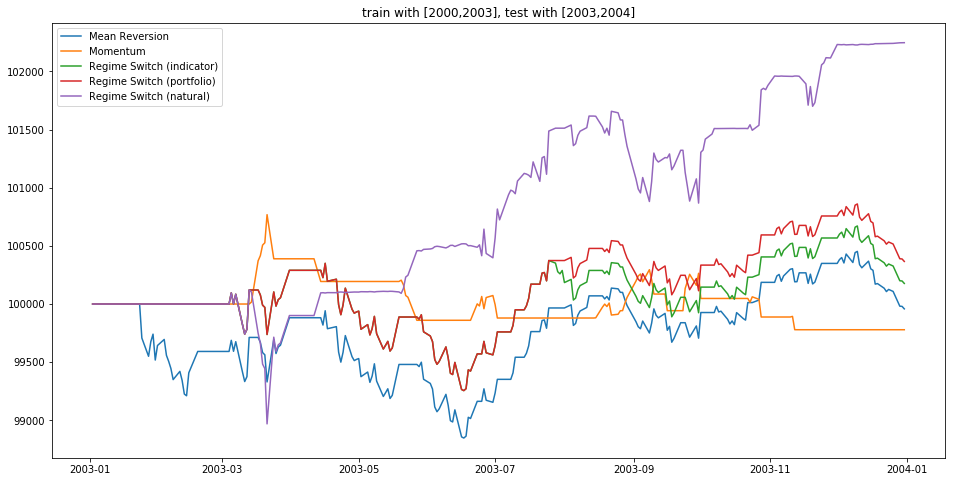

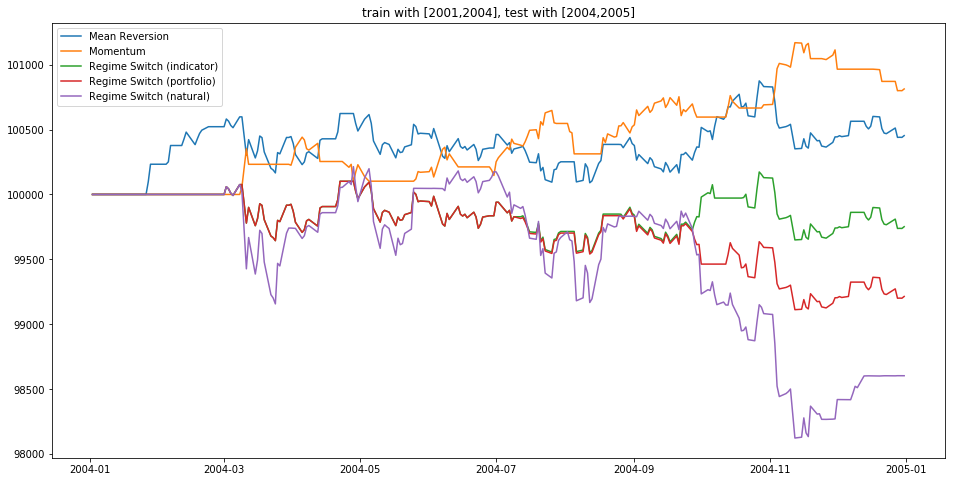

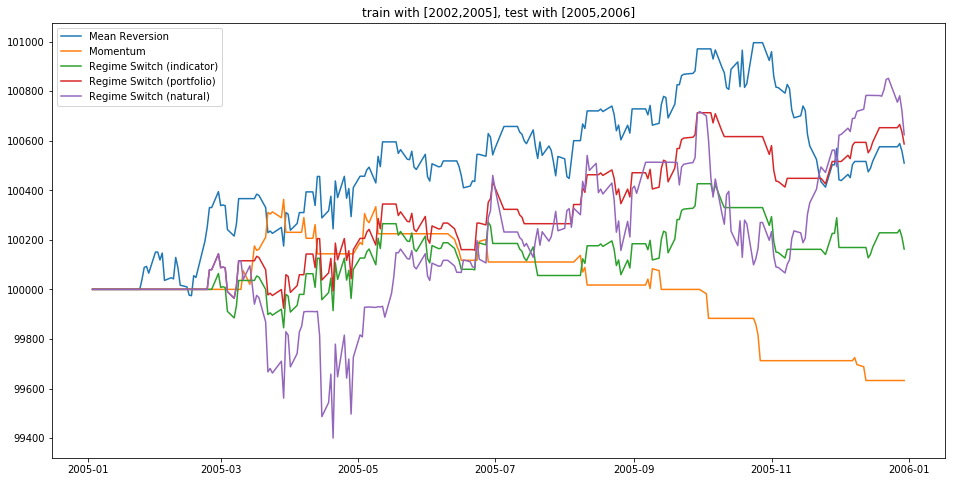

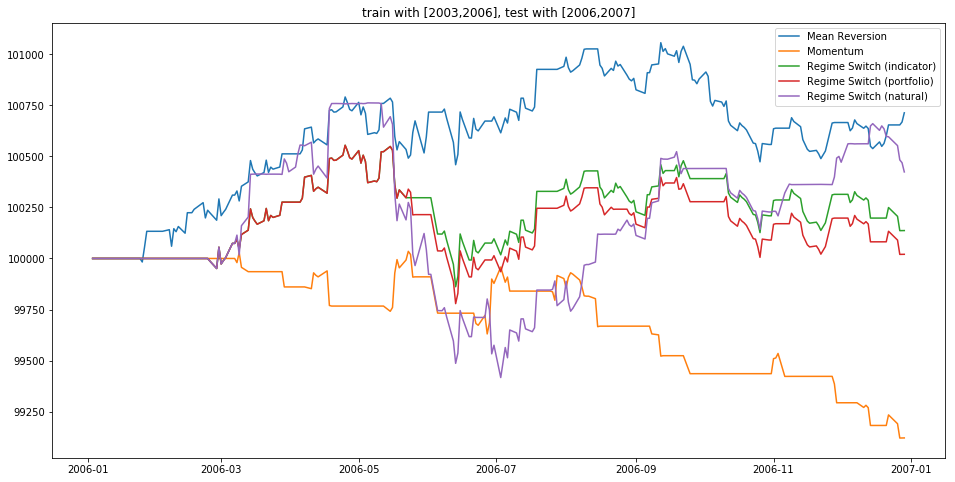

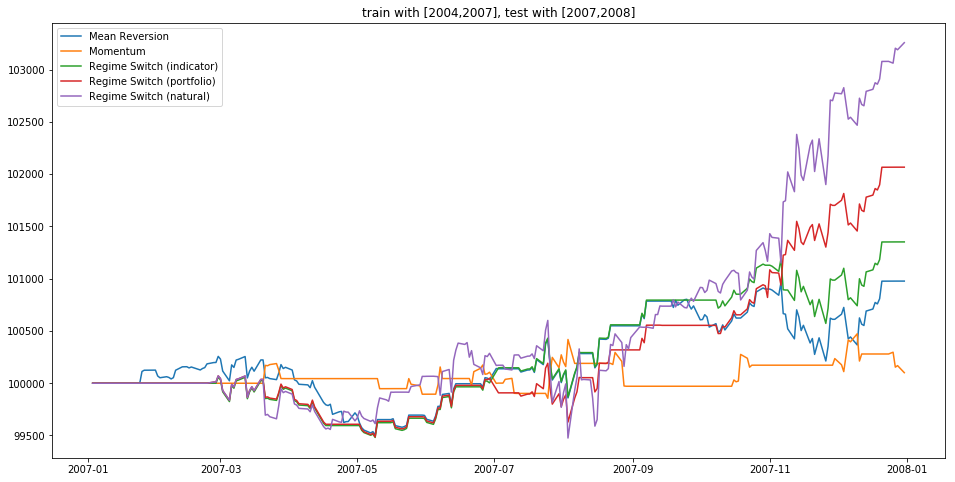

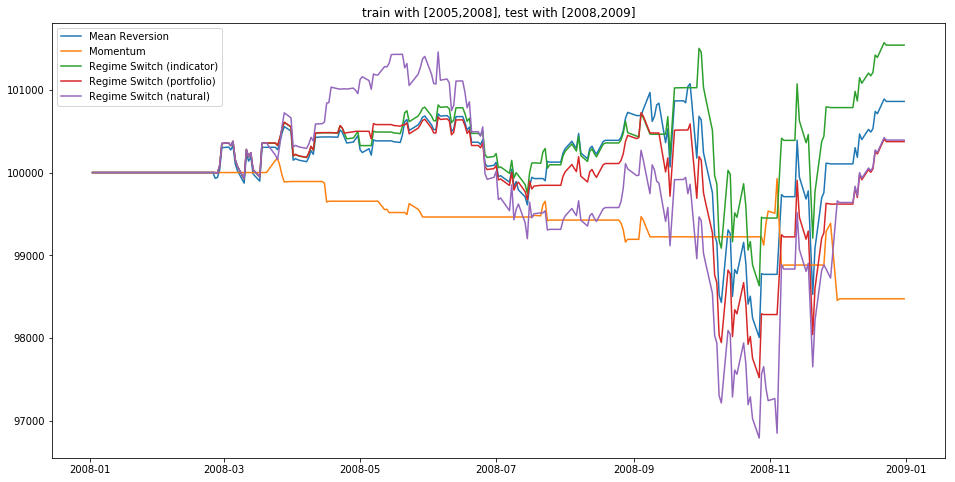

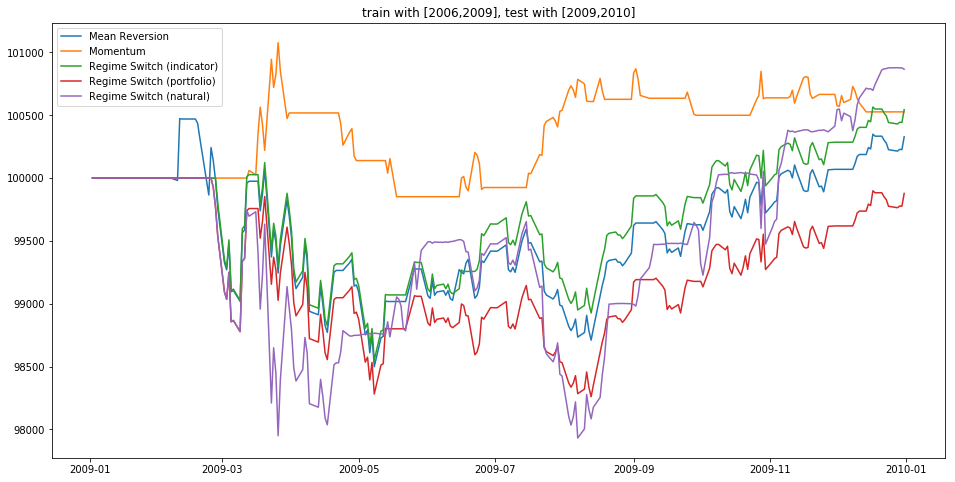

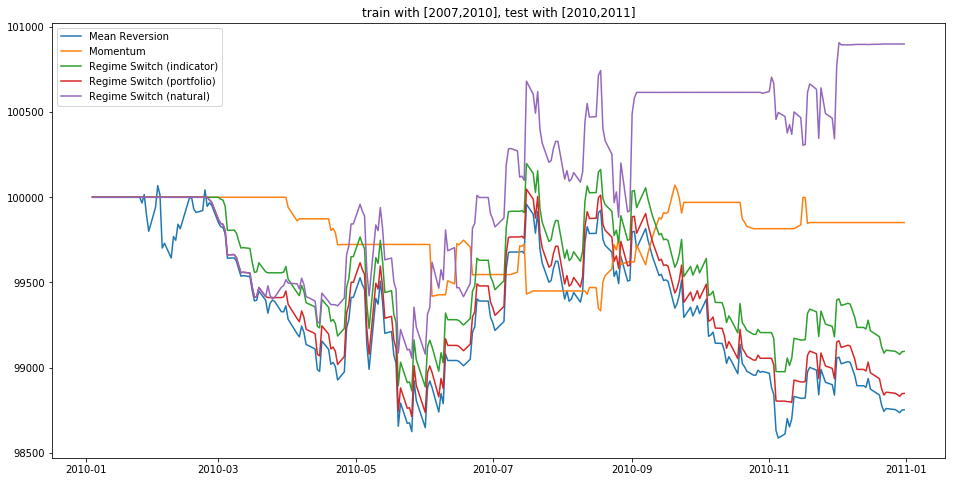

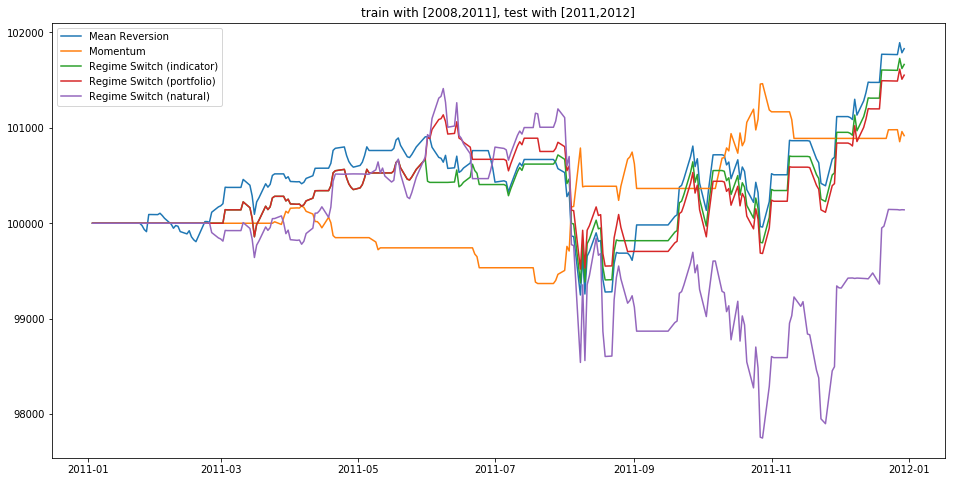

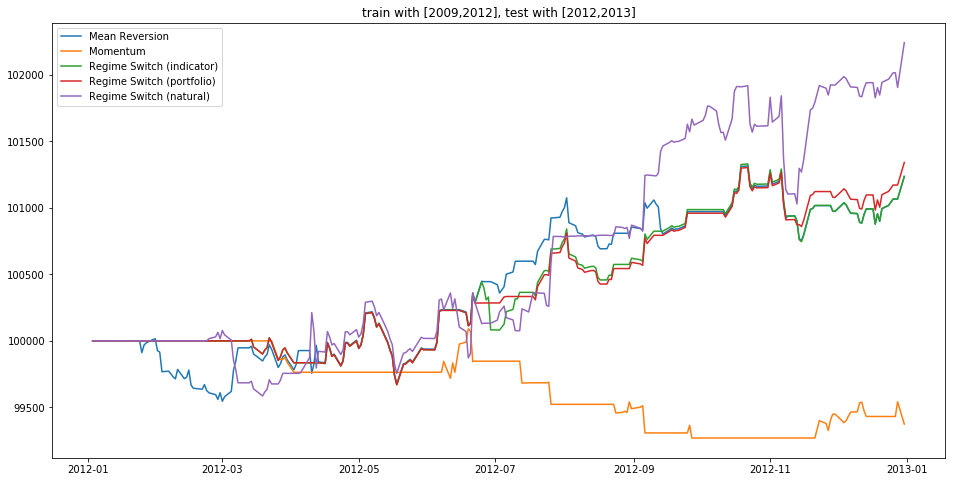

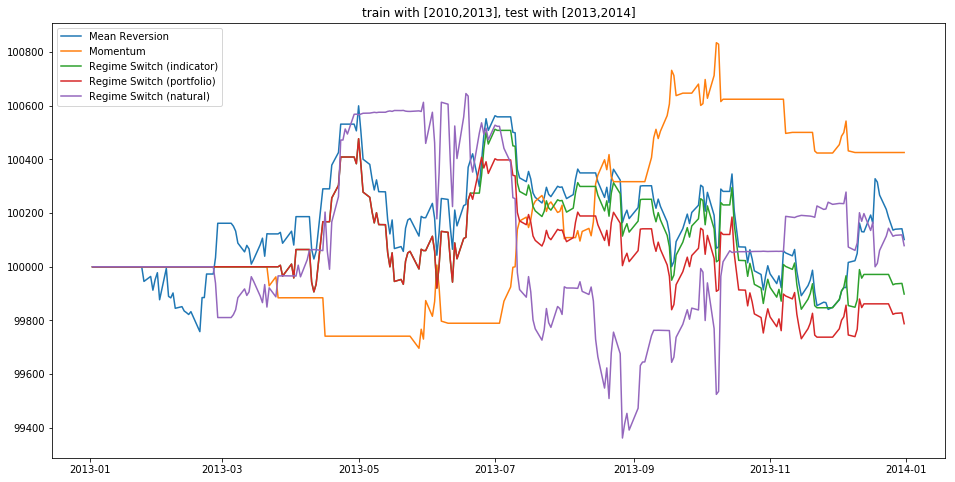

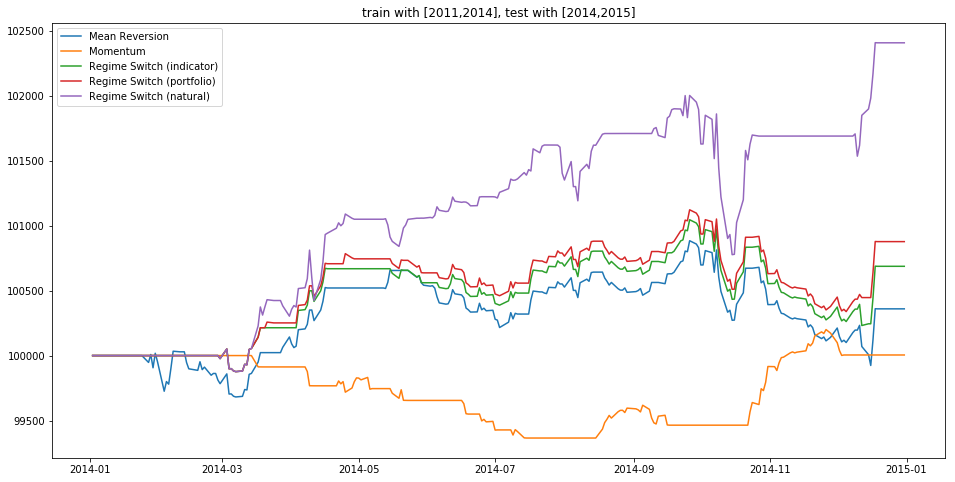

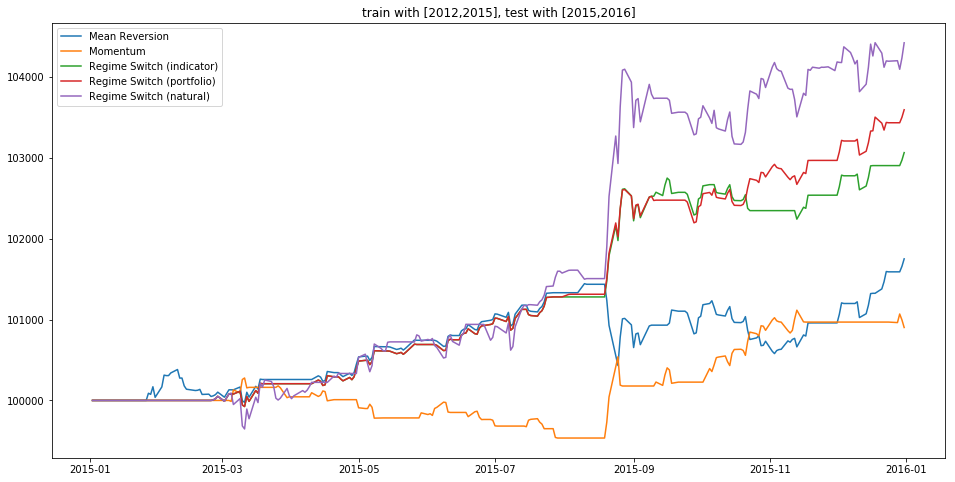

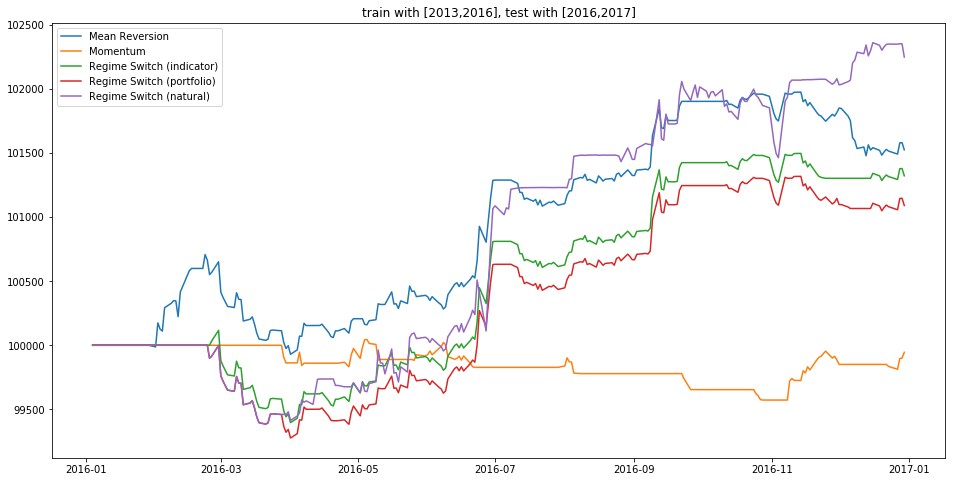

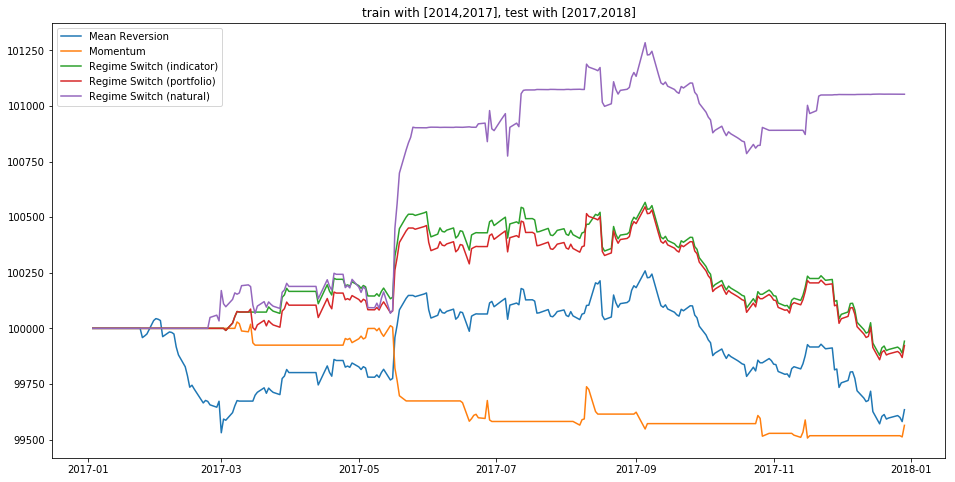

In [35]:
for i in range(15):
    start_year_train = 2000+i
    end_year_train = 2000+i+3
    start_year_test = 2000+i+3
    end_year_test = 2000+i+4
    # load data
    mr_value = get_value_curve("output/mr_%s_%s.csv"%(start_year_test,end_year_test))
    mo_value = get_value_curve("output/mo_%s_%s.csv"%(start_year_test,end_year_test))
    rs_i_value = get_value_curve("output/rs_i[%s,%s]_%s_%s.csv"%(start_year_train,end_year_train,start_year_test,end_year_test))
    rs_p_value = get_value_curve("output/rs_p[%s,%s]_%s_%s.csv"%(start_year_train,end_year_train,start_year_test,end_year_test))
    rs_n_value = get_value_curve("output/rs_n[%s,%s]_%s_%s.csv"%(start_year_train,end_year_train,start_year_test,end_year_test))

    #plot
    fig, ax = plt.subplots(figsize=(16,8))
    ax.plot(mr_value,label="Mean Reversion")
    ax.plot(mo_value,label="Momentum")
    ax.plot(rs_i_value,label="Regime Switch (indicator)")
    ax.plot(rs_p_value,label="Regime Switch (portfolio)")
    ax.plot(rs_n_value,label="Regime Switch (natural)")
    ax.legend()
    ax.set_title("train with [%s,%s], test with [%s,%s]"%(start_year_train,end_year_train,start_year_test,end_year_test))
    plt.savefig("output/curves/[%s,%s]train_[%s,%s]test.png"%(start_year_train,end_year_train,start_year_test,end_year_test))